### **Introduction to Time Series**

The following work focuses on some basic to advanced techniques used in time series to forecast future prices in the field of finance. I really had a lot of fun working on this use case and I think it's a good foundation for those who want to learn about time series forecasting. This notebook is the first part which deals with preprocessing and training the dataset. The second part is saved in a separate notebook and deals with time series forecasting. 

The models used are:
- AR.
- MA.
- ARMA.
- ARIMA.
- SARIMA.
- ARIMAX.
- SARIMAX.
- Auto ARIMA.

**Note:** This code was written on Jupyter Notebook.  
**Language:** Python.  
**Packages:** numpy, pandas, statsmodels, pmdarima, yfinance, math, matplotlib, seaborn, pickle.

In [198]:
import numpy as np
import pandas as pd
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance
import scipy.stats
import pylab
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
# read the dataset
raw_csv_file = pd.read_csv('/Users/papa/Documents/Index2018.csv')
df_comp = raw_csv_file.copy()
df_comp.head(10)

date     spx      dax     ftse    nikkei
0  07/01/1994  469.90  2224.95  3445.98  18124.01
1  10/01/1994  475.27  2225.00  3440.58  18443.44
2  11/01/1994  474.13  2228.10  3413.77  18485.25
3  12/01/1994  474.17  2182.06  3372.02  18793.88
4  13/01/1994  472.47  2142.37  3360.01  18577.26
5  14/01/1994  474.91  2151.05  3400.56  18973.70
6  17/01/1994  473.30  2115.56  3407.83  18725.37
7  18/01/1994  474.25  2130.35  3437.01  18514.55
8  19/01/1994  474.30  2132.52  3475.15  19039.40
9  20/01/1994  474.98  2098.36  3469.99  19183.92

In [3]:
df_comp.describe()

spx           dax         ftse        nikkei
count  6269.000000   6269.000000  6269.000000   6269.000000
mean   1288.127542   6080.063363  5422.713545  14597.055700
std     487.586473   2754.361032  1145.572428   4043.122953
min     438.920000   1911.700000  2876.600000   7054.980000
25%     990.671905   4069.350000  4486.100000  10709.290000
50%    1233.420000   5773.340000  5662.430000  15028.170000
75%    1459.987747   7443.070000  6304.250000  17860.470000
max    2872.867839  13559.600000  7778.637689  24124.150000

In [4]:
df_comp.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

**Plot the data**

<AxesSubplot:title={'center':'S&P500 Prices'}>

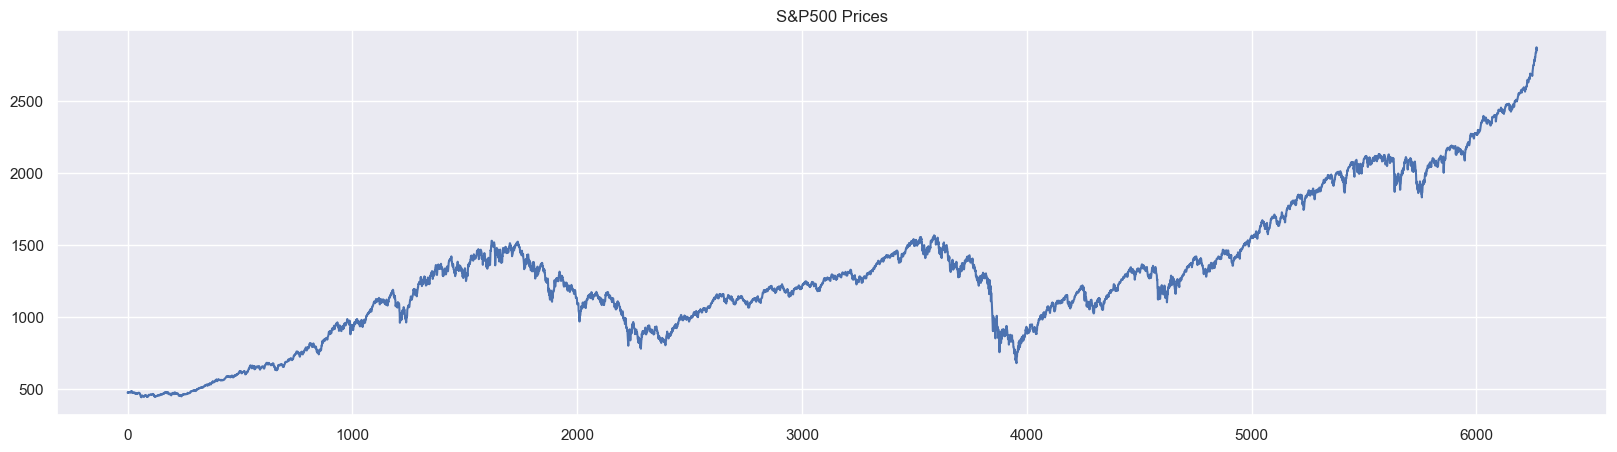

In [5]:
df_comp.spx.plot(figsize = (20, 5), title = 'S&P500 Prices')

<AxesSubplot:title={'center':'FTSE100 Prices'}>

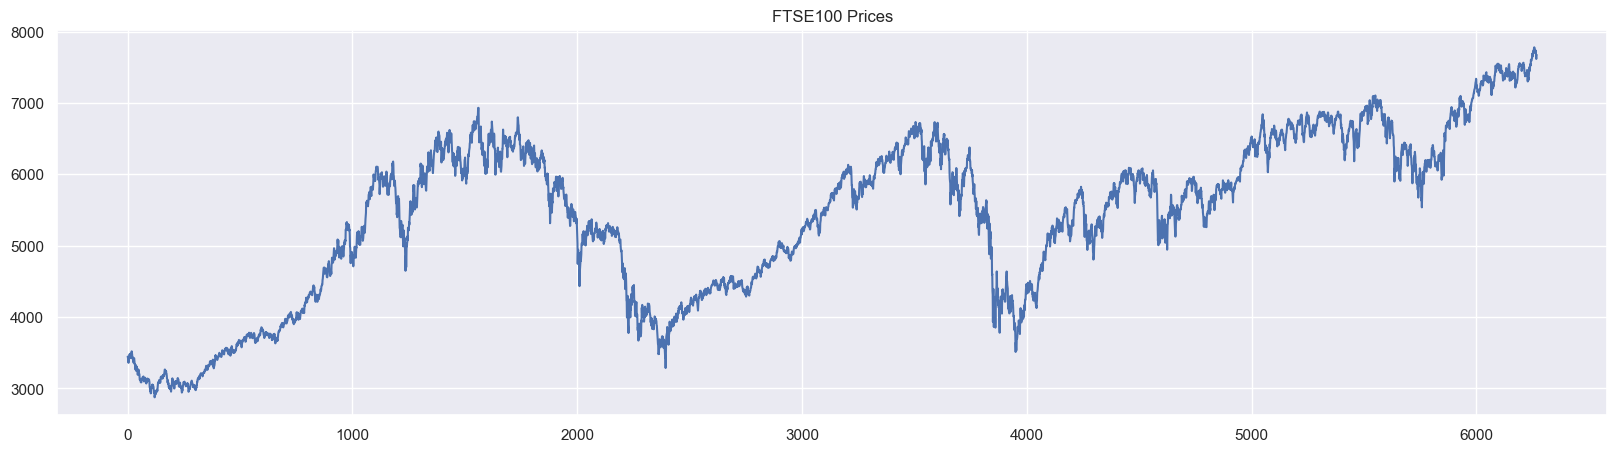

In [6]:
df_comp.ftse.plot(figsize = (20,5), title = 'FTSE100 Prices')

Text(0.5, 1.0, 'S&P500 vs FTSE100')

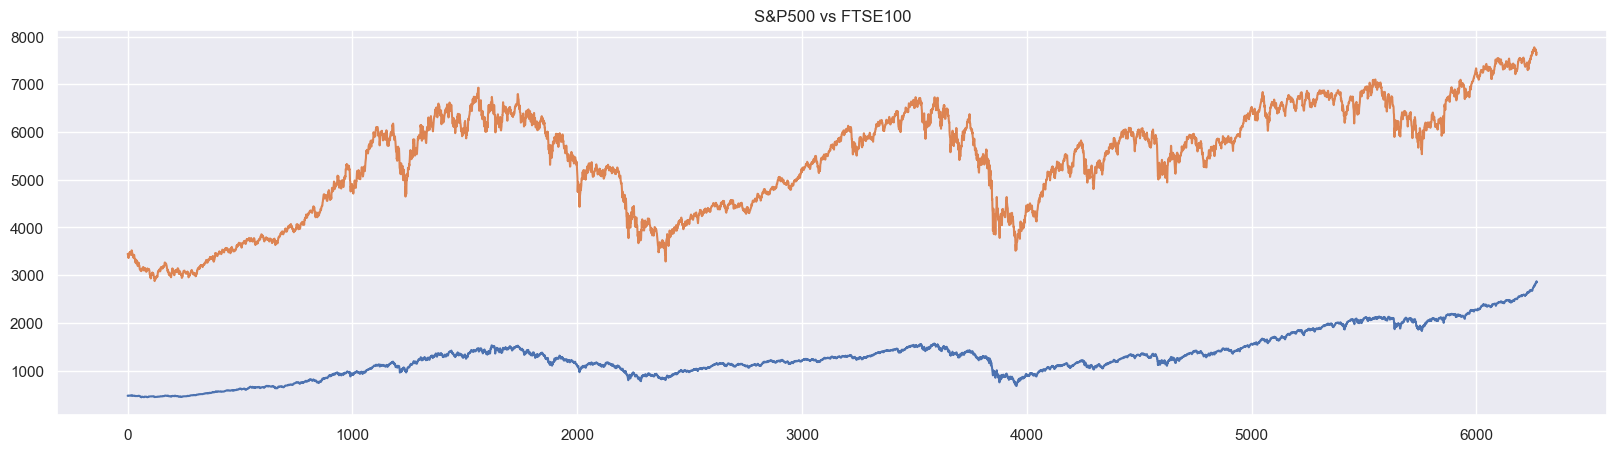

In [7]:
df_comp.spx.plot(figsize = (20, 5), title = 'S&P500 Prices')
df_comp.ftse.plot(figsize = (20,5), title = 'FTSE100 Prices')
plt.title('S&P500 vs FTSE100')

**The QQ Plot (The Quantile-Quantile plot)**  
Used to determine whether a data set is distributed a certain way. It usually showcases how the data fits a normal distribution.

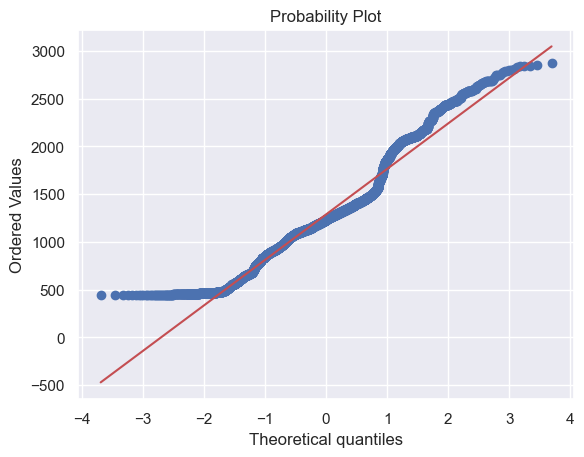

In [8]:
scipy.stats.probplot(df_comp.spx, plot = pylab)
plt.show()

Let's examine the QQ plot and examine what it represents. The QQ plot takes all the values a variable can take, and arranges them in ascending order. 
The theoritical quantiles represent how many standard deviations away from the mean these values are. The red diagonal line represents what the data points should follow, if the they are normally distributed.

### **Creating a Time Series Object**

**From text to date**

In [9]:
df_comp.date.describe()

count           6269
unique          6269
top       07/01/1994
freq               1
Name: date, dtype: object

In [10]:
# the type of the "date" column is an object, it's not saved as a date type variable
# let's convert it to datetype
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)

# display the dataframe
df_comp.head()

date     spx      dax     ftse    nikkei
0 1994-01-07  469.90  2224.95  3445.98  18124.01
1 1994-01-10  475.27  2225.00  3440.58  18443.44
2 1994-01-11  474.13  2228.10  3413.77  18485.25
3 1994-01-12  474.17  2182.06  3372.02  18793.88
4 1994-01-13  472.47  2142.37  3360.01  18577.26

In [11]:
df_comp.date.describe()

count                    6269
unique                   6269
top       1994-01-07 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

**Setting the index**

Each values should correspond to a time period. We often wish to examine specific chunks of data between two concrete dates. For example: Separating the data before and after September 15th 2008. We need to use the associated time periods as indices. 

In [12]:
# set the "date" column as an index
df_comp.set_index('date', inplace = True)

# display "df_comp"
df_comp.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25
1994-01-12  474.17  2182.06  3372.02  18793.88
1994-01-13  472.47  2142.37  3360.01  18577.26

**Setting the desired frequency**

In [13]:
# we'll use the df.asfreq() method to set the desired frequencies
# the values this argument can take are specific letters of the alphabet
# for example: "h" - hourly, "w" - weekly, "d" - daily, "m" - monthly
# data mesured once per year is "annual" rather than "yearly", so we use "a", instead of "y"
df_comp = df_comp.asfreq('d')

# display "df_comp"
df_comp.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-08     NaN      NaN      NaN       NaN
1994-01-09     NaN      NaN      NaN       NaN
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25

In [14]:
# we see that we generated new periods, which do not have values associated with them
# another peculiarity of ou data is that it represents closing prices of financial indices
# these prices can only recorded during working days, so we're not interested in weekends or holidays
# if we check the calendar we find that the generated dates "1994-01-08" & "1994-01-09" are actually weekends
# so we better avoid adding such time periods into our dataset
# the asfreq() method accepts the value "b" which states that the data was recorded only on business days
# Using “b” tells Python to expect missing values when the date falls on a Saturday or a Sunday.
# let's again apply the asfreq() method and use the value "b" instead
# using the value "b" avoids adding many unnecessary time periods
df_comp = df_comp.asfreq('b')

# display "df_comp"
df_comp.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25
1994-01-12  474.17  2182.06  3372.02  18793.88
1994-01-13  472.47  2142.37  3360.01  18577.26

**Handling missing values**

In [15]:
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [16]:
# setting the frequency to "business days" must have generated 8 dates, for which we have no data available
# use df.fillna() method to fill the missing values
# 1) front filling: assigns the value of the previous period
# 2) back filling: assigns the value for the next period
# 3) assigning the same value: assign the average to all the missing values within time-series

# front filling
df_comp.spx.fillna(method = 'ffill', inplace = True)
df_comp.isna().sum()

spx       0
dax       8
ftse      8
nikkei    8
dtype: int64

In [17]:
# back filling
df_comp.ftse.fillna(method = 'bfill', inplace = True)
df_comp.isna().sum()

spx       0
dax       8
ftse      0
nikkei    8
dtype: int64

In [18]:
# same value: mean
df_comp.dax.fillna(value = df_comp.dax.mean(), inplace = True)
df_comp.isna().sum()

spx       0
dax       0
ftse      0
nikkei    8
dtype: int64

In [19]:
# back filling
df_comp.nikkei.fillna(method = 'bfill', inplace = True)
df_comp.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

**Simplifying the dataset**

In [20]:
# analyzing how the S&P500 performs
# we can remove the columns for the FTSE, DAX and NIKKEI
# the main reasons are:
# 1. the less data we load, the faster we can manipulate it
# 2. Clarity. Easier to keep track of the dataset

# create a new column
df_comp['market_value'] = df_comp.spx
df_comp.describe()

spx           dax         ftse        nikkei  market_value
count  6277.000000   6277.000000  6277.000000   6277.000000   6277.000000
mean   1288.642547   6080.063363  5423.690398  14597.597179   1288.642547
std     487.868210   2752.604984  1145.568370   4043.683038    487.868210
min     438.920000   1911.700000  2876.600000   7054.980000    438.920000
25%     992.715221   4070.460000  4487.880000  10701.130000    992.715221
50%    1233.761241   5774.380000  5663.300000  15030.510000   1233.761241
75%    1460.250000   7442.660000  6304.630175  17860.470000   1460.250000
max    2872.867839  13559.600000  7778.637689  24124.150000   2872.867839

In [21]:
# remove columns
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']
df_comp.describe()

market_value
count   6277.000000
mean    1288.642547
std      487.868210
min      438.920000
25%      992.715221
50%     1233.761241
75%     1460.250000
max     2872.867839

**Splitting the data**

In [22]:
# time series data relies on keeping the chronological order of the values
# so shuffling time series data when splitting is not possible
# Training set: from the beginning up to some cut off point
# Testing set: from cut off point until the end
size = int(len(df_comp) * 0.8)
df_train = df_comp.iloc[:size]
df_test = df_comp.iloc[size:]

df_train.tail()

market_value
date                    
2013-04-01   1562.173837
2013-04-02   1570.252238
2013-04-03   1553.686978
2013-04-04   1559.979316
2013-04-05   1553.278930

In [23]:
df_test.head()

market_value
date                    
2013-04-08   1563.071269
2013-04-09   1568.607909
2013-04-10   1587.731827
2013-04-11   1593.369863
2013-04-12   1588.854623

In [24]:
# the df_train dataframe ends at date "2013-04-05"
# and the df_test dataframe starts just after this date at "2013-04-08	"
# this is to say that we made sure there is no overlap
# the dates "2013-04-06" and "2013-04-07" were not present because they are not business days (weekends)

### **Working with Times Series in Python**

**White noise**

White noise is special type of time series where the data doesn't follow a pattern. We can generate white noise data and plot its values. Plotting the graph of the S&P closing prices and compare the two. 

In [25]:
# generate random variables with a normal distribution
wn = np.random.normal(loc = df_train.market_value.mean(), scale = df_train.market_value.std(), size = len(df_train))

# adding white noise to the dataframe
df_train['wn'] = wn

# descriptives
df_train.describe()

market_value           wn
count   5021.000000  5021.000000
mean    1091.651926  1087.877533
std      292.559287   293.380218
min      438.920000    56.768773
25%      914.620000   894.662449
50%     1144.650000  1088.411575
75%     1316.280729  1281.866760
max     1570.252238  2339.695520

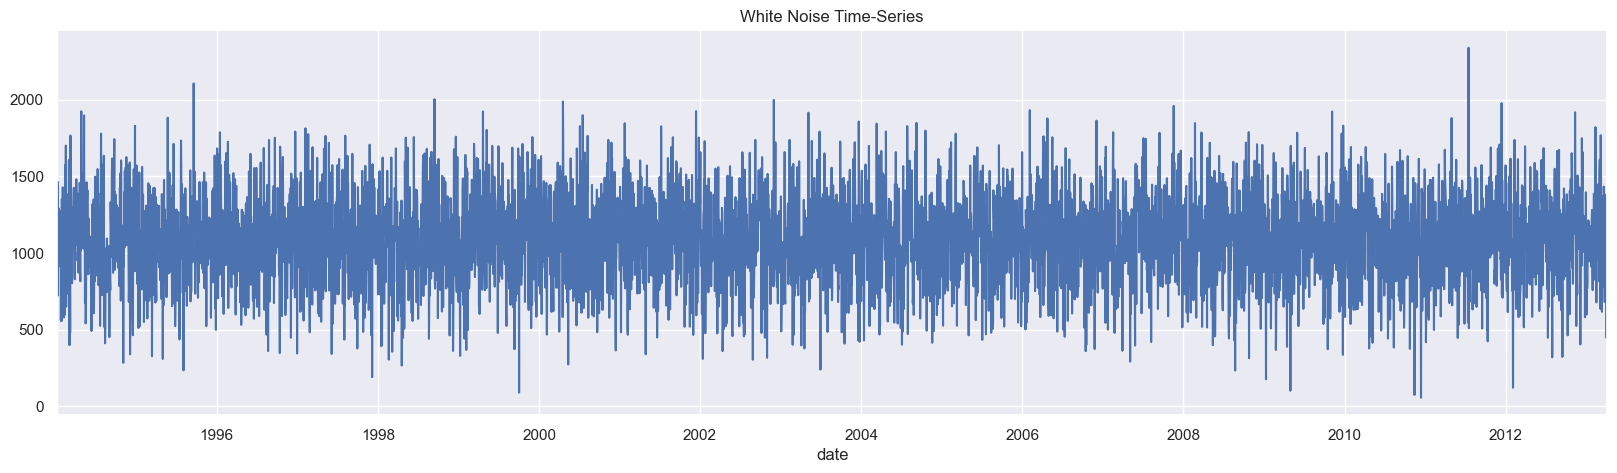

In [26]:
# we can see that the mean of the "wn" column is almost similar to the mean of market value 
# this is because the whote noise values that we generated are normally distributed around the mean of the S&P
# since each value is generated individually the average does not have to end up being the same
df_train.wn.plot(title = 'White Noise Time-Series', figsize = (20,5))
plt.show()

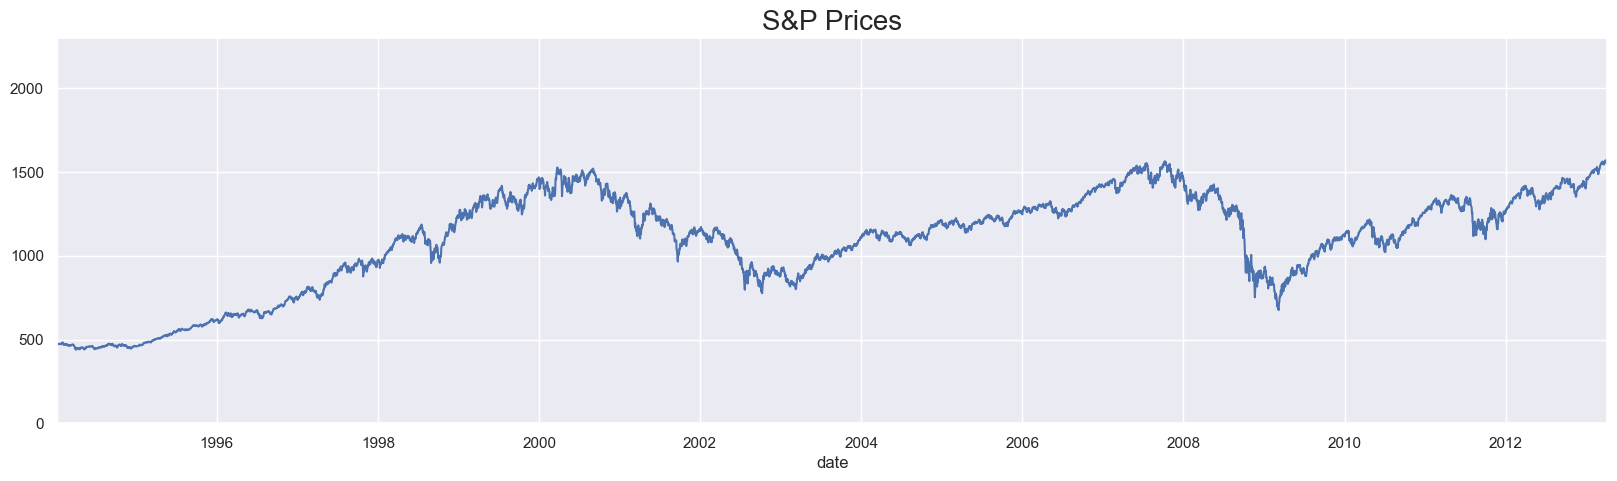

In [27]:
# we can see how the noise values are approximately around the mean of the S&P prices
# let's plot the S&P prices for comparison
df_train.market_value.plot(figsize = (20,5))
plt.ylim(0,2300) # set the limits for the y-axis so it can be approximately the same with the other graph
plt.title('S&P Prices', size = 20)
plt.show()

In [28]:
# we can notice that there are smaller jumps between periods for the S&P values

**Random walk**

A special type of time-series where values tend to persist over time and the differences between periods are simply white noise.

In [29]:
# let's load another csv file named "RandWalk.csv"
rw = pd.read_csv('/Users/papa/Documents/RandWalk.csv')

# print the first few rows
rw.head()

date        price
0  07/01/1994  1122.139662
1  08/01/1994  1135.238562
2  09/01/1994  1109.897831
3  10/01/1994  1080.347860
4  11/01/1994  1082.095245

In [30]:
rw.dtypes

date      object
price    float64
dtype: object

In [31]:
# convert the "date" column to date type
rw.date = pd.to_datetime(rw.date, dayfirst = True)

rw.dtypes

date     datetime64[ns]
price           float64
dtype: object

In [32]:
rw.date.describe()

count                    7029
unique                   7029
top       1994-01-07 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2013-04-05 00:00:00
Name: date, dtype: object

In [33]:
rw.set_index('date', inplace = True)
rw = rw.asfreq('b')
rw.head()

price
date                   
1994-01-07  1122.139662
1994-01-10  1080.347860
1994-01-11  1082.095245
1994-01-12  1083.639265
1994-01-13  1067.146255

In [34]:
# add the "price column of the "rw" dataframe to "df_train"
df_train['rw'] = rw
df_train.head()

market_value           wn           rw
date                                              
1994-01-07        469.90  1072.938450  1122.139662
1994-01-10        475.27   720.559389  1080.347860
1994-01-11        474.13  1464.322535  1082.095245
1994-01-12        474.17  1064.052279  1083.639265
1994-01-13        472.47   910.793847  1067.146255

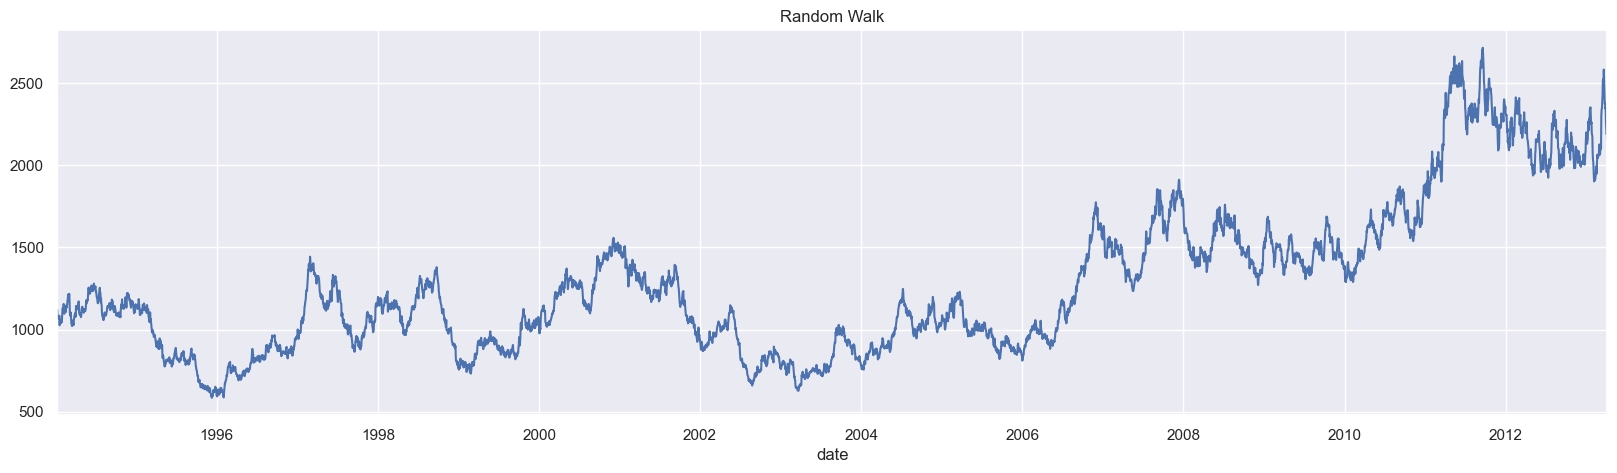

In [35]:
# plot the "rw" column
df_train.rw.plot(title = 'Random Walk', figsize = (20,5))
plt.show()

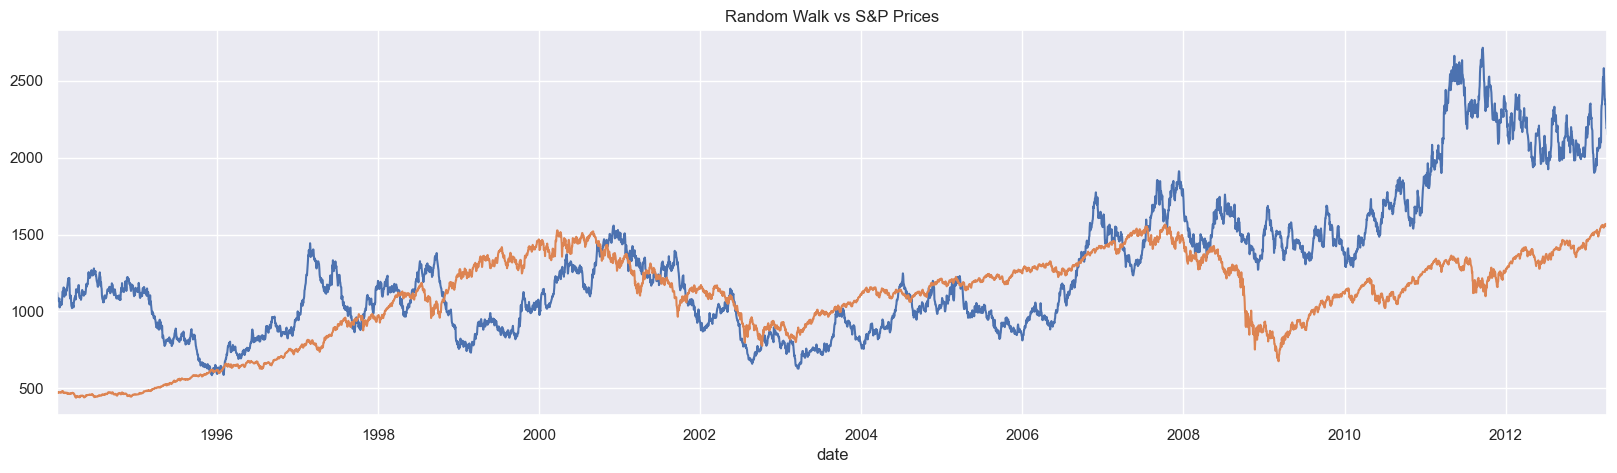

In [36]:
# plot this column with the S&P prices
df_train.rw.plot(figsize = (20,5))
df_train.market_value.plot(figsize = (20,5))
plt.title('Random Walk vs S&P Prices')
plt.show()

In [37]:
# both graphs have small variations between consecutive time periods
# both have cyclical increases and decreases in short periods of time
# in finance there is a term called "Market efficiency",
# which measures the level of difficulty in forecasting correct future values 

**Stationarity**

To conduct proper time series analysis, it is vital to determine if the data follows a stationary or a non-stationary process. David Dickey and Wayne Fuller developped a test to help us check whether a dataset comes from a stationary process. We call it the Dickey-Fuller test. We need to learn how to use it. 

First we need to set the null hypothesis:
- The null in the Dickey-Fuller test assumes non-stationarity --> H0: non-stationarity. More precisely, it assumes that the one lag autocorrelation coefficient is lower than 1. 
- The alternative hypothesis assumes stationarity --> H1: stationarity. More precisely, it assumes that the one lag autocorrelation coefficient is equal to 1. 

Once the test statistic is computed we can compare it to the critical value in the Dickey-Fuller table. If the test statistic is lower than the critical value, then we reject the null, so the data comes from a stationary process.


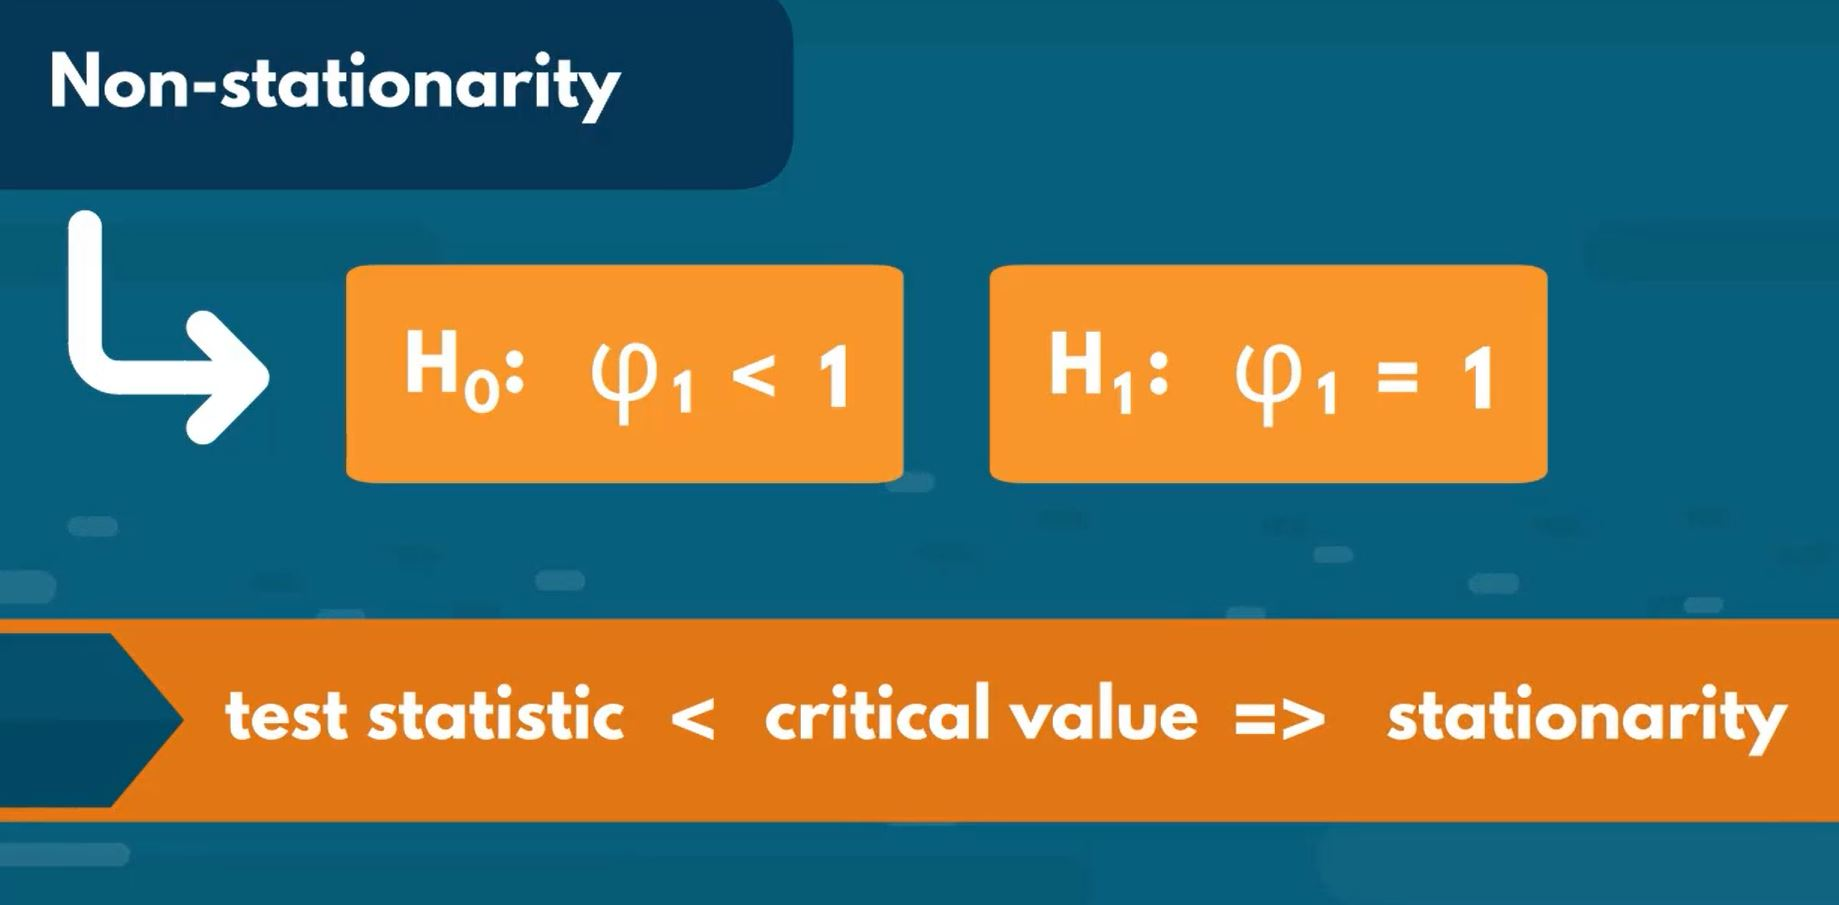

In [38]:
# test the stationarity with the "Dickey Fuller" method
sts.adfuller(df_train.market_value)

(-1.73698474523524,
 0.412164569677064,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

**Analysis of the result:**  
- The first line represents the t statistic (-1.736984745235244).
- Python provides us with three critical values {'1%': -3.431658008603046,'5%': -2.862117998412982,'10%': -2.567077669247375} from the Dickey-Fuller table. We can use any of them as a level of significance in our analysis. Furthermore, we can notice that the critical statistic is above any of the critical values, thus for any of these levels of significance we cannot find any evidence of stationarity in the dataset.
- The second line of the "Dickey Fuller" method represents the p-value associated with the t statistic 0.41216456967706194. Let's see how the p-value equals to 0.41: this suggests there is a roughly 41% chance of not rejecting the null hypothesis, so we can't confirm the data as stationary.
- The third line (18) represents the number of lags used in the regression when determining the t statistic. In this case we have 18, so there is some autocorrelation going back 18 periods. We'll take this into account when picking up the appropriate model.
- The next line (5002) expresses the number of observations used in the analysis. This value depends on the number of lags used in the regression, so usally the two should add up to the size of the dataset.
- The last line of the code estimates the maximized information criteria provided there is some apparent autocorrelation, the lower the values the easier to make predictions for the future.

In [39]:
# to provide some comparison to what these results mean, let's run the test for the white noise data we generated earlier
# we know that white noise is a stationary process so we expect to get a very low p-value
# additionally since there is no autocorrelation in white noise, there should be no lags involved in the regression
sts.adfuller(df_train.wn)

(-71.22150850708115,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70834.1795441072)

**Analysis of the result:**  
We see exactly what we expected: a p-value closer to 0 and no lags being part of the regression.

In [40]:
# let's also run the augmented Dickey-Fuller test for the random walk data
sts.adfuller(df_train.rw)

(-1.328607392768972,
 0.6159849181617384,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

**Analysis of the result:**  
We see a p-value of around 0.62. We don't have significant evidence to identify this time series as stationary. In fact, based on the p-value there is more than 60% chance this data comes from a non-stationary process.

**Seasonality**

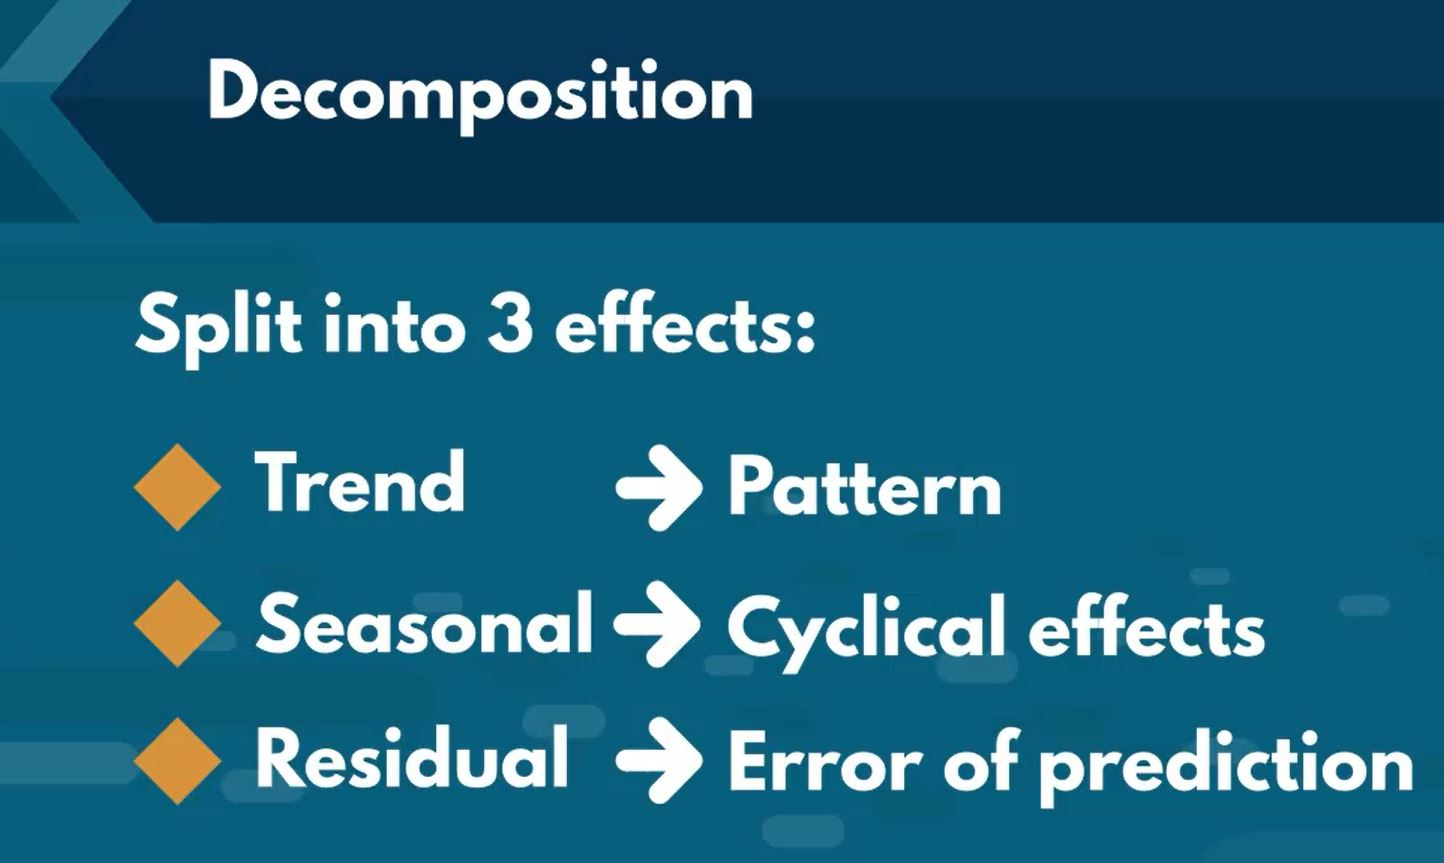

The simplest type of decomposition is called "Naive".

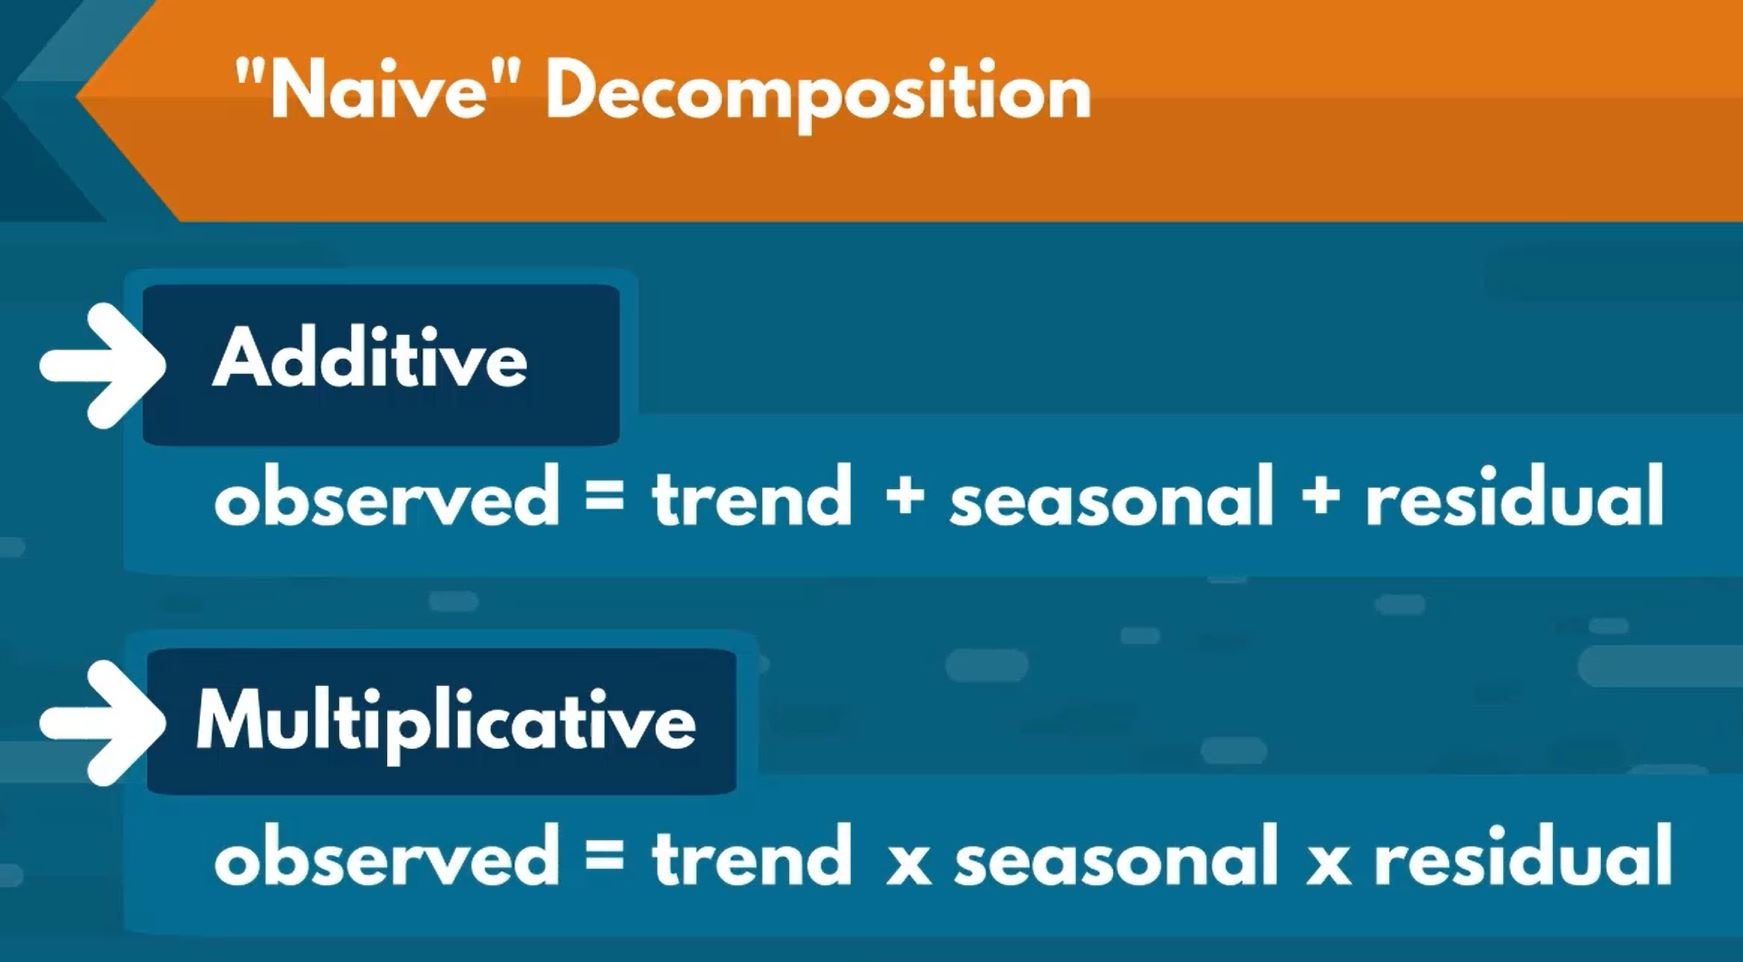

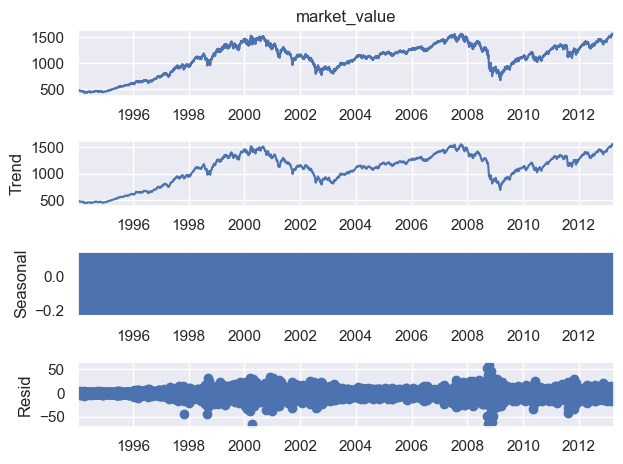

In [41]:
# additive decomposition
s_dec_additive = seasonal_decompose(df_train.market_value, model = 'additive')
s_dec_additive.plot()
plt.show()

**Analysis:**  
As we can see, the trend closely ressembles the observed series. That's because the decomposition function uses the previous period values as trend-setter. We've already determined that current period prices are the best predictor for the next period's prices. If we observe seasonal patterns we'll have other prices as better predictors. For instance, if prices are consistently higher at the beginning of the month compared to the end, we'll be better off using values from some 30 periods ago than from one period to go. The trend part of the decomposition explains most of the variability of the data. The seasonal plot looks like a rectangle, this happens when the values are constantly oscillating back and forth and the figure sizes too small. In our case, the linear change results from constantly switching up and down between -0.2 and 0.1 for every period. Therefore, there is no concrete cyclical pattern determined by using naive decomposition. The residuals are the errors of our model estimates. Essentially, they're the difference between true values and predictions for any period. As we can see, the residuals vary greatly around 2000 and around 2008. Overall, the results of the additive decomposition suggests no seasonality in the data.

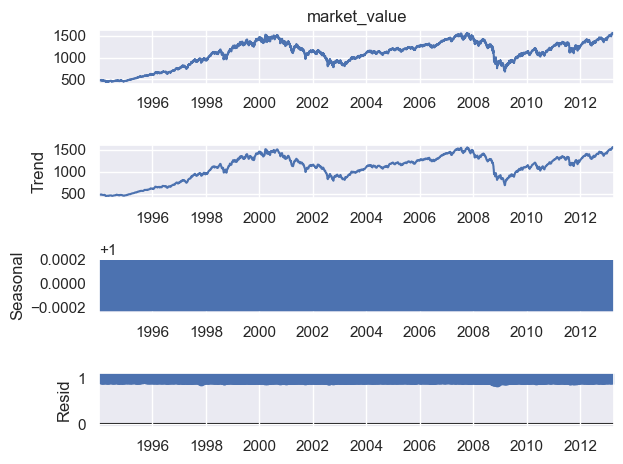

In [42]:
# multiplicative decomposition
s_dec_multiplicative = seasonal_decompose(df_train.market_value, model = 'multiplicative')
s_dec_multiplicative.plot()
plt.show()

For the multiplicative decomposition we see very similar results to the first decomposition. The seasonal sequence has no clear pattern once again, and the trend closely ressembles the observed series. Thus, we have further proof there is no seasonality among S&P prices. 

**Autocorrelation function (ACF)**

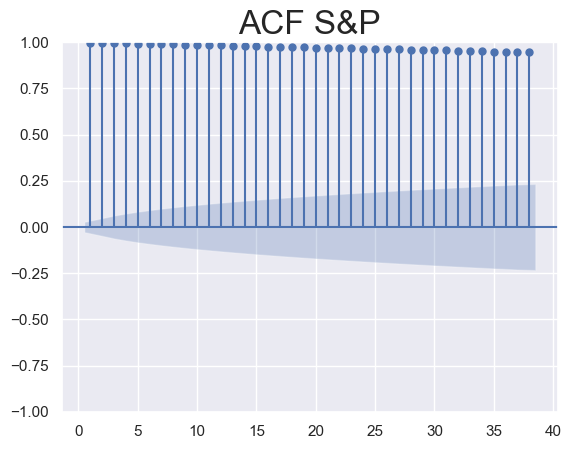

In [43]:
# plot the autocorrelation function
# analyze the first 40 lags
# by the first 40 lags we mean the last 40 periods before the current one
# the "zero" argument specifies whether we include current period values in the graph
sgt.plot_acf(df_train.market_value, zero = False)
plt.title('ACF S&P', size = 24)
plt.show()

**Examine the ACF S&P graph:**  
- Values in the x-axis represents graphs. We can notice how they go up to 40 since that is what we set the "lags" argument equal to.  
- Numbers on the left equal to the autocorrelation coefficients. 
- Coefficients can take only values -1 and 1. 
- The thin line across the plot represents the autocorrelation between a time series and a lagged copy of itself. 
- The first line represents autocorrelation one time period ago. The second line indicates autocorrelation two time periods ago and so on. 
- The blue area around the x-axis represents significance. The values situated outside are significantly different from zero, which suggests the existence of autocorrelation for that specific lag. 
- We can notice how this area expands as the lag values increase. The greater the distance in time, the more unlikely it is that this aitocorrelation persists. For instance, today's prices are usually closer to yesterday's prices than the prices a month ago. Therefore, we need to make sure that the autocorrelation coefficient in higher lags is sufficiently significant to be different from zero. 
- We also notice how all the lines are higher than the blue region. This suggests the coefficients are significant which is an indicator of time dependence in the data. Moreover, we can see that the autocorrelation barely diminishes as the lags increase, this in turn suggests that prices even a month back can serve as decent estimators. 

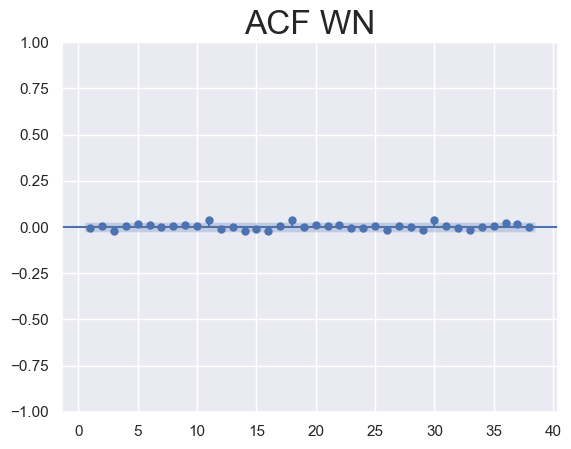

In [44]:
# let's plot the ACF for the white noise
sgt.plot_acf(df_train.wn, zero = False)
plt.title('ACF WN', size = 24)
plt.show()

**Examine the ACF S&P graph:** 
- The ACF WN graph is completely different from the ACF S&P graph. We have values going either way. So there are patterns of positive and negative autocorrelation. This contrasts the ACF S&P prices where all values were positive.
- Also we can observe how the lines fall within the blue area, thus the coefficients are not significant across the entire plot. This suggests there is no autocorrelation for any lag which is one of the assumptions of white noise data. 

**Partial autocorrelation function (PACF)**

Autocorrelation measures the correlation between a time series and a lg version of itself. If we want to capture the direct relationship between the time series and its lagged version we have to compute the partial autocorrelation.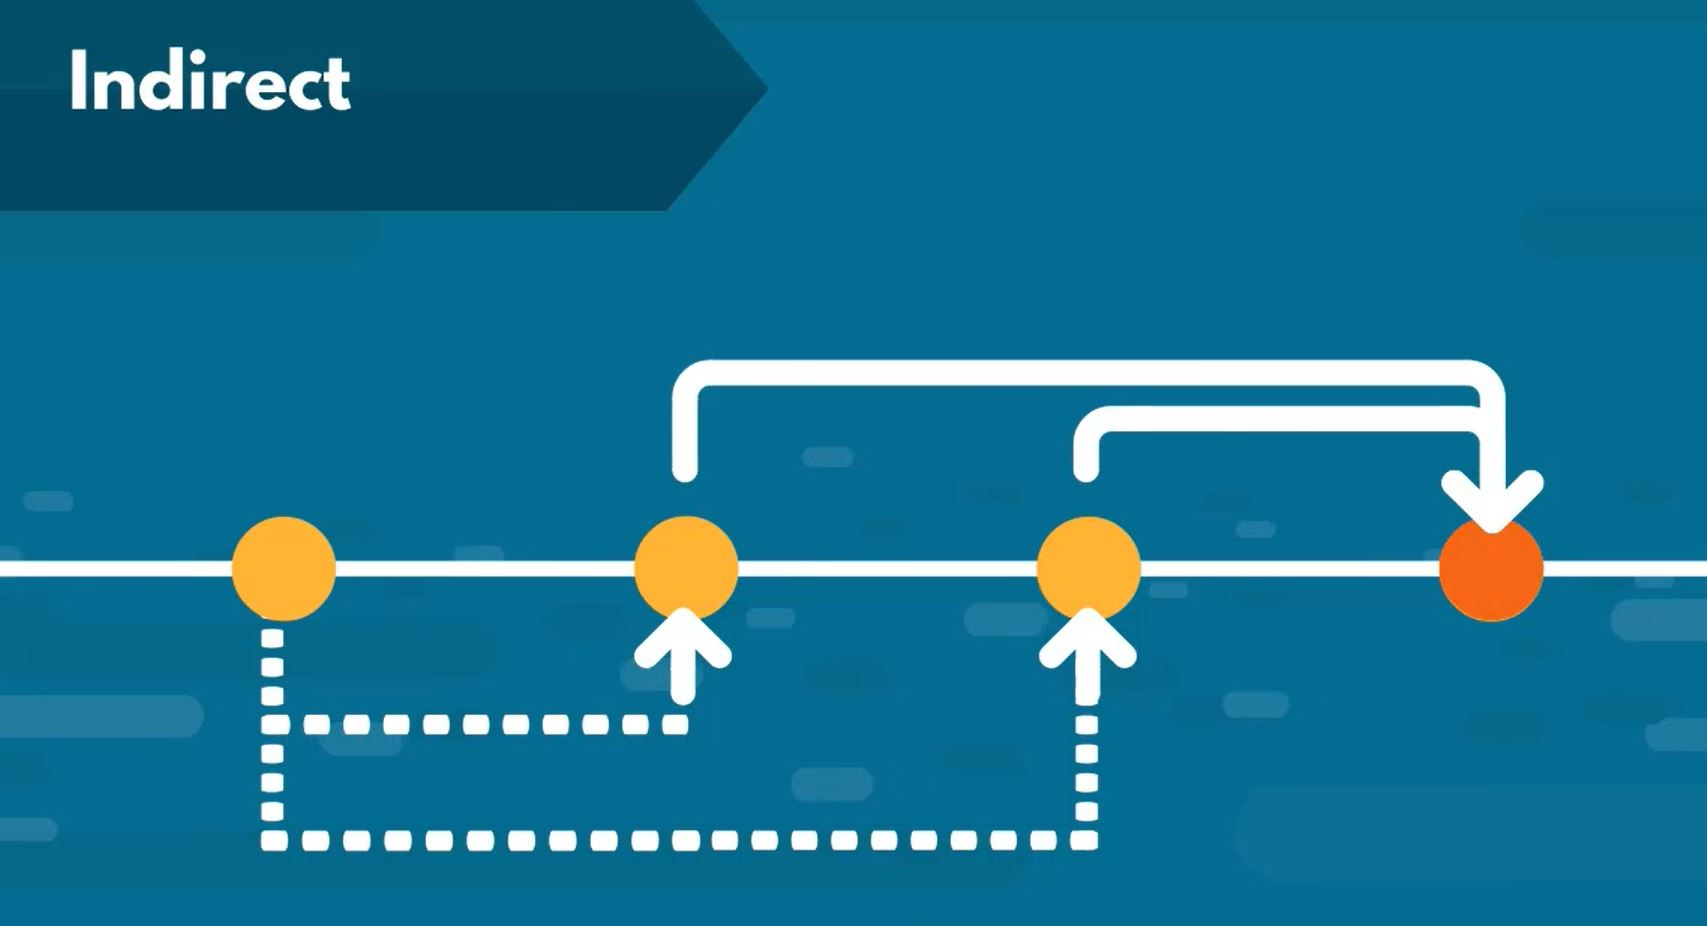

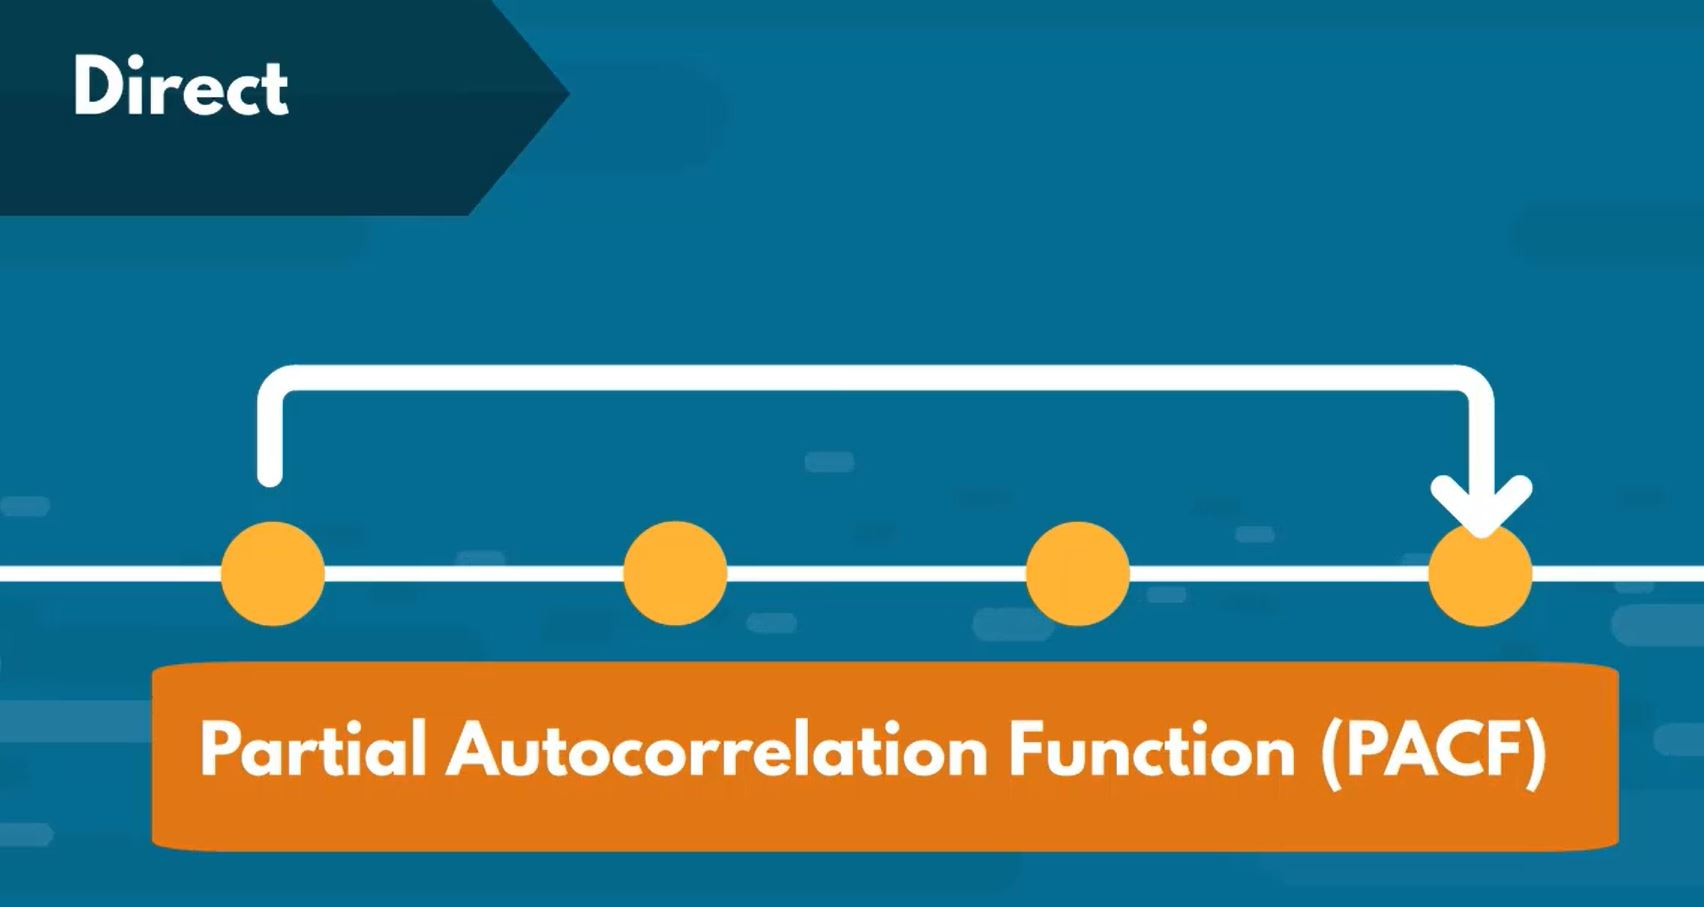

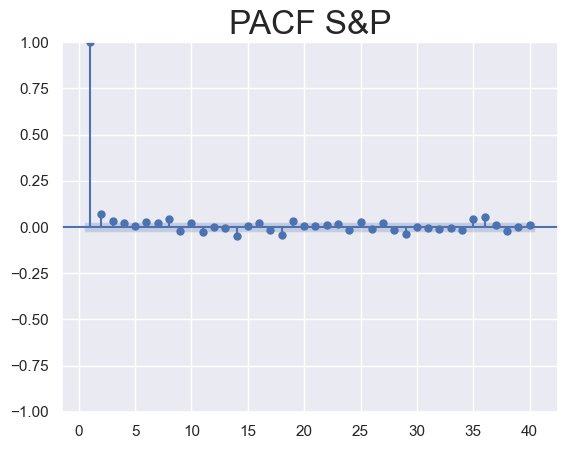

In [45]:
# plot the pacf for S&P 
# there are several ways of computing the pacf so we need to define what method to use
# in this instance, I will rely on the Order of Least Squares (OLS)
sgt.plot_pacf(df_train.market_value, lags = 40, zero = False, method = ('ols'))
plt.title('PACF S&P', size = 24)
plt.show()

**Examine the PACF graph:**
- Only the first elements are significantly different from zero. A tremendous contrast to the ACF plot where all values up to 40 lags are significant. 
- Some of the values are negative like the ninth lag. This means that higher values nine periods ago result in a lower value today and vise versa.
- The difference between the two graphs comes from how the PACF works, it cancels out all additional channels a previous period value affects the present one. For instance, the PACF measures the effect values in period t-2 have on values in period t directly (Xt-2 --> Xt). So the PACF values cancel out the effects prices two days ago have on prices yesterday which in turn affect prices today (Xt-1 --> Xt-1 --> Xt). Therefore, the ACF shows the combined effect on the prices from two days ago both direct and through yesterday's prices (Xt-2 --> Xt & Xt-2 --> Xt-1 --> Xt) while the PACF only shows the direct effect (Xt-2 --> Xt).
- We must note that the ACF and the PACF values for the first lag should be identical. This is because there are no other channels through which past values can affect present values. 
- Also we can notice how most values after the third lag are in the blue area. This means they aren't significantly different from zero. So numeric values attached to them are not important. Since we can assume they are all essentialy zero, being positive or negative is somewhat random without any lasting effect.  

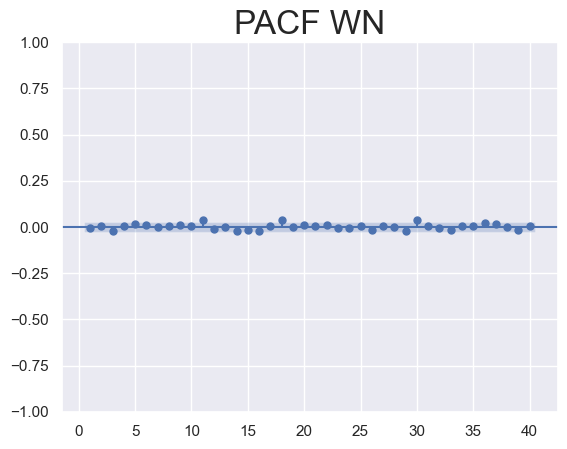

In [46]:
# plot the pacf for the white noise
# there are several ways of computing the pacf so we need to define what method to use
# in this instance, I will rely on the Order of Least Squares (OLS)
sgt.plot_pacf(df_train.wn, lags = 40, zero = False, method = ('ols'))
plt.title('PACF WN', size = 24)
plt.show()

That's what we expected. The coefficients are random as we don't expect any autocorrelation in white noise. 

### **The Autoregressive Model (AR)**

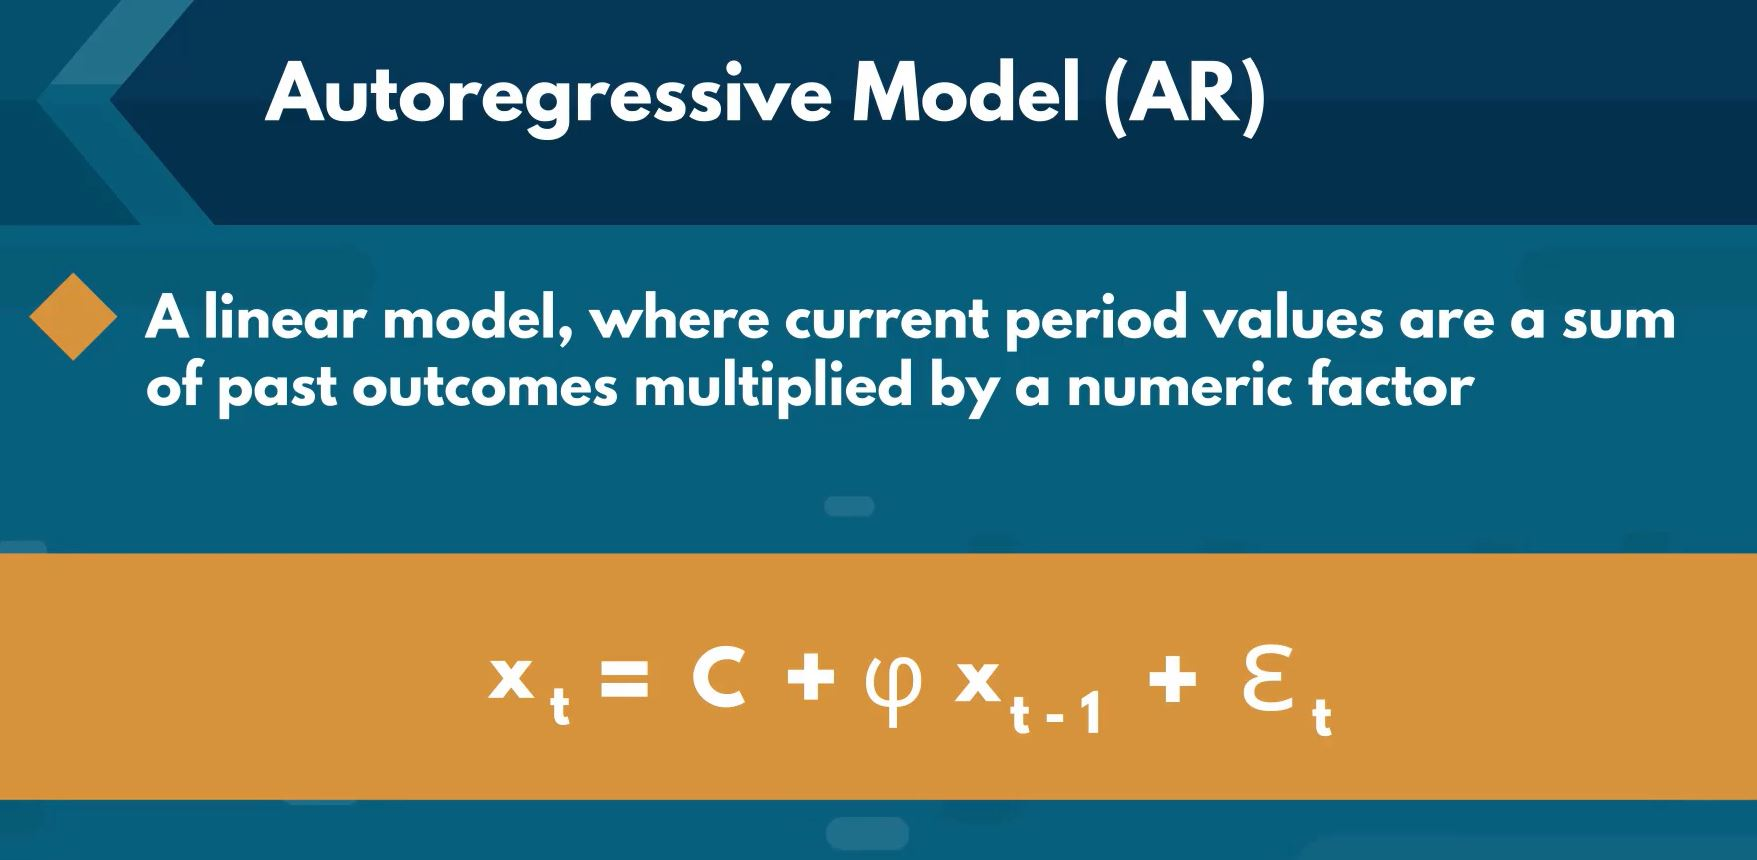

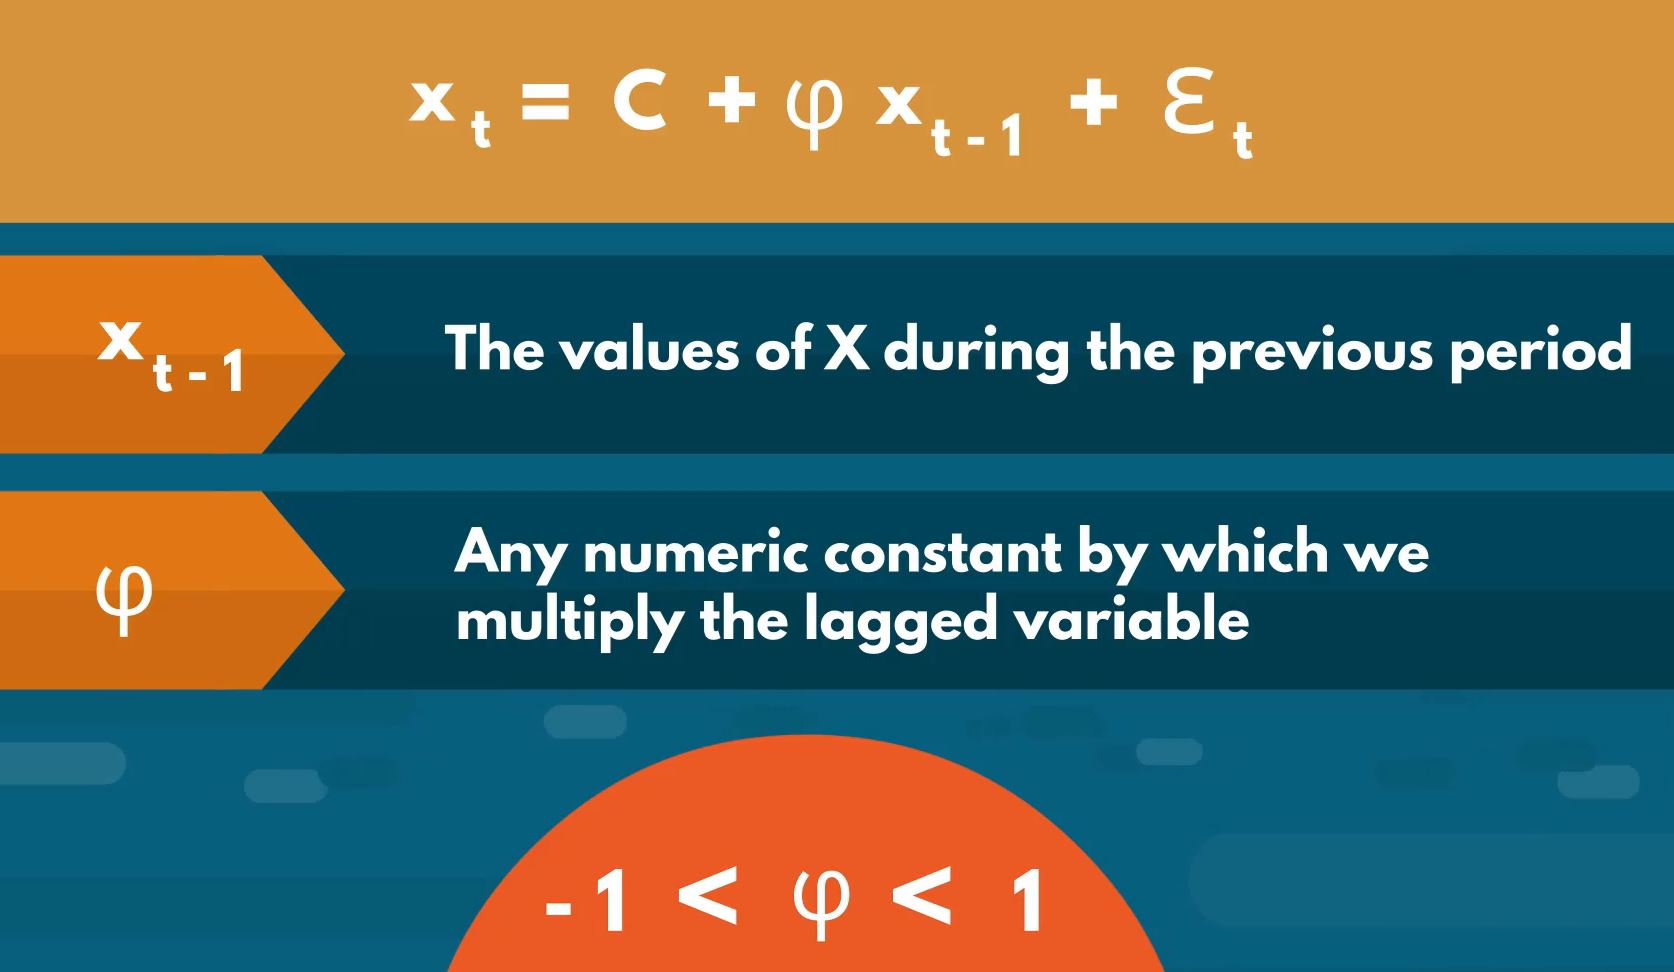

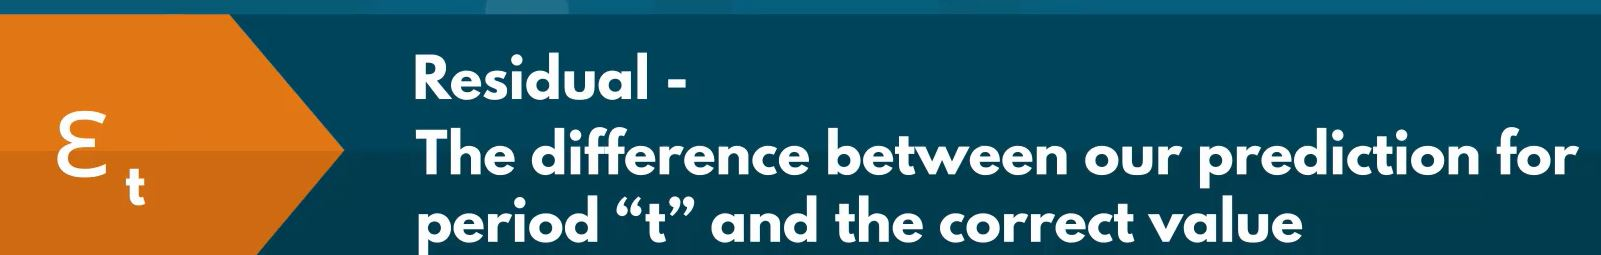

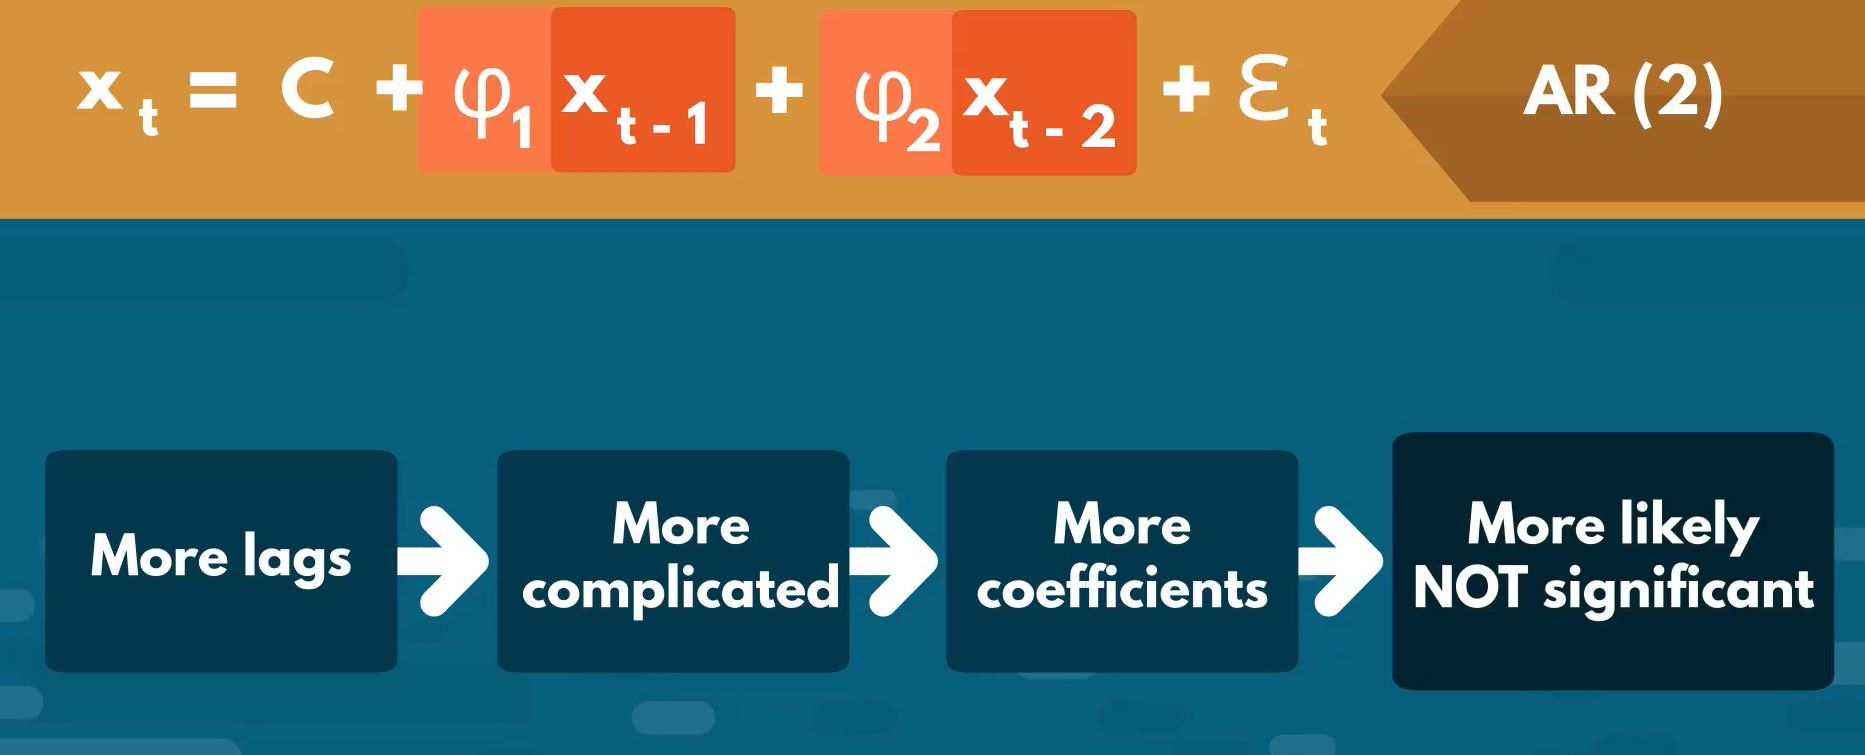

**Examining the ACF & PACF of prices**

We are going to observe the ACF and PACF of prices to determine the number of lags we need to incorporate into an AR model. We are going to work with the FTSE values. 

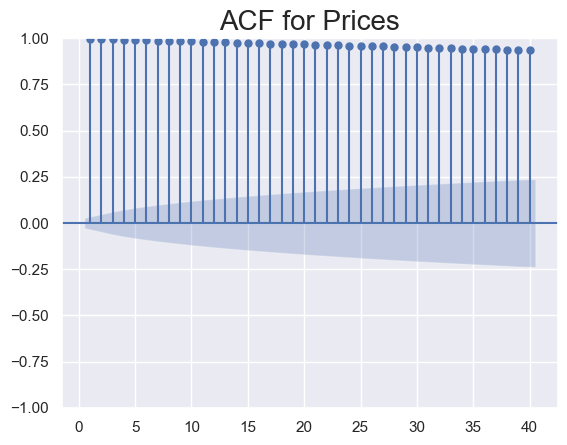

In [47]:
# the ACF
df_comp_2 = raw_csv_file

# the type of the "date" column is an object, it's not saved as a date type variable
# let's convert it to datetype
df_comp_2.date = pd.to_datetime(df_comp_2.date, dayfirst = True)

# set the "date" column as an index
df_comp_2.set_index('date', inplace = True)

# data mesured once per year is "annual" rather than "yearly", so we use "a", instead of "y"
df_comp_2 = df_comp_2.asfreq('d')

# using the value "b" avoids adding many unnecessary time periods
df_comp_2 = df_comp_2.asfreq('b')

# front filling
df_comp_2.spx.fillna(method = 'ffill', inplace = True)

# back filling
df_comp_2.ftse.fillna(method = 'bfill', inplace = True)

# same value: mean
df_comp_2.dax.fillna(value = df_comp_2.dax.mean(), inplace = True)

# back filling
df_comp_2.nikkei.fillna(method = 'bfill', inplace = True)

# create a new column
df_comp_2['market_value'] = df_comp_2.ftse

# split data
size = int(len(df_comp_2) * 0.8)
df_train_2 = df_comp_2.iloc[:size]
df_test_2 = df_comp_2.iloc[size:]

# plot ACF
sgt.plot_acf(df_train_2.market_value, zero = False, lags = 40)
plt.title('ACF for Prices', size = 20)
plt.show()

We see a similar graph as for the S&P where the coefficients are significant and slowly declining. Furthermore, all of them are positive and between 0.9 and 1 which indicates that the effects barely deteriorate over time. These parallels indicate that the two time-series are similar in the way past values affect present ones. Generally we prefer parsimonious models since they make for more reasonable predictors (have fewer lags) and prevent us from overfitting the data. The more lags we include the better our model will fit the dataset we feed it but the risk is the coefficients might predict the dataset too well which makes the model prone to mistakes when trying to forecast future values. The ACF capture both direct and indirect effects a previous value has on the current one. Since we want to get the most efficient model we only wish to include past lags which has a direct significant effect on the present. Hence, we should examine the PACF before constructing with 40 lags coefficients. 

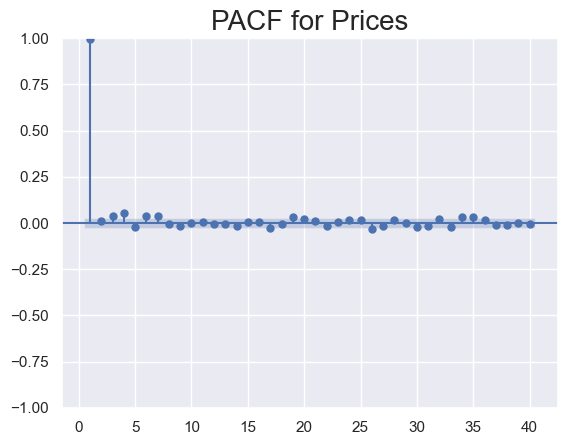

In [48]:
# the PACF
sgt.plot_pacf(df_train_2.market_value, zero = False, alpha = 0.05, lags = 40)
plt.title('PACF for Prices', size = 20)
plt.show()

The coefficients are of different sizes (not all between 0.9 & 1). We have many coefficients that are negative as well as coefficients that are not significant. This is vastly different from the ACF we jut analyzed. We can notice that the coefficients after the 25th lag onwards are not significant, so we can just ignore them. To elaborate, since the coefficient values will be extremely close to 0, their impact on the model is minimal, so they're not relevant to us. Thus, our model must include less than 25 lags. Another observation is that the values after the 22nd lag are negative. The reasonable explanation is that the frequency of the data is in business days and there are roughly 22 business days in a month, so we can anticpate some cyclical changes in a month. In other words, the values a month ago negatively affect the values today. Finally, we're sure that the first value for the first lag is greatly significant, so we must include it in our model. We won't be able to always spot such a convenient pattern in our data, so this short explanation applies to the current dataset. 

**Fitting an AR(1) model for index prices**

We are going to fit our times series into an autoregression model. 

In [49]:
model_ar = ARIMA(df_train_2.market_value, order = (1,0,0))

# the order parameter contains two numbers:
# number 1 specifies the number of past values we wish to incorporate into the model
# number 0 means not taking any of the residual values into consideration
# an order of (1,0) is called a simple AR(1) model

# we need to define the coefficients C and 𝝋 
# fit the model in order to find the most appropariate coefficients
results_ar = model_ar.fit()

# print the summary
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Sun, 11 Dec 2022   AIC                          55251.207
Time:                        15:44:33   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6981    423.327     12.023      0.000    4259.991    5919.405
ar.L1          0.9984      0.001   1147.577      0.000       0.997       1.000
sigma2      3511.3841     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Analysis of the results:**
\begin{gather*}
X_t= C + ϕX_t-1 + 𝜺_t
\end{gather*}

Let's focus on the lower part of the result. 
- The first column contains all the coefficients the model can estimate: "const" and "ar.L1.market_value". The constant coefficient is 5066.7835 which corresponds to C in the equation. The second coefficient is equal to 0.9985 which corresponds to ϕ which is the coefficient for the autoregressive value from one lag ago for the associated time series. 
- The second column contains the standard errors which measure how far away, on average, the model's predictions are from the true values. 
- The third column is the Z column which contains the test-statistics for significance. 
- The fourth column contains the p-values. Since these values are both equal to 0 we can conclude that the constant C and the one lag value ϕ are significantly different from 0. 
- The last two columns represent the critical values for the 95% confidence interval. If 0 is not part of it, we can confirm the coeffcients are significant.

Finally, we have ϕ = 0.9985 which is almost 1. This coincides with what we got from the ACF and PACF graphs. Since both coefficients are significantly different from 0 we can try fitting a more complex model for a better accuracy.

**Fitting higher-lag AR models for prices**

Here, we want to test if a more complicated model would be a better estimator. We are going to fit an autoregressive model for many lags instead of one AR(2), AR(3) ... AR(N). We're to analyze each one individually and then use the Log-Likelihood Ratio test to determine if a more complex model makes better predictions. 

In [50]:
# build an AR(2) model: predict prices today based on prices up to two periods ago
model_ar_2 = ARIMA(df_train_2.market_value, order = (2,0,0))
results_ar_2 = model_ar_2.fit()

# print the summary
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -27621.947
Date:                Sun, 11 Dec 2022   AIC                          55251.894
Time:                        15:44:33   BIC                          55277.980
Sample:                    01-07-1994   HQIC                         55261.035
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    368.244     13.822      0.000    4367.956    5811.447
ar.L1          0.9810      0.010     99.872      0.000       0.962       1.000
ar.L2          0.0172      0.010      1.752      0.080      -0.002       0.036
sigma2      3510.1247     41.037     85.536      0.000    3429.694    3590.555
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3282.87
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Analysis of the results:**  
- There three variables in the first column: "const", "ar.L1.market_value	" and "ar.L2.market_value". 
- We can that the coefficients have changed. That's because some of the changes in yesterday's prices (P_t-1) can be justified by the prices two days ago (P_t-2).
- The first p-value have also changed.  

Now we should check the coefficients for the AR(3) and AR(4) models. Usually the more lags we include the better our predictions become. However, we run the risk of overfitting. Let's compute the summarized tables for AR(3) nf AR(4) models and then introduce the Log-Likelihood test which would tell us if more complicated models are worth using.

In [51]:
# build an AR(3) model: predict prices today based on prices up to three periods ago
model_ar_3 = ARIMA(df_train_2.market_value, order = (3,0,0))
results_ar_3 = model_ar_3.fit()

# print the summary
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27615.741
Date:                Sun, 11 Dec 2022   AIC                          55241.482
Time:                        15:44:34   BIC                          55274.088
Sample:                    01-07-1994   HQIC                         55252.907
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    378.749     13.438      0.000    4347.367    5832.036
ar.L1          0.9802      0.010     99.074      0.000       0.961       1.000
ar.L2         -0.0317      0.013     -2.378      0.017      -0.058      -0.006
ar.L3          0.0498      0.009      5.480      0.000       0.032       0.068
sigma2      3501.9545     41.013     85.387      0.000    3421.571    3582.338
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3288.67
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Analysis:**
- The second and third coefficients are -0.0305 and its p-value are higher than 0.05 (using 5% significance) so it is considered as not significantly greater than 0. 
- The Log-Likelihood has increased from -27589.820 to -27583.782. 
- Usually we prefer models with a higher Log-Likelihood but lower information criterion (AIC, BIC, HQIC). We need to run a Log-Likelihood Ratio (LLR) test to see if the two models are significantly different. 

Moving on, let's fit the AR(4) model.

In [52]:
# build an AR(4) model: predict prices today based on prices up to three periods ago
model_ar_4 = ARIMA(df_train_2.market_value, order = (4,0,0))
results_ar_4 = model_ar_4.fit()

# print the summary
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27603.491
Date:                Sun, 11 Dec 2022   AIC                          55218.983
Time:                        15:44:34   BIC                          55258.111
Sample:                    01-07-1994   HQIC                         55232.694
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    391.575     12.998      0.000    4322.229    5857.174
ar.L1          0.9767      0.010     97.799      0.000       0.957       0.996
ar.L2         -0.0295      0.013     -2.193      0.028      -0.056      -0.003
ar.L3         -0.0187      0.013     -1.487      0.137      -0.043       0.006
ar.L4          0.0699      0.009      7.708      0.000       0.052       0.088
sigma2      3485.1541     41.937     83.105      0.000    3402.959    3567.349
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3050.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**LLR test**

In [53]:
# for convenience I created a function for the Log-Likelihood test so we can reuse it
def LLR_test(mod_1, mod_2, DF = 1):
  # DF stands for degrees of freedom
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  # ".llf" extracts the Log-Likelihood
  LR = (2 * (L2 - L1)) # compute the test statistic
  p = scipy.stats.distributions.chi2.sf(LR, DF).round(3) # use the chi-square method, p is the p_value we want to find
  return p 

In [54]:
# comparing higher lag AR models
LLR_test(model_ar_2, model_ar_3)

0.0

In [55]:
# we see that the Log-Likelihood is significant using 5% significance
# this suggests that we should opt the more complicated model
LLR_test(model_ar_3, model_ar_4)

0.0

In [56]:
# we can continue fitting a more complicated model and check if it gives us distinguishably greater Log-Likelihoods
# moreover the model should also have the last lag not to be significantly different from 0
# this time we print the summary tables along with the LLR test
model_ar_4 = ARIMA(df_train_2.market_value, order = (4,0,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print('\nLLR test p-value:', str(LLR_test(model_ar_3, model_ar_4)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27603.491
Date:                Sun, 11 Dec 2022   AIC                          55218.983
Time:                        15:44:35   BIC                          55258.111
Sample:                    01-07-1994   HQIC                         55232.694
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    391.575     12.998      0.000    4322.229    5857.174
ar.L1          0.9767      0.010     97.799      0.000       0.957       0.996
ar.L2         -0.0295      0.013     -2.193      0.0

In [57]:
model_ar_5 = ARIMA(df_train_2.market_value, order = (5,0,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_4.summary())
print('\nLLR test p-value:', str(LLR_test(model_ar_4, model_ar_5)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27603.491
Date:                Sun, 11 Dec 2022   AIC                          55218.983
Time:                        15:44:36   BIC                          55258.111
Sample:                    01-07-1994   HQIC                         55232.694
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    391.575     12.998      0.000    4322.229    5857.174
ar.L1          0.9767      0.010     97.799      0.000       0.957       0.996
ar.L2         -0.0295      0.013     -2.193      0.0

In [58]:
model_ar_6 = ARIMA(df_train_2.market_value, order = (6,0,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print('\nLLR test p-value:', str(LLR_test(model_ar_5, model_ar_6)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 0)   Log Likelihood              -27597.647
Date:                Sun, 11 Dec 2022   AIC                          55211.293
Time:                        15:44:38   BIC                          55263.464
Sample:                    01-07-1994   HQIC                         55229.574
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    396.929     12.823      0.000    4311.735    5867.668
ar.L1          0.9797      0.010     96.841      0.000       0.960       1.000
ar.L2         -0.0338      0.014     -2.477      0.0

In [59]:
model_ar_7 = ARIMA(df_train_2.market_value, order = (7,0,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print('\nLLR test p-value:', str(LLR_test(model_ar_6, model_ar_7)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -27593.185
Date:                Sun, 11 Dec 2022   AIC                          55204.371
Time:                        15:44:39   BIC                          55263.063
Sample:                    01-07-1994   HQIC                         55224.937
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    405.293     12.558      0.000    4295.341    5884.062
ar.L1          0.9781      0.010     95.711      0.000       0.958       0.998
ar.L2         -0.0311      0.014     -2.230      0.0

In [60]:
model_ar_8 = ARIMA(df_train_2.market_value, order = (8,0,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print('\nLLR test p-value:', str(LLR_test(model_ar_7, model_ar_8)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -27593.040
Date:                Sun, 11 Dec 2022   AIC                          55206.080
Time:                        15:44:40   BIC                          55271.294
Sample:                    01-07-1994   HQIC                         55228.931
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    407.243     12.498      0.000    4291.520    5887.883
ar.L1          0.9785      0.010     95.688      0.000       0.958       0.998
ar.L2         -0.0311      0.014     -2.230      0.0

We stop at model_ar_7 because because the 8th lag is insignificant. The p-value at the 8th lag and the LLR test p-value both indicate that including prices from 8 periods ago does not improve our model in any notable way. 

In [61]:
# let's run the LLR test again to make sure that adding 6 additional lags is worth it
# we put the simplest model first, and pass value 2 to the degrees of freedom (DF) argument  
print('LLR test: ' + str(LLR_test(model_ar, model_ar_7, DF = 2)))

LLR test: 0.0


Not surprisingly, the complex model yields a significantly greater Log-Likelihood using 5% significance. 

**Using returns**

We know that if the data comes from a non-stationary process then the AR family of models will do poorly in finding the true relationship between the data. 
When we conducted the Dickey-Fuller test we concluded that the S&P data is not stationary. Let's conduct the same test on the FTSE data.

In [62]:
# the DF-test
sts.adfuller(df_train_2.market_value)

(-1.9049356385026313,
 0.3297428049318857,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54856.46568853504)

In [63]:
# we see that the p-value is 0.35 so we can't say that the data comes from stationary process assuming a 5% significance level
# that's why we can assume it's extracted from a non-stationary process
# this suggests that we shouldn't rely on AR models to make accurate forecasts
# what we can do is transform the dataset, so that it fits the stationary assumptions
# in finance the common approach is to use returns instead of prices when measuring financial indices
# returns here means the % change between the values for two consecutive periods
# so positive returns r > 0 indicate an increase in the price and negative ones r < 0 showcase a decline
# thus, id investors forecast postive returns in the future they prefer keeping the stocks as the price goes up
# conversely, if the predictions show negative returns then the stock depreciates and they prefer to get rid of it while it is still valuable
# let's see how we create the return out of prices
# to do so we need to take a value of period P_t and substract a value of period P_t-1 from it and divide the result by P_t-1
# finally to get the percentage values we multiply by 100 => ((P_t - P_t-1) / P_t-1) * 100
# we can use the pandas method .pct_change() to calculate the returns
df_train_2['returns'] = df_train_2.market_value.pct_change(1).mul(100) # the value 1 determines the distance in time between the periods we want to compare

# print the few first rows
df_train_2.head()

spx      dax     ftse    nikkei  market_value   returns
date                                                                  
1994-01-07  469.90  2224.95  3445.98  18124.01       3445.98       NaN
1994-01-10  475.27  2225.00  3440.58  18443.44       3440.58 -0.156704
1994-01-11  474.13  2228.10  3413.77  18485.25       3413.77 -0.779229
1994-01-12  474.17  2182.06  3372.02  18793.88       3372.02 -1.222988
1994-01-13  472.47  2142.37  3360.01  18577.26       3360.01 -0.356166

In [64]:
# the first value is not calculated because there is no previous value when calculating the % change
# let's get rid of it
df_train_2 = df_train_2.iloc[1:]

# print the few first rows
df_train_2.head()

spx      dax     ftse    nikkei  market_value   returns
date                                                                  
1994-01-10  475.27  2225.00  3440.58  18443.44       3440.58 -0.156704
1994-01-11  474.13  2228.10  3413.77  18485.25       3413.77 -0.779229
1994-01-12  474.17  2182.06  3372.02  18793.88       3372.02 -1.222988
1994-01-13  472.47  2142.37  3360.01  18577.26       3360.01 -0.356166
1994-01-14  474.91  2151.05  3400.56  18973.70       3400.56  1.206842

In [65]:
# to make sure the returns don't come from a stationary process let's conduct the Dickey-Fuller test
sts.adfuller(df_train_2.returns)

(-12.786930957227275,
 7.213255047804608e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15700.846444346233)

In [66]:
# the t statistic (-12.78) is way lower than any p-value (1%, 5%, 10% significance level)
# thus, we can confidently state that the data comes from a stationary process

**Examining the ACF and PACF of returns**

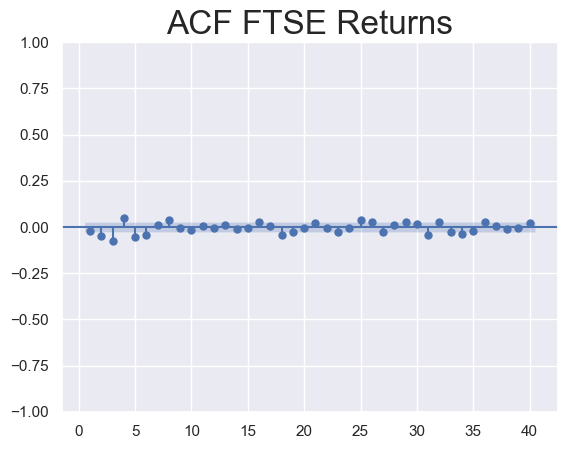

In [67]:
# plot the ACF
sgt.plot_acf(df_train_2.returns, lags = 40, zero = False)
plt.title('ACF FTSE Returns', size = 24)
plt.show()

- The plot greatly differs from what we saw in prices.
- Not all coefficients are positive or significant.
- Values greatly vary in magnitude instead of all being close to 1.
- the first several lags are of great importance since they are significant but their coeffcients are negative with the exception of the 4th lag.
- That points to a trend where consecutive values move in different directions. This suggests that returns of the entire week are relevant to those of the current one (here a business week has only 5 days). 
- Since the relationship is negative we can assume that some form of natural adjustment occuring in the market. 

Before making any decisions on what model we want to implement, let's first look at the PACF.

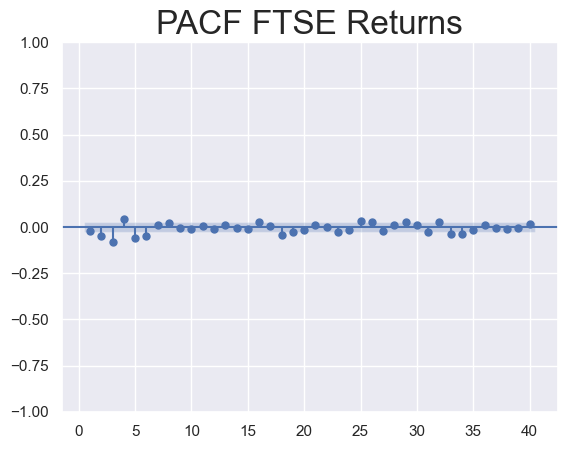

In [68]:
# plot the PACF
sgt.plot_pacf(df_train_2.returns, lags = 40, zero = False, method = ('ols'))
plt.title('PACF FTSE Returns', size = 24)
plt.show()

- The results seem to be similar with what we got in the ACF.
- One way to interpret this is that the prices today often move in the opposite direction of prices yesterday. Hence, we tend to have price increases following price decreases which falls in line with our expectation of cyclical changes. 
- Intuition dictates that the further back we go the less relevant the coefficient values should be. That's because the majority of effects they have on current values should already be accounted for due to the recursive nature of autoregressive models. 

Next we will use an AR(1) model to see how it performs on returns.

**Fitting an AR(1) model for returns**

In [69]:
# first we define the model specifications, then we fit the data
model_ret_ar_1 = ARIMA(df_train_2.returns, order = (1,0,0))
results_ret_ar_1 = model_ret_ar_1.fit()

# print the summary table
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.756
Date:                Sun, 11 Dec 2022   AIC                          15865.512
Time:                        15:44:43   BIC                          15885.076
Sample:                    01-10-1994   HQIC                         15872.368
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.690      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.098      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7873.47
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Both p-values are over 0.05. This means that neither is significantly different from 0. This model holds no predictive power. This can be explained by the impact past values can have on yesterday's prices. The more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes. This is because of the accumulated compound effects of lag coefficients. This directly decreases the predictive power of the model. therefore, we should test if a higher-lag model serves as a better predictor for returns. 

**Fitting higher-lag AR models for returns**

In [70]:
# we're going to begin by fitting an AR(2) model
model_ret_ar_2 = ARIMA(df_train_2.returns, order = (2,0,0))
results_ret_ar_2 = model_ret_ar_2.fit()

# print the summary table
print(results_ret_ar_2.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_1, model_ret_ar_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.305
Date:                Sun, 11 Dec 2022   AIC                          15854.609
Time:                        15:44:44   BIC                          15880.694
Sample:                    01-10-1994   HQIC                         15863.749
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.232      -0.012       0.050
ar.L1         -0.0241      0.009     -2.794      0.005      -0.041      -0.007
ar.L2         -0.0507      0.008     -6.451      0.0

We can see immediately that the p-value for the second lag is zero. This means that ϕ2 is significantly different from 0 and should be included in the model. Also the p-value for the first period has decreased further. We can suppose that if we add more lags it will actually become significant. The LLR test shows a p-value of less than 1% which indicates that the current model is better fit than the previous one AR(2) > AR(1). Also we notice that the information criterion (AIC, BIC, HQIC) are lower than the previous model. 

In [71]:
# fitting an AR(3) model
model_ret_ar_3 = ARIMA(df_train_2.returns, order = (3,0,0))
results_ret_ar_3 = model_ret_ar_3.fit()

# print the summary table
print(results_ret_ar_3.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_2, model_ret_ar_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7907.795
Date:                Sun, 11 Dec 2022   AIC                          15825.590
Time:                        15:44:44   BIC                          15858.196
Sample:                    01-10-1994   HQIC                         15837.016
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.269      0.205      -0.010       0.048
ar.L1         -0.0281      0.009     -3.184      0.001      -0.045      -0.011
ar.L2         -0.0526      0.008     -6.751      0.0

The p-values show that all coeffcients related to past values are significant using a 5% significance level with the exception of the constant which is not related to past values. Since the p-value of the third lag is 0 yet again, we expect the LLR test to suggest that this model is better than the previous one. This is confirmed by the LLR test so the two Log-Likelihoods are different. The information criterion are lower once again, so we can confidently assume that this model outperforms its counterpart. We need to continue testing other models until the additional coeffcient is insignificant, the LLR test fails and get higher AIC or BIC values. 

In [72]:
# fitting an AR(4) model
model_ret_ar_4 = ARIMA(df_train_2.returns, order = (4,0,0))
results_ret_ar_4 = model_ret_ar_4.fit()

# print the summary table
print(results_ret_ar_4.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_3, model_ret_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7902.910
Date:                Sun, 11 Dec 2022   AIC                          15817.821
Time:                        15:44:45   BIC                          15856.948
Sample:                    01-10-1994   HQIC                         15831.531
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0247      0.009     -2.790      0.005      -0.042      -0.007
ar.L2         -0.0503      0.008     -6.408      0.0

In [73]:
# fitting an AR(5) model
model_ret_ar_5 = ARIMA(df_train_2.returns, order = (5,0,0))
results_ret_ar_5 = model_ret_ar_5.fit()

# print the summary table
print(results_ret_ar_5.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_4, model_ret_ar_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7894.032
Date:                Sun, 11 Dec 2022   AIC                          15802.064
Time:                        15:44:47   BIC                          15847.712
Sample:                    01-10-1994   HQIC                         15818.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0221      0.009     -2.431      0.015      -0.040      -0.004
ar.L2         -0.0549      0.008     -6.882      0.0

In [74]:
# fitting an AR(6) model
model_ret_ar_6 = ARIMA(df_train_2.returns, order = (6,0,0))
results_ret_ar_6 = model_ret_ar_6.fit()

# print the summary table
print(results_ret_ar_6.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_5, model_ret_ar_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7888.633
Date:                Sun, 11 Dec 2022   AIC                          15793.265
Time:                        15:44:48   BIC                          15845.435
Sample:                    01-10-1994   HQIC                         15811.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.323      0.186      -0.009       0.047
ar.L1         -0.0248      0.009     -2.672      0.008      -0.043      -0.007
ar.L2         -0.0529      0.008     -6.575      0.0

In [75]:
# fitting an AR(7) model
model_ret_ar_7 = ARIMA(df_train_2.returns, order = (7,0,0))
results_ret_ar_7 = model_ret_ar_7.fit()

# print the summary table
print(results_ret_ar_7.summary())

# run the LLR-test
print('\nLLR_test: ', str(LLR_test(model_ret_ar_6, model_ret_ar_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7888.363
Date:                Sun, 11 Dec 2022   AIC                          15794.726
Time:                        15:44:50   BIC                          15853.416
Sample:                    01-10-1994   HQIC                         15815.292
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.304      0.192      -0.010       0.047
ar.L1         -0.0243      0.009     -2.613      0.009      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.449      0.0

The AR(7) shows a high p-value at the 7th lag and the LLR test fails. In addition, the information criteria are higher than in the previous model. Therefore, we opt for the simpler model behind it. 

**Normalizing values**

In the case of time series when we normalize a set of values, we basically map a sample of the sample space to the percentage of the first value of the set. The resulting series is easier to compare with the resulting series. In genenral when we normalize two time series we can compare how they perform relative to one another. This gives an idea in which one we can invest in and which one to avoid. 

In [76]:
# to normalize our values we need to set a benchmark first
benchmark = df_train_2.market_value.iloc[0]

# divide every value by the benchmark and multiply by 100
df_train_2['norm'] = df_train_2.market_value.div(benchmark).mul(100)

# AR models work best with stationary data so we need to run the augmented Dickey-Fuller test before we are certain the values are useful
sts.adfuller(df_train_2.norm)

(-1.8936568624122199,
 0.33505098158646573,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19556.212836830156)

We can see that the test yields a high p-value which suggests non-stationarity. Thus, normalizing the values didn't result in stationary data. Therefore, we will not be able to use an AR model with the normalized prices. However, normalization is still a good practice to comparing a time series. Let's normalize the return instead. 

In [77]:
# set a benchmark first
bench_ret = df_train_2.returns.iloc[0]

# divide every value by the benchmark and multiply by 100
df_train_2['norm_ret'] = df_train_2.returns.div(bench_ret).mul(100)

# AR models work best with stationary data so we need to run the augmented Dickey-Fuller test before we are certain the values are useful
# we suspect the Dickey-Fuller test test will suggest stationarity
sts.adfuller(df_train_2.norm_ret)

(-12.786930957227376,
 7.213255047801193e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80118.5703598977)

The test statistic (-12.78) is lower than any critical value(at 1%, 5% and 10% significance level). So we can say confidently that the data is stationary. Furthermore, we can conclude normalizing does not include stationarity. 

**Model selection for normalized returns (AR model)**

We already saw how to fit different lagged models for prices and non-normalized returns. We're going to do the same for the normalized returns. 

In [78]:
# fit an AR(1) model
model_norm_ret_ar_1 = ARIMA(df_train_2.norm_ret, order = (1,0,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()

# print the summary table
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -40351.751
Date:                Sun, 11 Dec 2022   AIC                          80709.501
Time:                        15:44:52   BIC                          80729.065
Sample:                    01-10-1994   HQIC                         80716.357
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.476     -1.143      0.253     -32.506       8.560
ar.L1         -0.0230      0.009     -2.690      0.007      -0.040      -0.006
sigma2      5.617e+05   5612.608    100.077      0.000    5.51e+05    5.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7873.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
# fit an AR(2) model
model_norm_ret_ar_2 = ARIMA(df_train_2.norm_ret, order = (2,0,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()

# print the summary table
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -40345.299
Date:                Sun, 11 Dec 2022   AIC                          80698.598
Time:                        15:44:52   BIC                          80724.683
Sample:                    01-10-1994   HQIC                         80707.739
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.044     -1.192      0.233     -31.658       7.712
ar.L1         -0.0241      0.009     -2.791      0.005      -0.041      -0.007
ar.L2         -0.0507      0.008     -6.448      0.000      -0.066      -0.035
sigma2      5.603e+05   5626.818     99.579      0.000    5.49e+05    5.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7732.58
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
# after running the AR(1) and AR(2) models we can notice the same values for "ar.L1.norm_ret" & "ar.L2.norm_ret" before normalizing the values except for the "constant" values
# therefore, we can suspect the same model that failed for regular returns would also fail for normalized returns
# let's check the AR(7)
model_norm_ret_ar_7 = ARIMA(df_train_2.returns, order = (7,0,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()

# print the summary table
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7888.363
Date:                Sun, 11 Dec 2022   AIC                          15794.726
Time:                        15:44:53   BIC                          15853.416
Sample:                    01-10-1994   HQIC                         15815.292
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.304      0.192      -0.010       0.047
ar.L1         -0.0243      0.009     -2.613      0.009      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.449      0.000      -0.068      -0.036
ar.L3         -0.0843      0.008    -10.338      0.000      -0.100      -0.068
ar.L4          0.0409      0.008      4.902      0.000       0.025       0.057
ar.L5         -0.0599      0.008     -7.437      0.000      -0.076      -0.044
ar.L6         -0.0461      0.009     -5.156      0.000      -0.064      -0.029
ar.L7          0.0104      0.009      1.148      0.251      -0.007       0.028
sigma2         1.3565      0.015     91.804      0.000       1.327       1.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6475.29
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
# we see tha exact same pattern as before So we should stick with the AR(6) model
# this means using normalized values has no impact on model selection

**Examining the AR model residuals**

We will now extract the residuals for all models we think are good fits. Then we examine a summary of their statistics before testing them for stationarity. Ideally the residuals should follow a random walk process so they should be stationary. Finally, we run a Dickey-Fuller test before plotting the values. 

In [82]:
# extract the residuals
# previously we saw that the AR(7) model was the best fit for prices
df_train_2['res_price'] = results_ar_7.resid

# now we calculate the mean and the variance of the data to find the expected value and the variance of the residuals
print('Mean:', df_train_2.res_price.mean())
print('Variance:', df_train_2.res_price.var())

Mean: 0.6792598488805692
Variance: 3469.6127606880764


In [83]:
# the mean is not so close to 0 which means our model performs below average
# the high variance suggests that the residuals are not concentrated around the mean of 0 but are all over the place
# this is primarly the AR models perform poorly when predicting non-stationary data
# now we run the Dickey-Fuller test to see if the times series is stationary
sts.adfuller(df_train_2.res_price)

(-70.8008802272837,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 54834.47610514774)

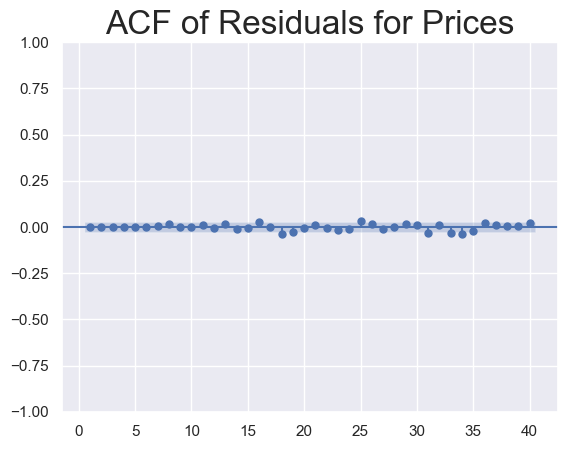

In [84]:
# the p-value is equal to 0, so this suggests that data is stationary
# so the error terms (residuals) fit our expectation so far 
# to make sure the errors of our predictions are random we should examine the ACF of the residual values
sgt.plot_acf(df_train_2.res_price, zero = False, lags = 40)
plt.title('ACF of Residuals for Prices', size = 24)
plt.show()

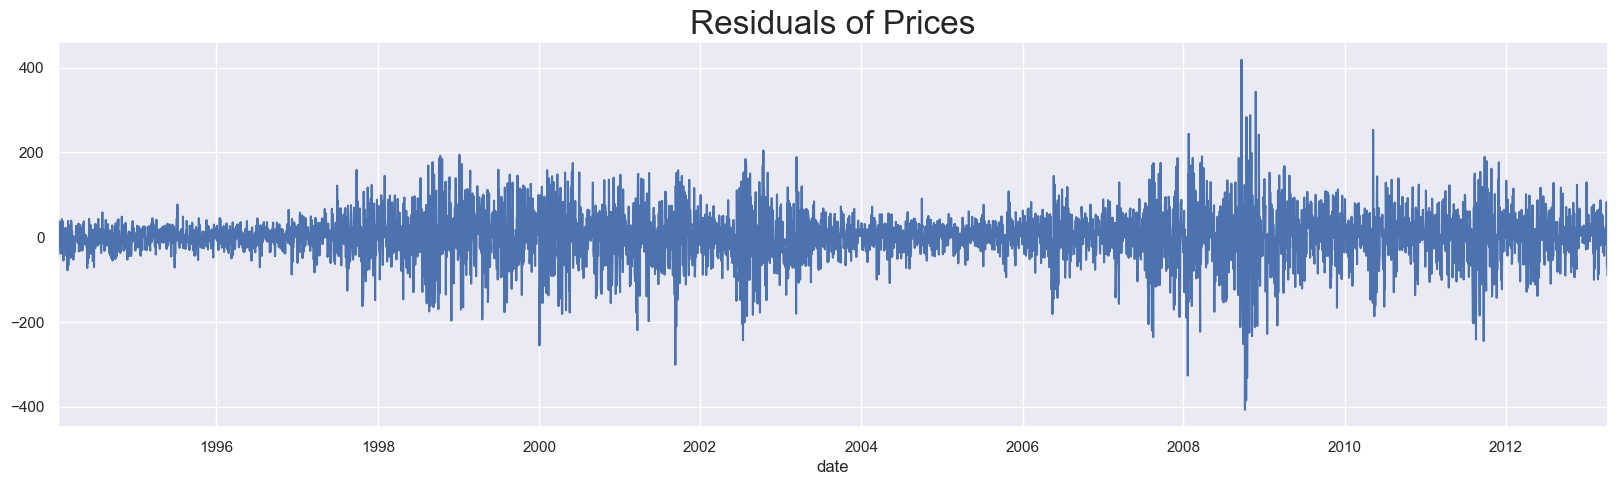

In [85]:
# we can see that the majority of the coefficients fall in the blue region
# this suggests they are significantly different from zero which fits the characteristics of white noise
# the few points outside the blue area suggests that there may an even better predictor
# next we must plot the residuals to see if that ressembles to what we expect from white noise data
df_train_2.res_price[1:].plot(figsize = (20,5))
plt.title('Residuals of Prices', size = 24)
plt.show()

In [86]:
# th graph looks nothing like the original ones for prices
# we cannot find any obvious pattern for the data so our choice of model seems correct
# now we're going to extract the residuals for returns
# previously we saw that AR(6) was better fit for returns
df_train_2['res_ret'] = results_ret_ar_6.resid

# calculate the mean and the variance one again
print('Mean:', df_train_2.res_ret.mean())
print('Variance:', df_train_2.res_ret.var())

Mean: -4.825356471401526e-05
Variance: 1.3568925966655767


In [87]:
# we have a mean close to zero and a variance around which indicates our choice of model was good
# run the Dickey-Fuller test
sts.adfuller(df_train_2.res_ret)

(-70.78594469139082,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15695.929509316968)

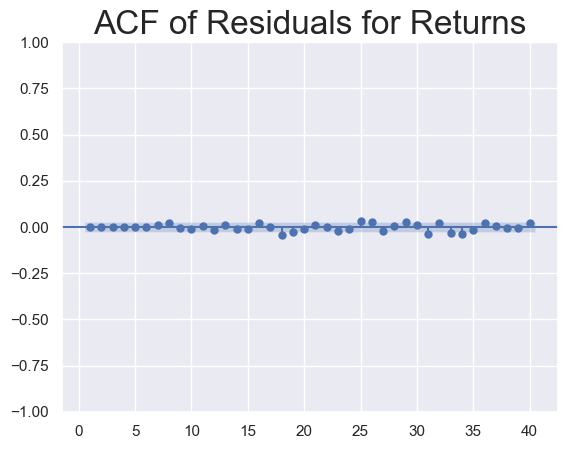

In [88]:
# this test returns values close to those of the price residuals so we have confirmation that the data is stationary
# since white noise is stationary this is axactly what we wanted
# next step is to plot the ACF and examine the coefficients
sgt.plot_acf(df_train_2.res_ret, zero = False, lags = 40)
plt.title('ACF of Residuals for Returns', size = 24)
plt.show()

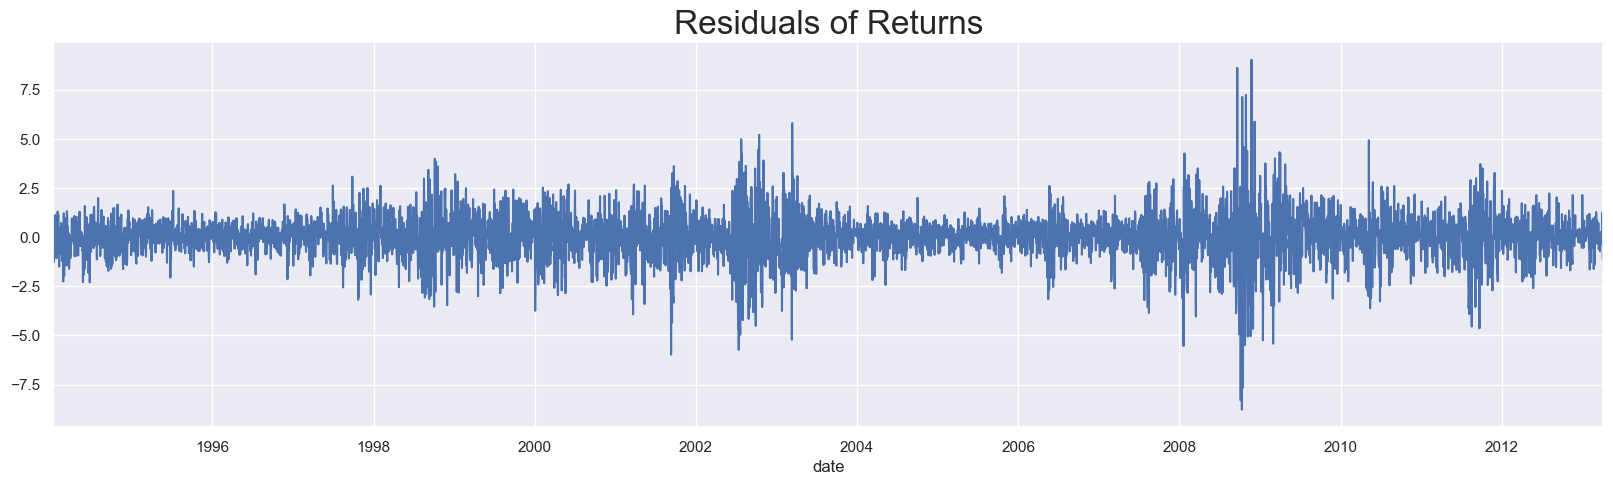

In [89]:
# we can observe similar scenario where most but not all coefficients are not significant
# hence, our model is a good predictor
# finally we plot the data
df_train_2.res_ret[1:].plot(figsize = (20,5))
plt.title('Residuals of Returns', size = 24)
plt.show()

In [90]:
# simiar to the residuals of prices the values are low except for those around 2008
# this coincides with the great recession 
# however, analysts have adapted to account for such unpredictable events
# we are going to expand our modeling with this idea (accounting for unexpected shocks)

### **The MA (Moving Average) Model**

The moving average model (MA) follows the below equation:

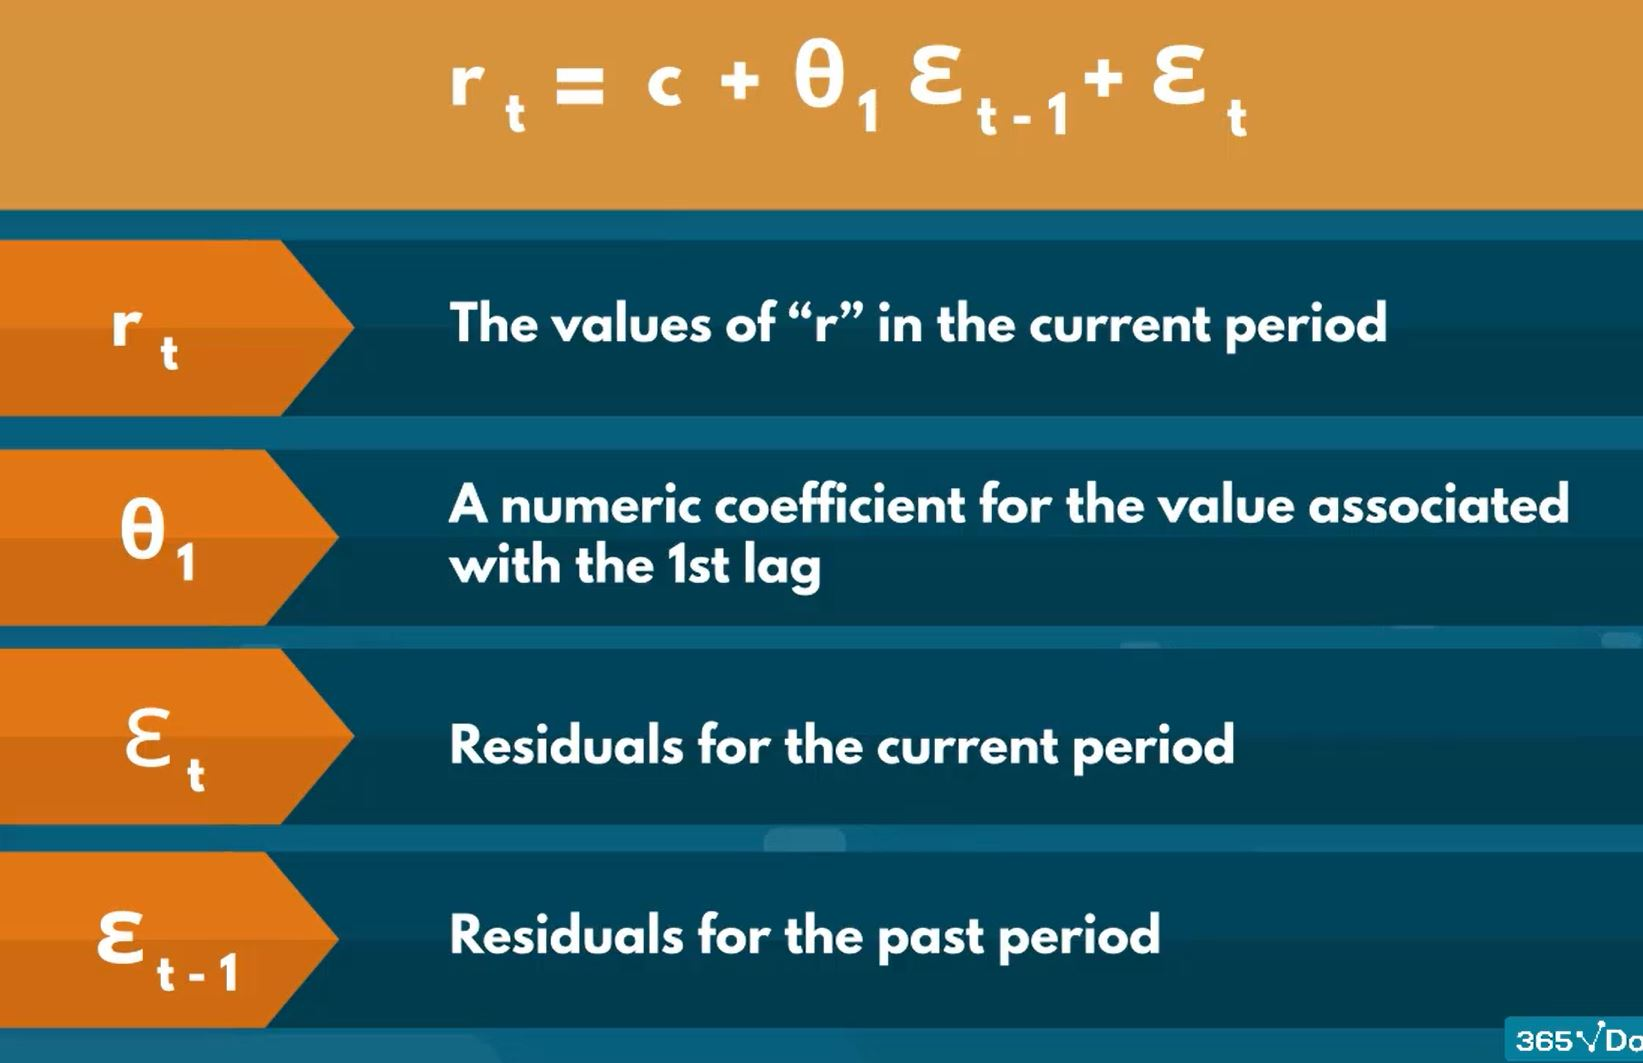

How to generate the residuals at t+1:

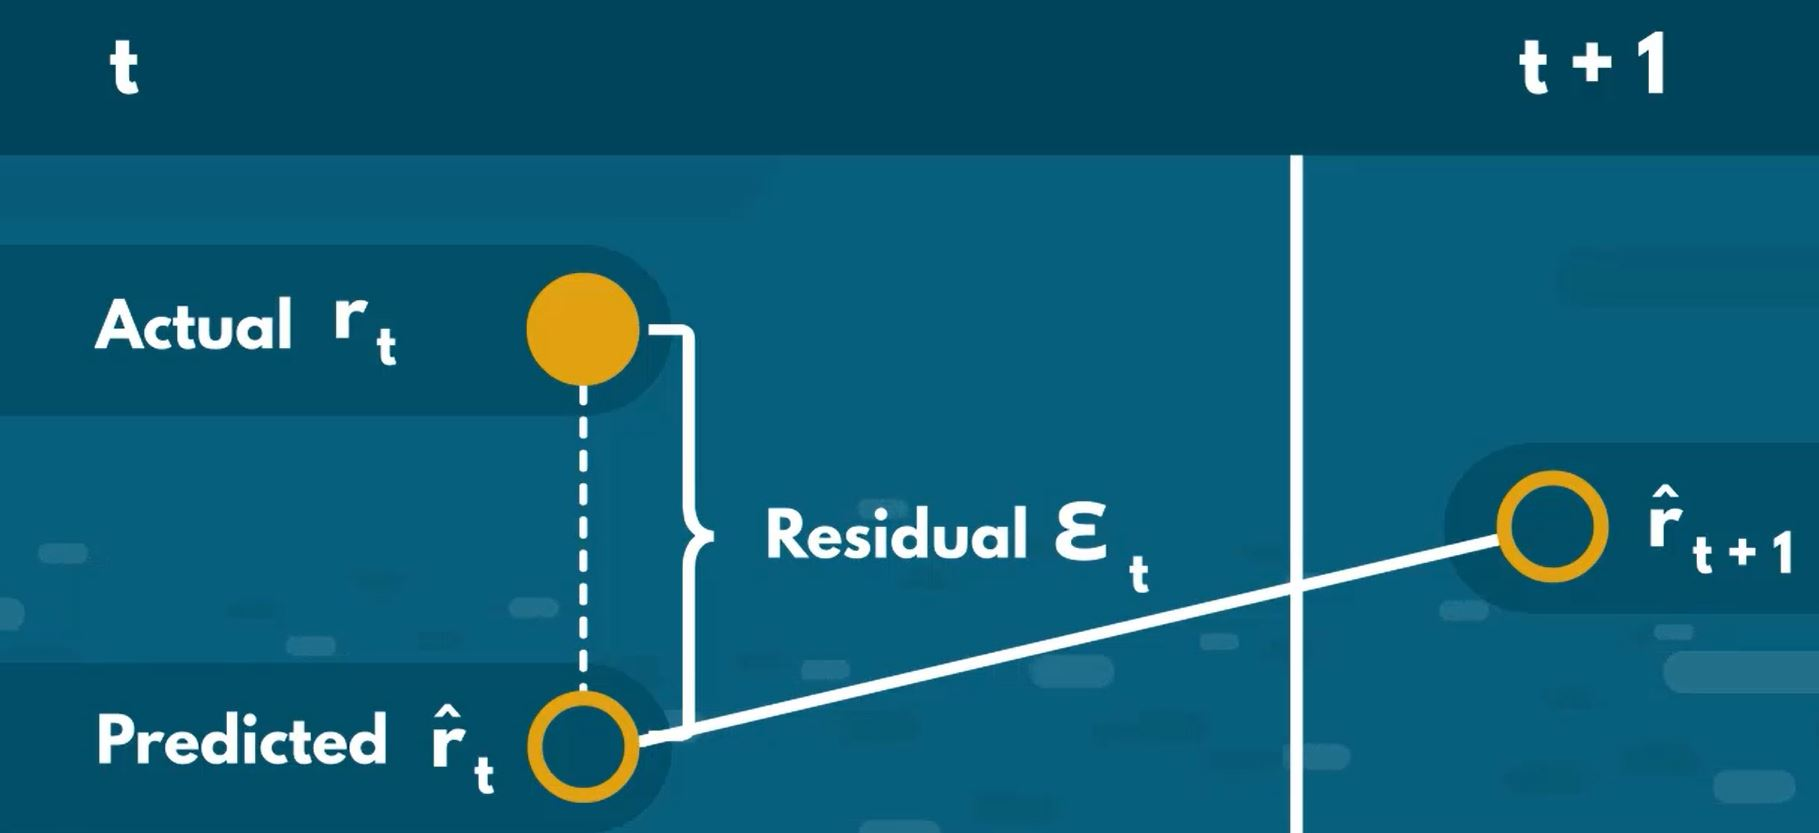


When compraring the equations of AR and MA models, we clearly see that the AR models uses the value of the variable while the MA model uses the residual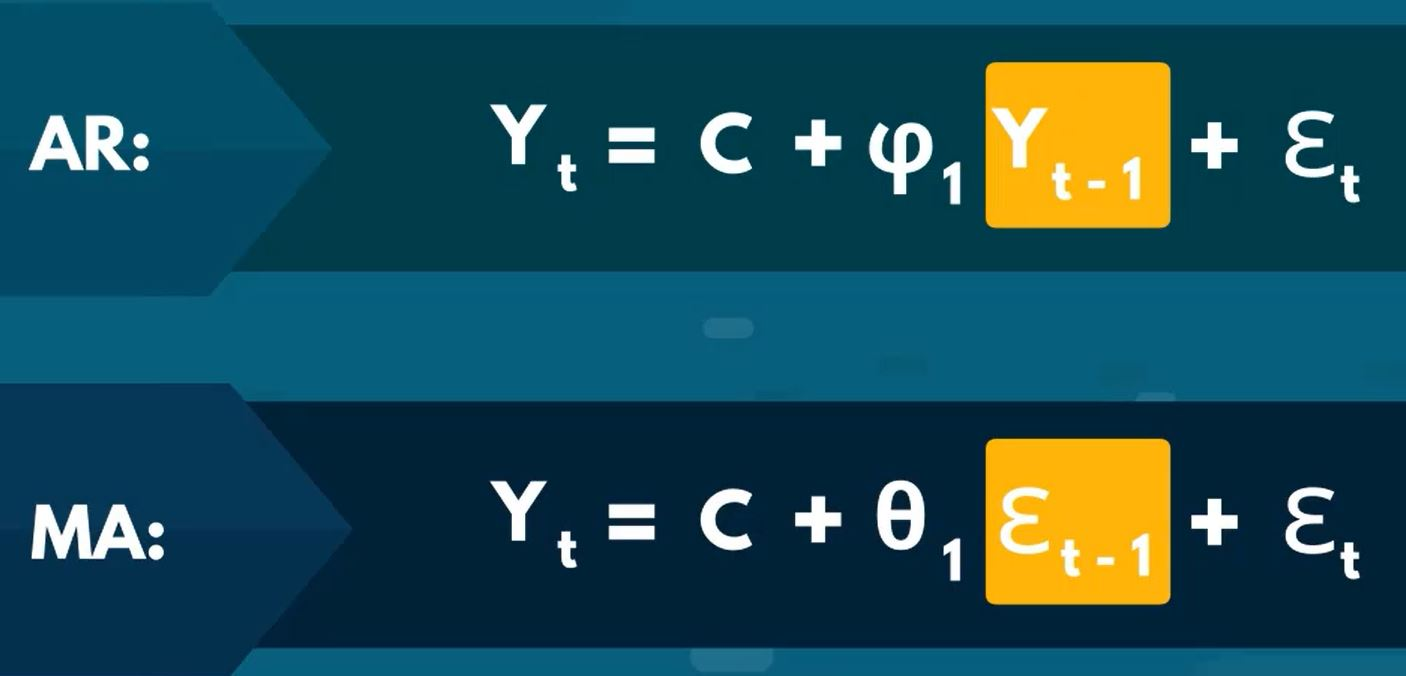

One more common trait between the AR and MA models is the absolute value of each coefficient should be less than one. This is to prevent compound effects exploding in magnitude as we explained earlier. 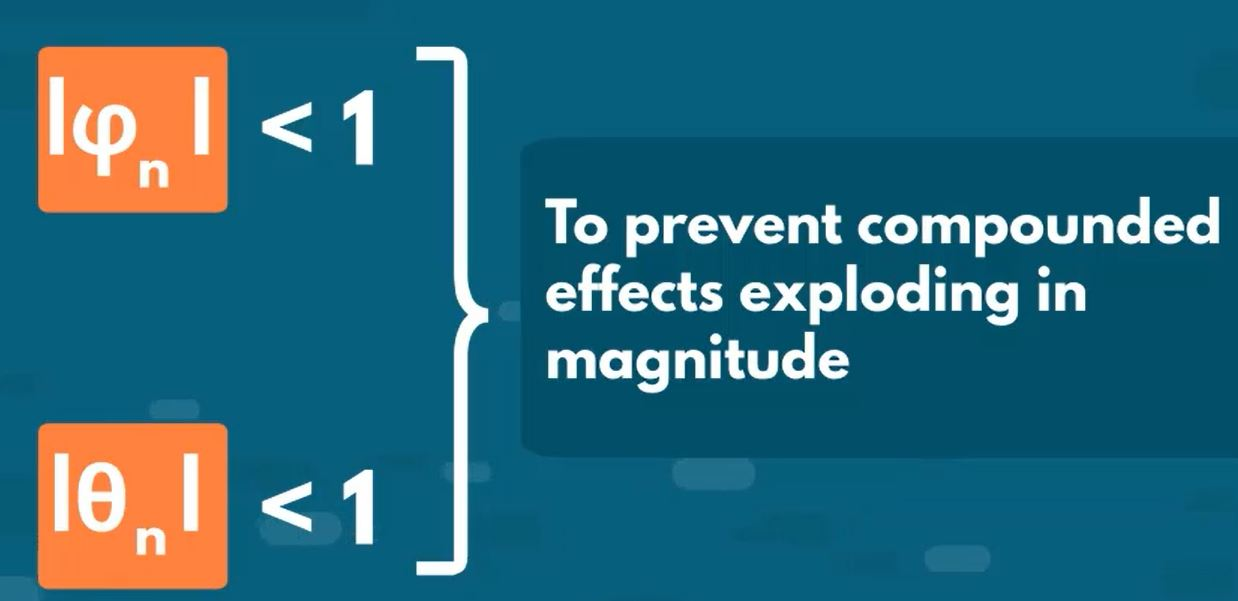

The two types of models also have several key differences. One such distinction between them comes in the form of determining the maximum amount of lags we are willing to include in our model while with the autoregressive model we relied on the PACF. With moving averages (MA) we rely on the ACF. the reason is the MA models aren't based on past period returns. Therefore, determining which lagged values have a significant direct effect on the present day ones is not relevant.
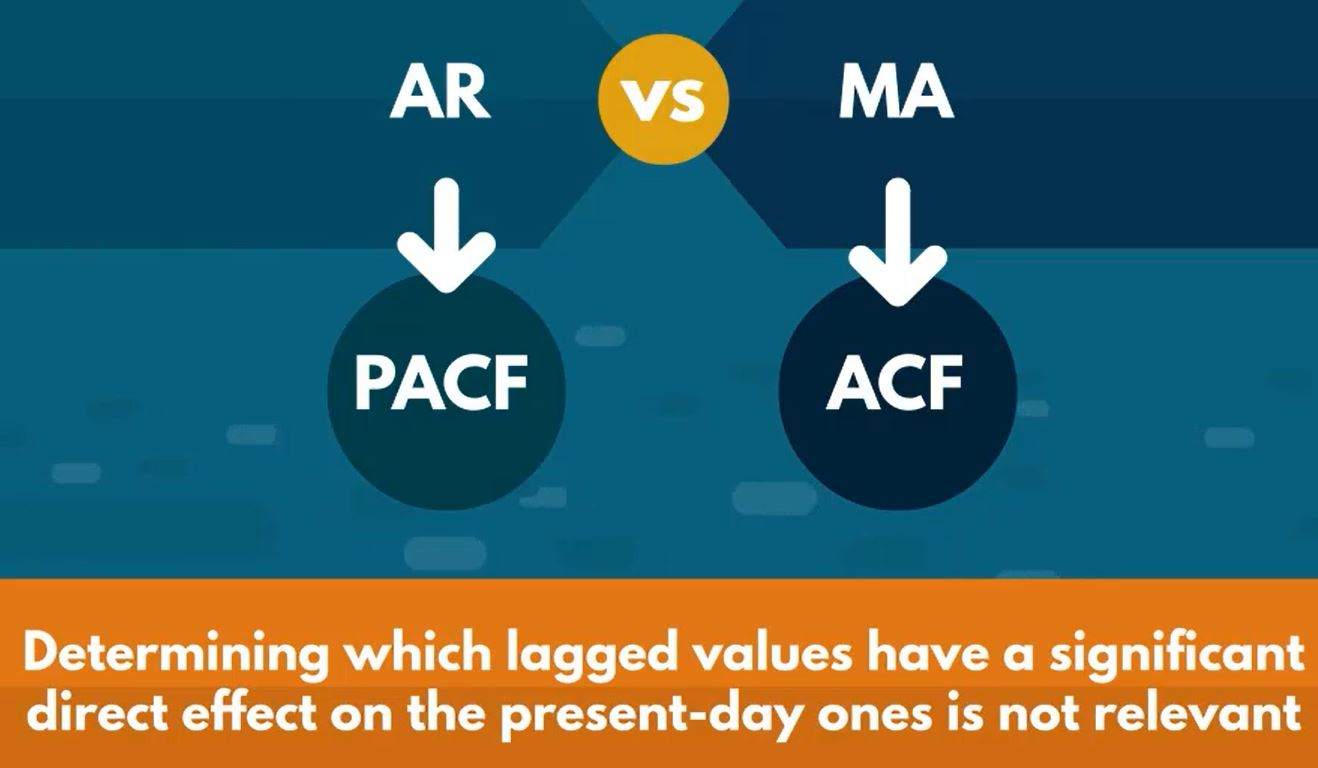

**Fitting an MA(1) model for returns**

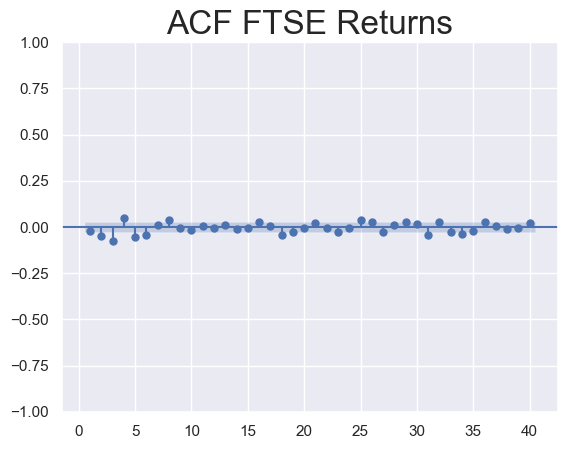

In [91]:
# ACF for returns
sgt.plot_acf(df_train_2.returns[1:], lags = 40, zero = False)
plt.title('ACF FTSE Returns', size = 24)
plt.show()

In [92]:
# we're going to fit a time-series into a simple MA model
# after the ACF plot for returns the number of lags we are going to look at is 8
model_ret_ma_1 = ARIMA(df_train_2.returns.iloc[1:], order = (0,0,1))
# the order method for ARMA has two arguments: P & Q | the P defines the AR components while the Q defines the MA components, here P = 0 & Q = 1

# fit the model
results_ret_ma_1 = model_ret_ma_1.fit()

# print the summary table
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7928.508
Date:                Sun, 11 Dec 2022   AIC                          15863.015
Time:                        15:44:54   BIC                          15882.578
Sample:                    01-11-1994   HQIC                         15869.871
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.148      0.251      -0.013       0.051
ma.L1         -0.0257      0.009     -3.017      0.003      -0.042      -0.009
sigma2         1.3792      0.014     99.972      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7847.35
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
# we can see that the coefficient at the one lag ago residual is significant at the 10% significance level but not the at 5% significance level (p-value = 0.086)
# this is not a surprise since the first coefficient of the ACF was also not significantly different from zero
# however, all the coefficients from up to 6 lags ago fall outside the blue area which suggests significance

**Fitting higher-lags MA models for returns**

Here, we will fit a higher-lag MA(2) model. Then we will analyze its coefficients and log-likelihood. We'll then repeat the same process several times until the model that fits the best. 

In [94]:
# fit an MA of order 2
model_ret_ma_2 = ARIMA(df_train_2.returns[1:], order = (0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()

# print the summary table
print(results_ret_ma_2.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7921.627
Date:                Sun, 11 Dec 2022   AIC                          15851.254
Time:                        15:44:55   BIC                          15877.338
Sample:                    01-11-1994   HQIC                         15860.394
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.016      1.208      0.227      -0.012       0.049
ma.L1         -0.0325      0.009     -3.736      0.000      -0.049      -0.015
ma.L2         -0.0508      0.008     -6.498      0.0

In [95]:
# the p-value for the error term two periods ago is significant
# the p-value for the error term one period ago is also significant
# let's recall that the coefficient in the model MA(1) was not significant, so we went from a model where no coefficient was significant to a model where all coeffcients are siginificant
# this exactly what we aim for when fitting a more complex model, here MA(2) model is a better fit than MA(1) model
# the LLR test yields a p-value of 0 which means that this model makes significantly better predictions

# fit an MA of order 3
model_ret_ma_3 = ARIMA(df_train_2.returns[1:], order = (0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()

# print the summary table
print(results_ret_ma_3.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.360
Date:                Sun, 11 Dec 2022   AIC                          15818.721
Time:                        15:44:56   BIC                          15851.326
Sample:                    01-11-1994   HQIC                         15830.146
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.295      0.195      -0.010       0.048
ma.L1         -0.0209      0.009     -2.402      0.016      -0.038      -0.004
ma.L2         -0.0561      0.008     -7.089      0.0

In [96]:
# the new coefficient has a p-value of 0 which makes it significant
# the ACF predicted that the first value is not significant so we can suggest the first value is not significant from one period ago for the error term
# the LLR test yields a p-value of 0 which means that this model makes significantly better predictions than the simpler MA(2) model
# we can continue this process until we find a model that does not make better predictions

# fit an MA of order 4
model_ret_ma_4 = ARIMA(df_train_2.returns[1:], order = (0,0,4))
results_ret_ma_4 = model_ret_ma_4.fit()

# print the summary table
print(results_ret_ma_4.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7899.381
Date:                Sun, 11 Dec 2022   AIC                          15810.763
Time:                        15:44:57   BIC                          15849.889
Sample:                    01-11-1994   HQIC                         15824.473
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.239      0.215      -0.011       0.049
ma.L1         -0.0208      0.009     -2.293      0.022      -0.039      -0.003
ma.L2         -0.0556      0.008     -6.903      0.0

In [97]:
# fit an MA of order 5
model_ret_ma_5 = ARIMA(df_train_2.returns[1:], order = (0,0,5))
results_ret_ma_5 = model_ret_ma_5.fit()

# print the summary table
print(results_ret_ma_5.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7893.451
Date:                Sun, 11 Dec 2022   AIC                          15800.901
Time:                        15:44:59   BIC                          15846.548
Sample:                    01-11-1994   HQIC                         15816.897
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.285      0.199      -0.010       0.048
ma.L1         -0.0266      0.009     -2.877      0.004      -0.045      -0.008
ma.L2         -0.0504      0.008     -6.233      0.0

In [98]:
# fit an MA of order 6
model_ret_ma_6 = ARIMA(df_train_2.returns[1:], order = (0,0,6))
results_ret_ma_6 = model_ret_ma_6.fit()

# print the summary table
print(results_ret_ma_6.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.872
Date:                Sun, 11 Dec 2022   AIC                          15795.743
Time:                        15:45:01   BIC                          15847.911
Sample:                    01-11-1994   HQIC                         15814.024
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.014      1.320      0.187      -0.009       0.047
ma.L1         -0.0240      0.009     -2.599      0.009      -0.042      -0.006
ma.L2         -0.0491      0.008     -6.048      0.0

In [99]:
# fit an MA of order 7
model_ret_ma_7 = ARIMA(df_train_2.returns[1:], order = (0,0,7))
results_ret_ma_7 = model_ret_ma_7.fit()

# print the summary table
print(results_ret_ma_7.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.687
Date:                Sun, 11 Dec 2022   AIC                          15797.373
Time:                        15:45:03   BIC                          15856.062
Sample:                    01-11-1994   HQIC                         15817.939
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.305      0.192      -0.010       0.047
ma.L1         -0.0250      0.009     -2.686      0.007      -0.043      -0.007
ma.L2         -0.0494      0.008     -6.066      0.0

In [100]:
# the MA(7) model produces a non-significant coefficient and fails the LLR test
# however, before stopping at the 7th model there is an exception we need to take into account,
# if we analyze the ACF graph again, we can notice that the coefficient after the 7th lag is significant,
# so I decided to run the model at the 8th lag and see what it yields as a p-value

 # fit an MA of order 8
model_ret_ma_8 = ARIMA(df_train_2.returns[1:], order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()

# print the summary table
print(results_ret_ma_8.summary())

# print the LLR test p-value
print('\nLLR test p-value = ' + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7886.068
Date:                Sun, 11 Dec 2022   AIC                          15792.137
Time:                        15:45:06   BIC                          15857.347
Sample:                    01-11-1994   HQIC                         15814.987
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.254      0.210      -0.011       0.049
ma.L1         -0.0241      0.009     -2.559      0.010      -0.043      -0.006
ma.L2         -0.0500      0.008     -6.110      0.0

In [101]:
# the p-value at the 8th lag is significant, while the p-values at the 7th and 1st are not
# so the MA(8) is better than MA(7), however M(7) is not better than MA(6)
# in this case we need to compare MA(8) and MA(6) to see if the MA(8) model is better than MA(6) or not

# run the LLR test on the MA(6) and MA(8) models
# here we set the degrees of freedom parameter DF to 2
# this is because we need to estimate the coefficients for 8 variables in the more complicated model MA(8)
# 2 more than the 6 from the simpler model MA(6)
LLR_test(model_ret_ma_6, model_ret_ma_8, DF = 2)

0.022

In [102]:
# the p-value is 0.022 which is less than 0.05 (using 5% significance level)
# therefore the more complicated model performs better than the simpler one
# analyzing again the ACG graph, we can see that none of the next nine coefficients are significant
# so adding any of them shouldn't improve the model significantly

**Examining the MA model residuals for returns**

In [103]:
# the LLR test suggested that the MA(8) model is a better estimator
# let's extract the MA(8) residuals
df_train_2['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

# print the mean, the variance and the standard deviation
print('The mean: ' + str(round(df_train_2.res_ret_ma_8.mean(), 3)) + '\nThe variance: ' + str(round(df_train_2.res_ret_ma_8.var(), 3)))
print('The standard deviation: ' + str(round(sqrt(df_train_2.res_ret_ma_8.var()))))

The mean: 0.0
The variance: 1.357
The standard deviation: 1


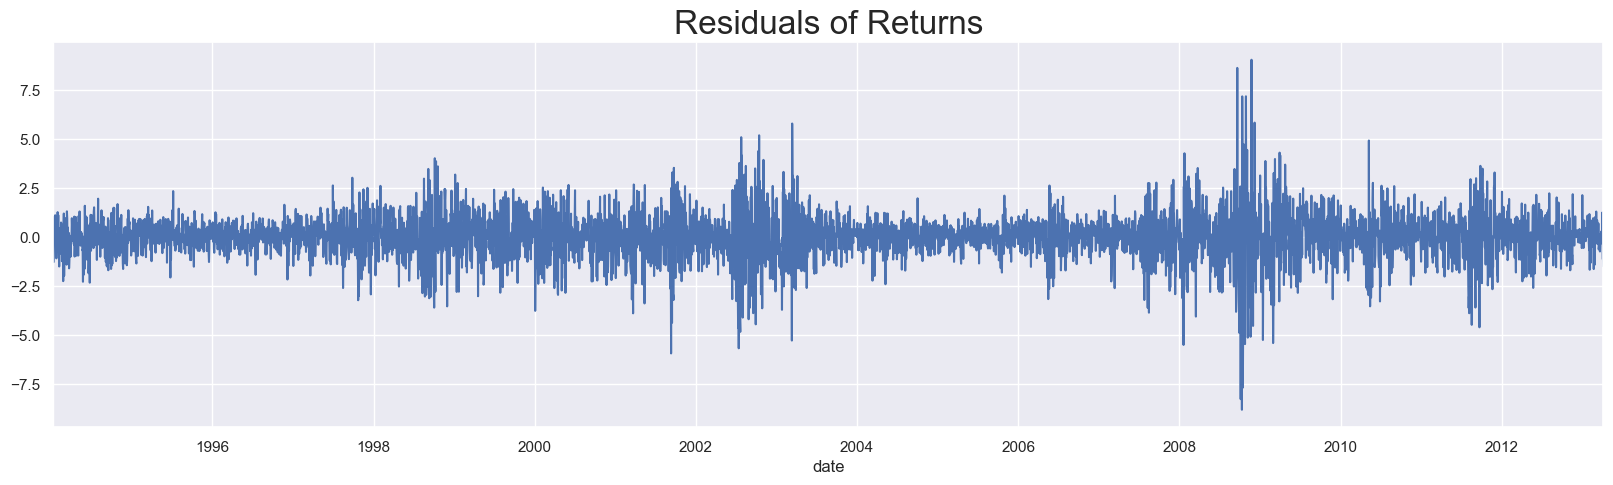

In [104]:
# Gaussian White-Noise implies normality, so we can use the 68, 95, 99.7 rule
# this dictates what part of the data is spread within 1, 2 and 3 standard deviations away from the mean in either direction 
# thus, we expect most return residuals will be between -3 and 3 (3 standard deviations : 3*1) in either direction
# this means that in the worst case scenario we could be up to 7% points off when predicting the returns for a market index
# this is far from ideal (6% = [-3%, 3%]) since we are examining the error terms not the returns (6% can make all the difference when it comes to profits and losses)
# before saying that this model is not great we need to examine its graph
df_train_2.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title('Residuals of Returns', size = 24)
plt.show()

In [105]:
# of exlude the housing bubble in the nineties and 2008 and the crisis following them then the residuals are rather random
# they're simply confined with some reasonable range which can be expected 
# to test that the residuals resemble a chite noise process we can check for stationarity
# of course if the data is non-stationary it can't be considered white noise
# thus, we run the adjusted Dickey-Fuller test
sts.adfuller(df_train_2.res_ret_ma_8[2:])

(-70.84320126984603,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15684.9815076607)

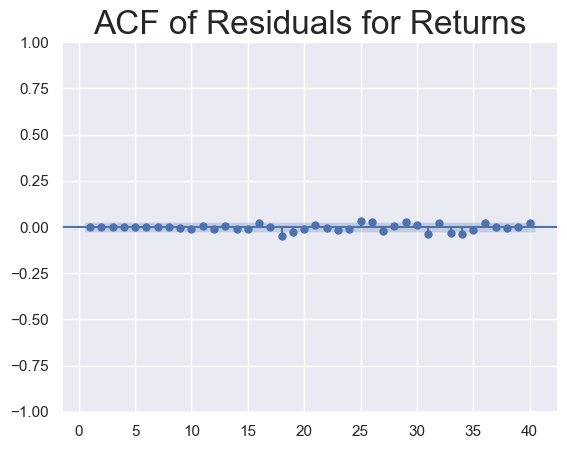

In [106]:
# we see that the p-value is 0 so the data is indeed stationary
# however stationarity is not the same as white noise, so we should also examine the ACF of the residuals
# recall that white noise coefficients should not be significantly different from 0
sgt.plot_acf(df_train_2.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title('ACF of Residuals for Returns', size = 24)
plt.show()

In [107]:
# we can see that most of the coefficients are not significant (they lie in the blue area)
# in particular none of the first 17 lags are significant
# the further back in time we go the less relevant the value and the errors become
# hence, significant coefficients some 18 lags ago shouldn't play a major role in estimations
# markets adjust to shocks, so values far in the past lose relevance

**Model selection for normalized returns (MA model)**

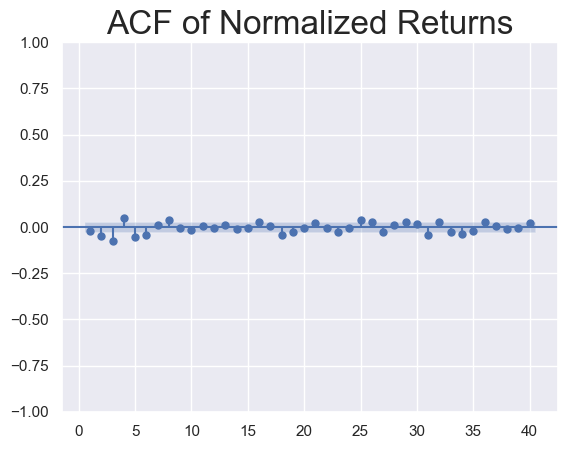

In [108]:
# normalize the returns
benchmark = df_train_2.returns.iloc[1]
df_train_2['norm_ret'] = df_train_2.returns.div(benchmark).mul(100)

# plot the ACF of the time series
sgt.plot_acf(df_train_2.norm_ret[1:], zero = False, lags= 40)
plt.title('ACF of Normalized Returns', size = 24)
plt.show()

In [109]:
# this graph is similar with the one we got for the non normalized values
# the grah suggests that we may use MA(6) or MA(8) yet again 
# let's fit the models and examine the coefficients

# fit the 8th model
model_norm_ret_ma_8 = ARIMA(df_train_2.norm_ret[1:], order = (0,0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()

# print the summary table
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5019
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -32251.425
Date:                Sun, 11 Dec 2022   AIC                          64522.850
Time:                        15:45:11   BIC                          64588.060
Sample:                    01-11-1994   HQIC                         64545.701
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4123      1.946     -1.239      0.215      -6.227       1.403
ma.L1         -0.0241      0.009     -2.550      0.011      -0.043      -0.006
ma.L2         -0.0500      0.008     -6.086      0.000      -0.066      -0.034
ma.L3         -0.0815      0.008     -9.886      0.000      -0.098      -0.065
ma.L4          0.0462      0.009      5.303      0.000       0.029       0.063
ma.L5         -0.0517      0.008     -6.267      0.000      -0.068      -0.036
ma.L6         -0.0400      0.009     -4.381      0.000      -0.058      -0.022
ma.L7          0.0085      0.009      0.946      0.344      -0.009       0.026
ma.L8          0.0375      0.010      3.943      0.000       0.019       0.056
sigma2      2.242e+04    246.250     91.029      0.000    2.19e+04    2.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6456.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

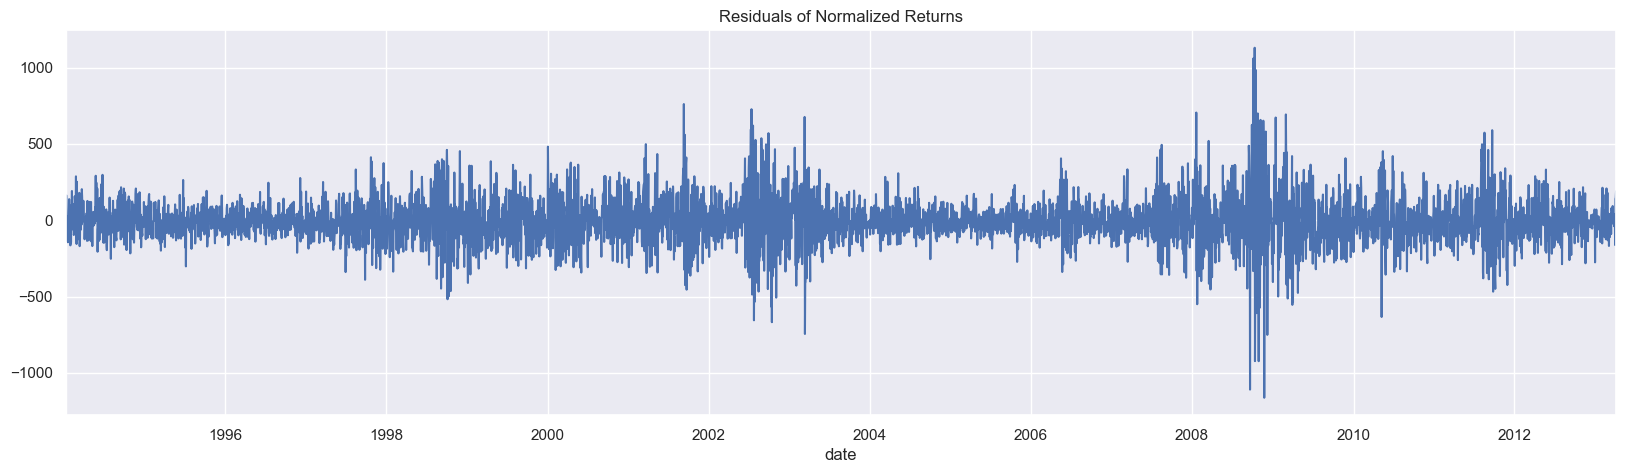

In [110]:
# the values are the same before normalizing
# so normalizing the input data doesn't affect model selection
# let's extract the residuals and take a look at their plot
df_train_2['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]

# plot the residuals
df_train_2.res_norm_ret_ma_8[1:].plot(figsize = (20,5))
plt.title('Residuals of Normalized Returns')
plt.show()

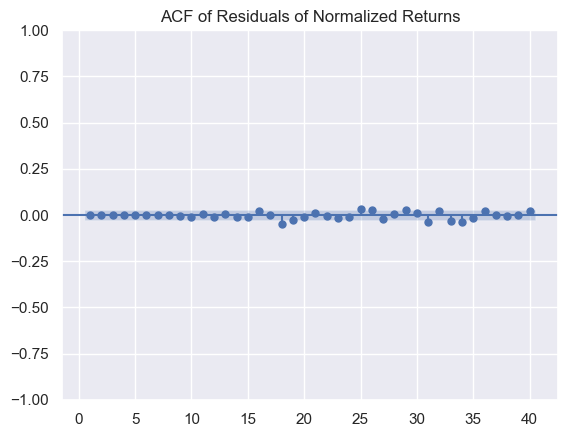

In [111]:
# plot the ACF
sgt.plot_acf(df_train_2.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title('ACF of Residuals of Normalized Returns')
plt.show()

In [112]:
# the ACF suggest that the data resembles white noise (white noise means the errors don't follow a pattern)
# so our model choice is supposedly correct

**Fitting an MA(1) model for prices**

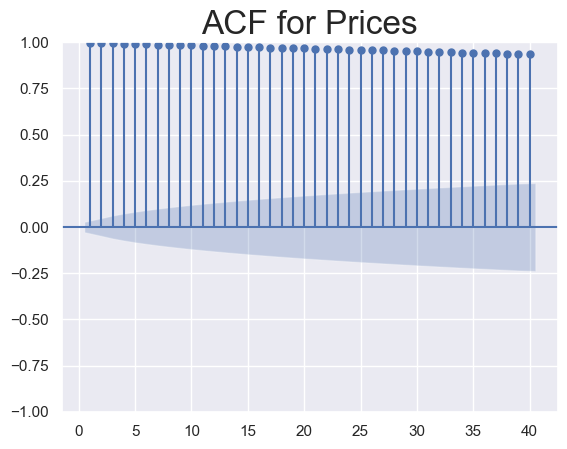

In [113]:
# we previously determined that autoregressive models are less reliable when estimating non-stationary data
# here we'll see if the same goes for the MA models
# plot the ACF for prices
sgt.plot_acf(df_train_2.market_value, zero = False, lags = 40)
plt.title('ACF for Prices', size = 24)
plt.show()

In [114]:
# the coeffcients for all the 40 lags seem to be significant (sadly)
# any higher model will be preferred on any lagged one (MA(N+1) > MA(P))
# this means we need an infinite number of models before reaching the one that fits best
# of course no such solution exists

### **The ARMA Model**

The ARMA model is a combination of the autoregressive model (AR) and the moving average (MA) model. The chart below describes a simple ARMA model with an equation:

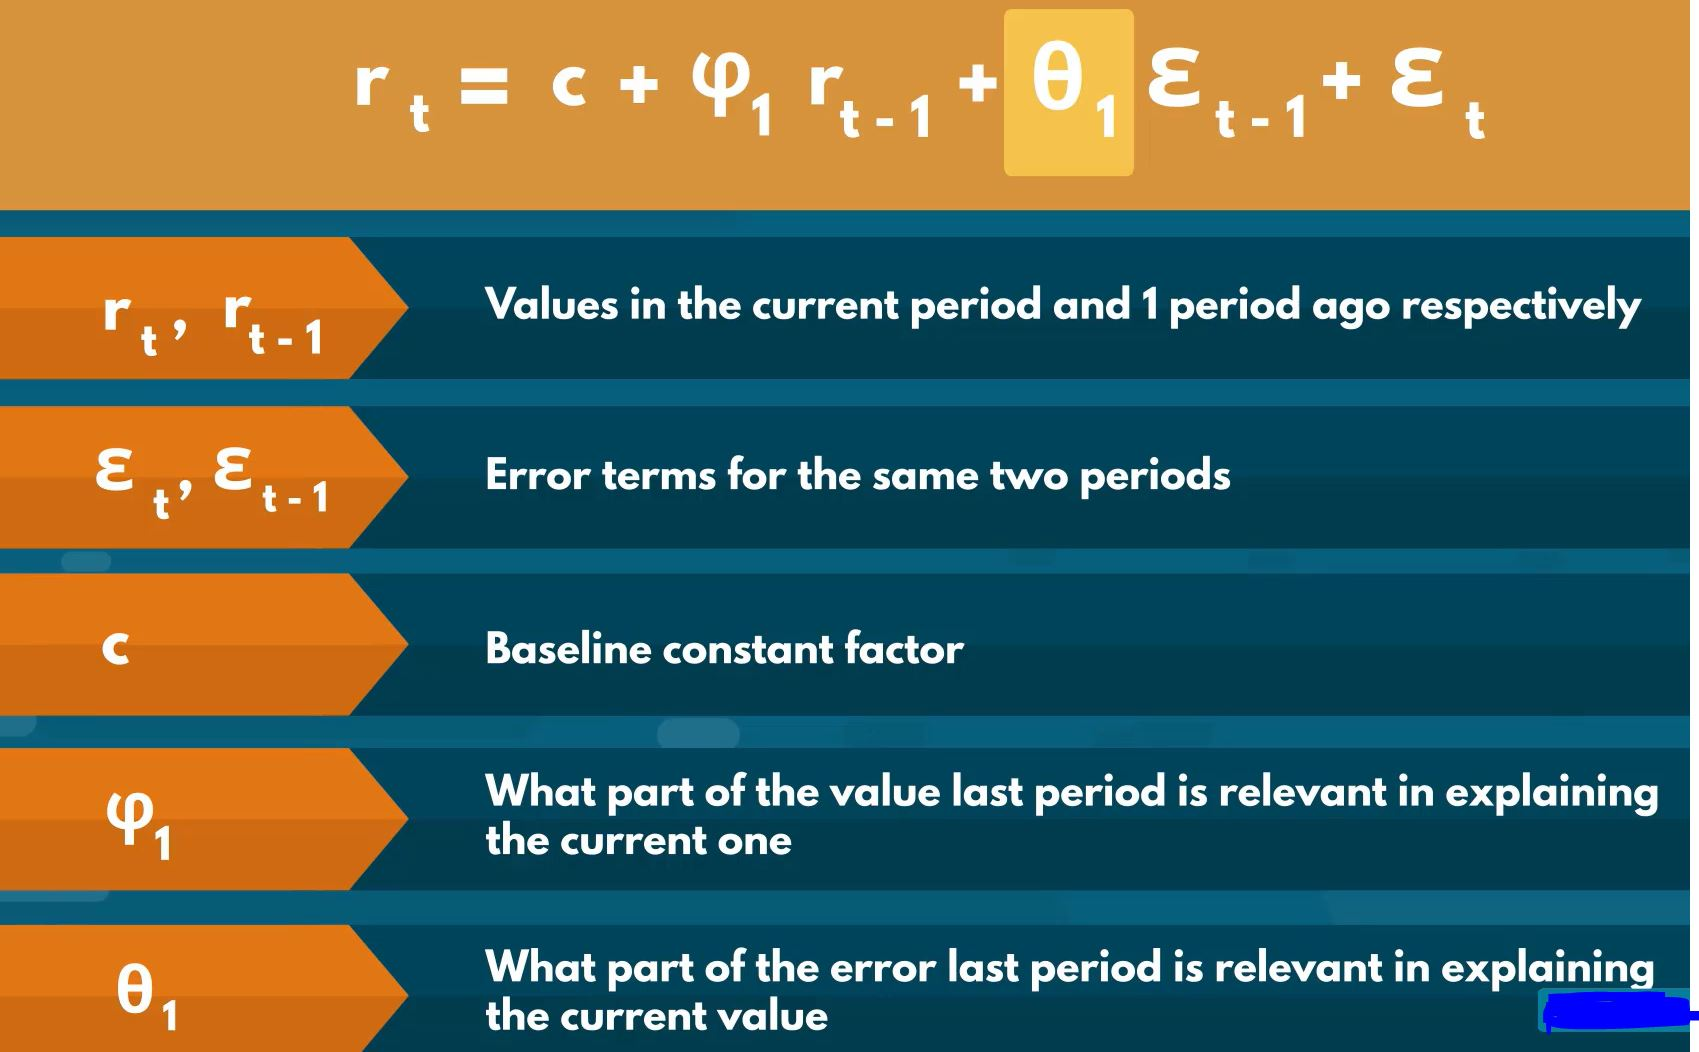



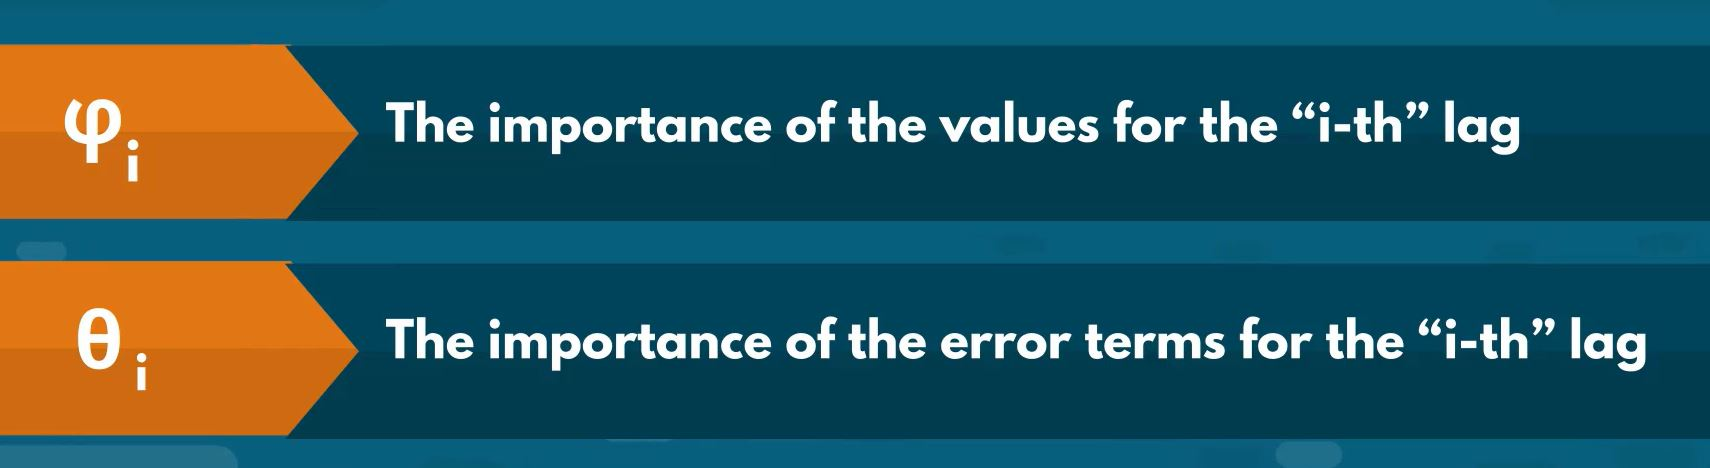

An ARMA(P,Q) takes (P,Q) values up to P periods ago but also takes the residuals up to Q lags. It's essential to note that P and Q can be equal in value but it's not mandatory.

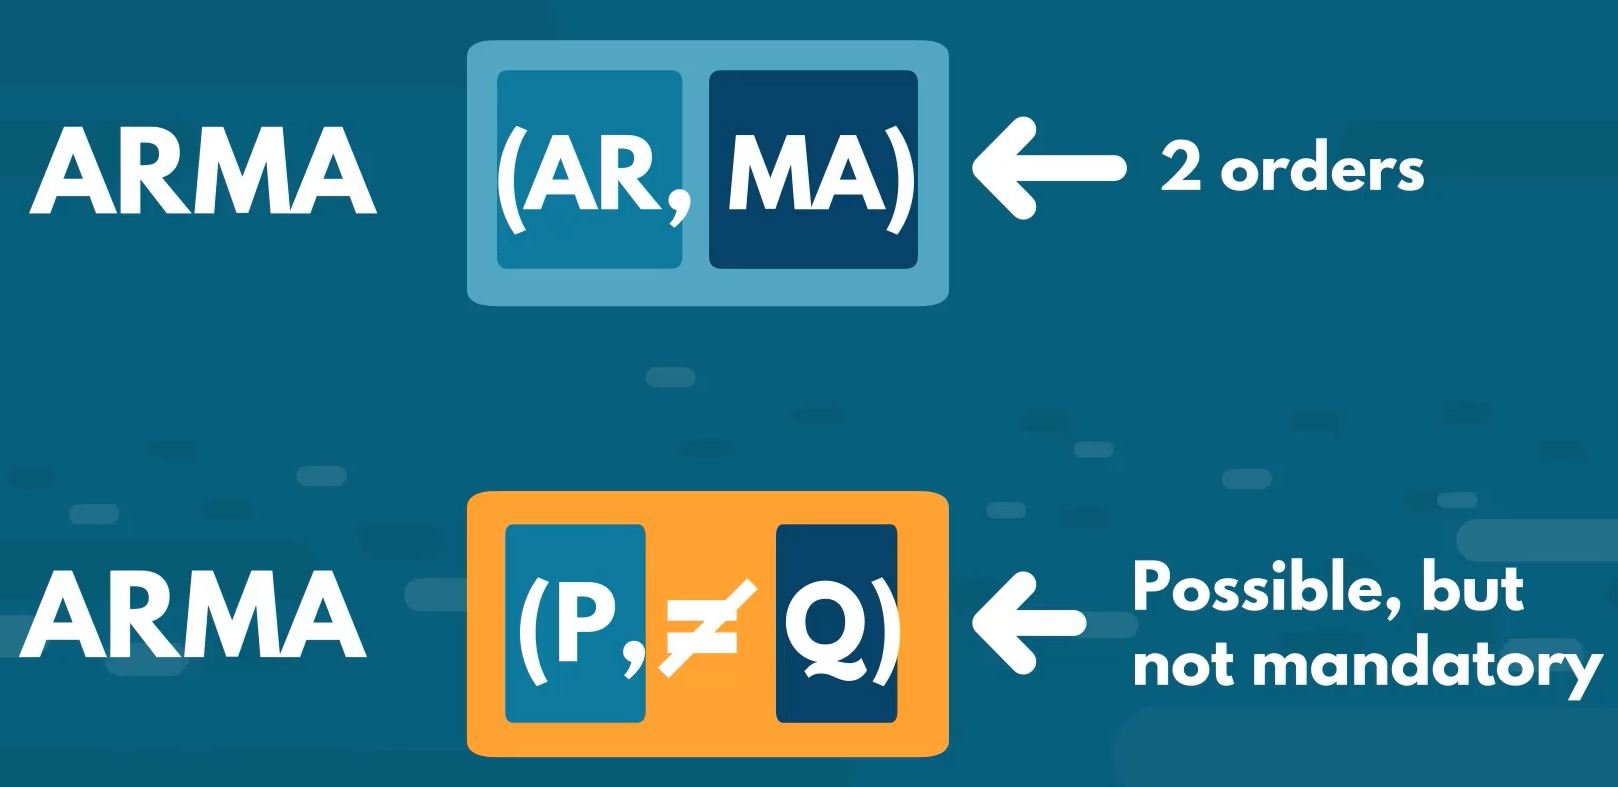

**Fitting a simple ARMA model for returns**

We will fit a time-series into a simple autoregressive moving-average model. This includes one previous value as well as one past error term. 

In [115]:
# ARMA(1,1)
model_ret_ar_1_ma_1 = ARIMA(df_train_2.returns[1:], order = (1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()

# print the summary table
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7915.508
Date:                Sun, 11 Dec 2022   AIC                          15839.016
Time:                        15:45:12   BIC                          15865.100
Sample:                    01-11-1994   HQIC                         15848.156
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.291      0.197      -0.010       0.048
ar.L1          0.7658      0.045     17.003      0.000       0.678       0.854
ma.L1         -0.8148      0.040    -20.183      0.000      -0.894      -0.736
sigma2         1.3721      0.014     98.104      0.000       1.345       1.399
===================================================================================
Ljung-Box (L1) (Q):                   2.02   Jarque-Bera (JB):              7485.72
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
# analyzing the p-values we see that only thr constant is not significantly different from 0
# it is logical that returns are centered around 0 so this is acceptable
# we also see that the autoregressive coefficient is positive (0.7657) while the moving-average one is negative (-0.8146)
# a positive coefficient of 0.7657 suggests a positive tendency between past and present values
# in other words returns move in trends of consecutive positive or negative values
# this translates to periods persistent increases or decreases when translated to prices
# the MA negative coefficient are slightly harder to interpret
# it suggests that we should be moving away from the past period (t-1) values rather than trying to use them as targets for calibration
# to elaborate, we want to prevent our targets from mving , before we've accounted for them

# now we need to run the log-likelihood test to test if it is a better predictor than the AR and MA models when used separately
# note that ARMA(1,1) has 2 degrees of freedom
# and AR(1) has 1 degree of freedom
# MA(1) has 1 degree of freedom
# so the difference is 1
print('ARMA vs AR ', LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1, DF = 1))
print('\nARMA vs MA ', LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1, DF = 1))

ARMA vs AR  0.0

ARMA vs MA  0.0


In [117]:
# the values for both tests is equal to 0, this suggests that using past errors in conjunction with past values results in much better predictions
# another way of interpreting the results is that our past estimators (past estimators include both past values and past errors) perform better as predictors than actual past values
# so ARMA models ought to perform well when forecasting values into the future

**Fitting higher-lag ARMA models for returns**

When fitting higher-lag ARMA models we take a different approach than when fitting a simple AR(1) or MA(1) model. Since we're combining AR and MA we'll use fewer lags. On one hand, taking into account error terms will allow AR models to calibrate faster and adjust to some huge shocks. On the other hand, adding past values would give MA terms a much better foundation for predictions. So we'll start with an over-parametrized ARMA(Q,P) model with several lags for the AR and MA components. In other terms, we refer to past values and their associated coefficients as AR components, and past residuals and associated coefficients as MA components. We'll then start decreasing the number of lags and test different models until we find one with all coefficients significant with a high-log likelihood and low information criteria. Such a model will descrive the data best.

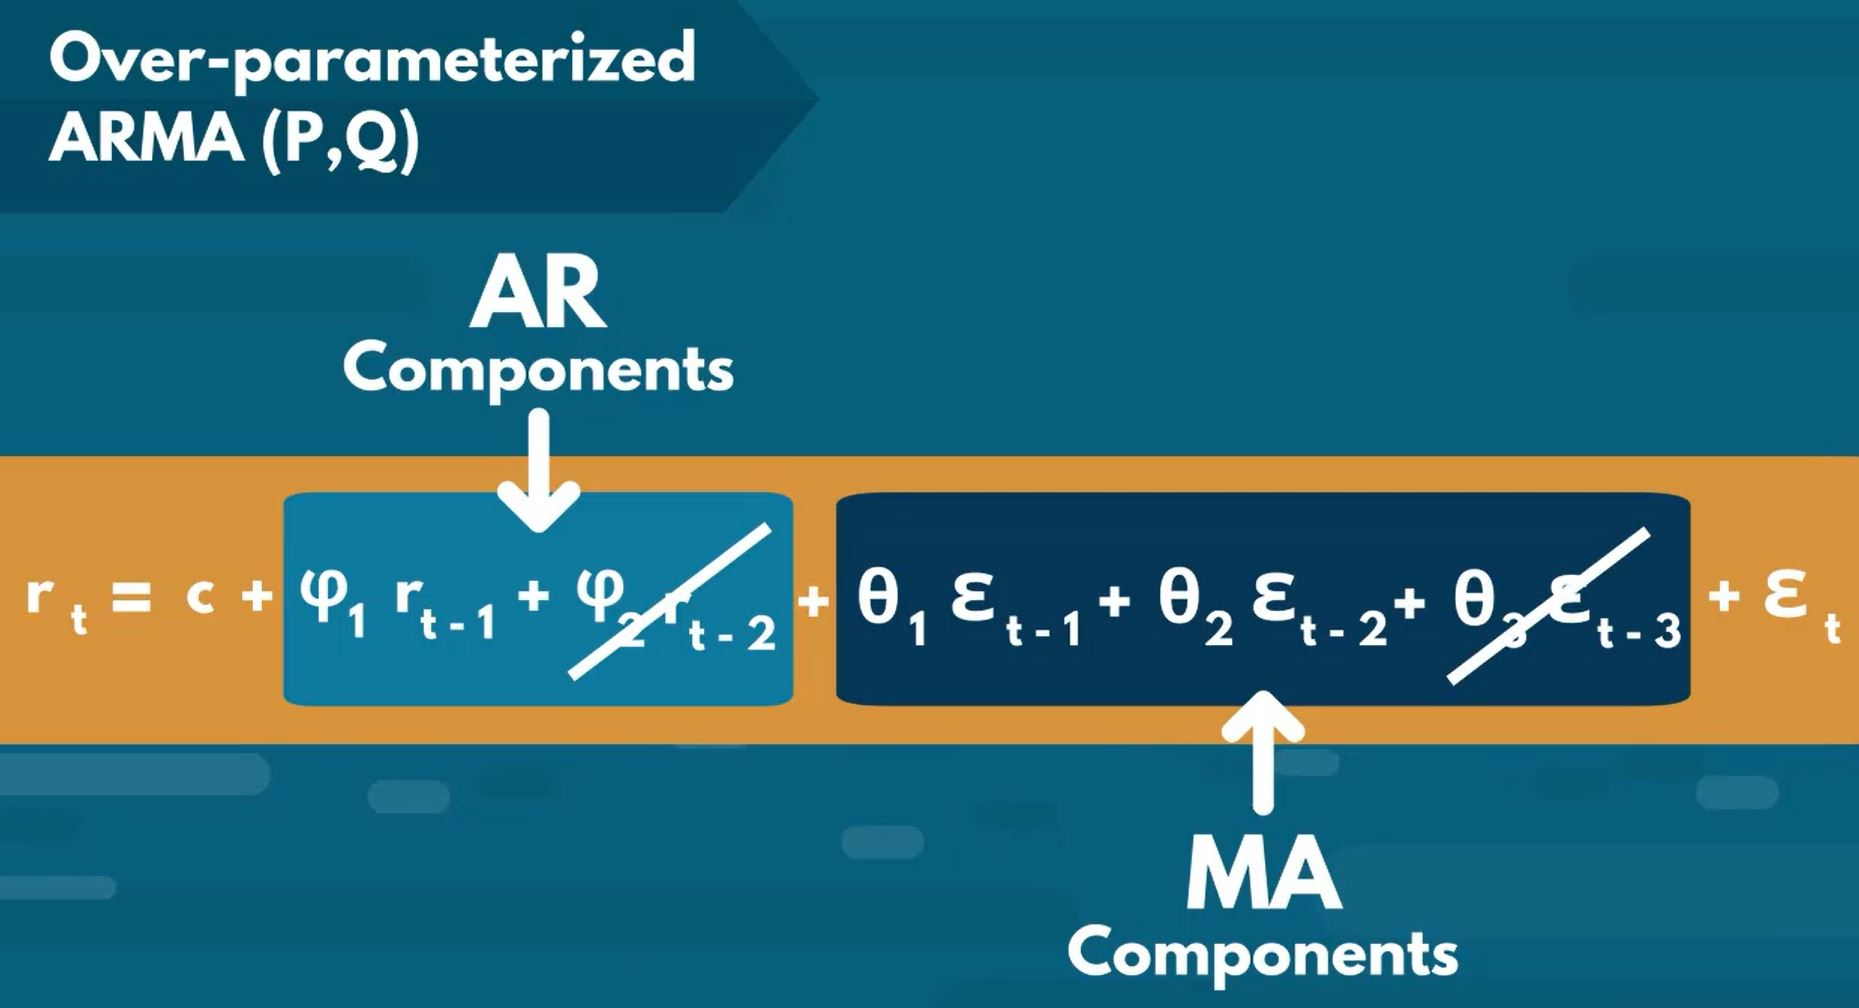

In [118]:
# the ACF and the PACF gave us a good idea on the appropriate number of lags to use for the AR and MA models 
# the AR and MA models complement one another, so the optimal ARMA model would contain fewer components of each type
# this means that our we expect our ARMA model to contain no more than 6 AR parts and at most 8 MA parts 
# this happens because if the AR(6) and MA(8) models were able to explain the changes (period to period) on their own, then using them simultaneously would be redundant
# we previously stated that we start with an over-parametrized model
# so we could choose a complicated multi-lag model like ARMA(6,8) to see what we get
# the downside is many of the coefficients would probably cancel each other out 
# in this I chose an ARMA of order (3,3)
model_ret_ar_3_ma_3 = ARIMA(df_train_2.returns[1:], order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

# print the summary table
print(results_ret_ar_3_ma_3.summary())

# print the LLR test check if the new model is a better predictor than its simpler part
print('\nLLR test: ', LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3)) # set the DF to 4 since ARMA(3,3) contains 6 coefficients and ARMA(1,1) contains 2 (6-2=4)

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7894.008
Date:                Sun, 11 Dec 2022   AIC                          15804.015
Time:                        15:45:17   BIC                          15856.183
Sample:                    01-11-1994   HQIC                         15822.296
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.287      0.198      -0.010       0.048
ar.L1         -0.1711      0.069     -2.482      0.013      -0.306      -0.036
ar.L2         -0.2959      0.054     -5.441      0.0

In [119]:
# we can notice that the first lag moving average coefficient as well as the first lag AR coefficient are not significantly different from 0
# this suggests that it may be irrelevant so a lower lag model might be of better use
# the LLR test suggests that the ARMA(3,3) makes better estimations than ARMA(1,1)
# therefore, if ARMA(3,3) is not the optimal model, then we can expect the best fit to be somewhere between ARMA(1,1) and ARMA(3,3)
# so what we can do is to lower the AR orders or the MA orders or both
# we begin with the models that consist of 5 total orders (AR + MA)
# so we start with ARMA(3,2) or ARMA(2,3)
model_ret_ar_3_ma_2 = ARIMA(df_train_2.returns[1:], order = (3,0,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()

# print the summary table
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7896.456
Date:                Sun, 11 Dec 2022   AIC                          15806.912
Time:                        15:45:24   BIC                          15852.559
Sample:                    01-11-1994   HQIC                         15822.907
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.016      1.214      0.225      -0.012       0.049
ar.L1         -0.6677      0.056    -11.893      0.000      -0.778      -0.558
ar.L2         -0.5187      0.064     -8.085      0.000      -0.644      -0.393
ar.L3         -0.1108      0.009    -12.310      0.000      -0.128      -0.093
ma.L1          0.6456      0.057     11.354      0.000       0.534       0.757
ma.L2          0.4567      0.065      7.080      0.000       0.330       0.583
sigma2         1.3617      0.015     91.810      0.000       1.333       1.391
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6551.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
# we see that from p-values all coefficients are significantly different from zero even at the 1% significance level except for the constant
# also we notice how the absolute values of the coefficients decrease for AR and MA
# this supports the idea that the further back in time we go the less relevant values and errors become
# now let's test the ARMA(2,3)
model_ret_ar_2_ma_3 = ARIMA(df_train_2.returns[1:], order = (2,0,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()

# print the summary table
print(results_ret_ar_2_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7896.298
Date:                Sun, 11 Dec 2022   AIC                          15806.596
Time:                        15:45:26   BIC                          15852.243
Sample:                    01-11-1994   HQIC                         15822.592
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.225      0.221      -0.011       0.049
ar.L1         -0.5532      0.058     -9.522      0.000      -0.667      -0.439
ar.L2         -0.4371      0.066     -6.602      0.0

In [121]:
# the p-value at the lag 2 for MA shows that the coeffcient is not significantly different from zero
# so we shouldn't use this model
# now let's test ARMA(3,1)
model_ret_ar_3_ma_1 = ARIMA(df_train_2.returns[1:], order = (3,0,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()

# print the summary table
print(results_ret_ar_3_ma_1.summary())

# run the LLR test between ARMA(3,1) and ARMA(3,2)
print('\nLLR test: ', LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7899.529
Date:                Sun, 11 Dec 2022   AIC                          15811.057
Time:                        15:45:27   BIC                          15850.183
Sample:                    01-11-1994   HQIC                         15824.768
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.249      0.212      -0.011       0.049
ar.L1         -0.5112      0.064     -7.942      0.000      -0.637      -0.385
ar.L2         -0.0645      0.009     -7.082      0.0

In [122]:
# we can see from the p-values that all coefficients apart from the constant are significant
# the coeffcient for MA is positive and the coeffcients for AR are negative
# the LLR test yields a value of 0.013, thus we can safely say that the more complicated model is a better approximator (ARMA(3,2) > ARMA(3,1))
# now let's run ARMA(2,2)
model_ret_ar_2_ma_2 = ARIMA(df_train_2.returns[1:], order = (2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()

# print the summary table
print(results_ret_ar_2_ma_2.summary())

# run the LLR test between ARMA(3,1) and ARMA(3,2)
#print('\nLLR test: ', LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7913.925
Date:                Sun, 11 Dec 2022   AIC                          15839.849
Time:                        15:45:33   BIC                          15878.975
Sample:                    01-11-1994   HQIC                         15853.560
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.289      0.197      -0.010       0.048
ar.L1         -0.1033      0.093     -1.112      0.266      -0.285       0.079
ar.L2          0.6995      0.068     10.273      0.0

In [123]:
# the p-values show that two of the coefficients are not significant 
# what's interesting is that both insignificant coeffcients are associated with the second lag which also happens to be the last one
# this can lead us to believe that simpler models like ARMA(1,2) or the ARMA(2,1) would outperform it (ARMA(2,2))
# so we have to avoid ARMA(2,2) at all costs
# now we run ARMA(1,3)
model_ret_ar_1_ma_3 = ARIMA(df_train_2.returns[1:], order = (1,0,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()

# print the summary table
print(results_ret_ar_1_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7897.466
Date:                Sun, 11 Dec 2022   AIC                          15806.933
Time:                        15:45:34   BIC                          15846.059
Sample:                    01-11-1994   HQIC                         15820.643
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.267      0.205      -0.010       0.048
ar.L1         -0.4705      0.062     -7.604      0.000      -0.592      -0.349
ma.L1          0.4477      0.062      7.171      0.0

In [124]:
# the p-values show all four coefficients are significant, so this model has a chance to be a good predictor
# usually we'll go on to use the log-likelihood ratio test here to compare it with the ARMA(3,2)
# however, ARMA(3,2) and ARMA(1,3) aren't nested
# for a model to be nested it has to follow three conditions
# the picture below highlights those conditions

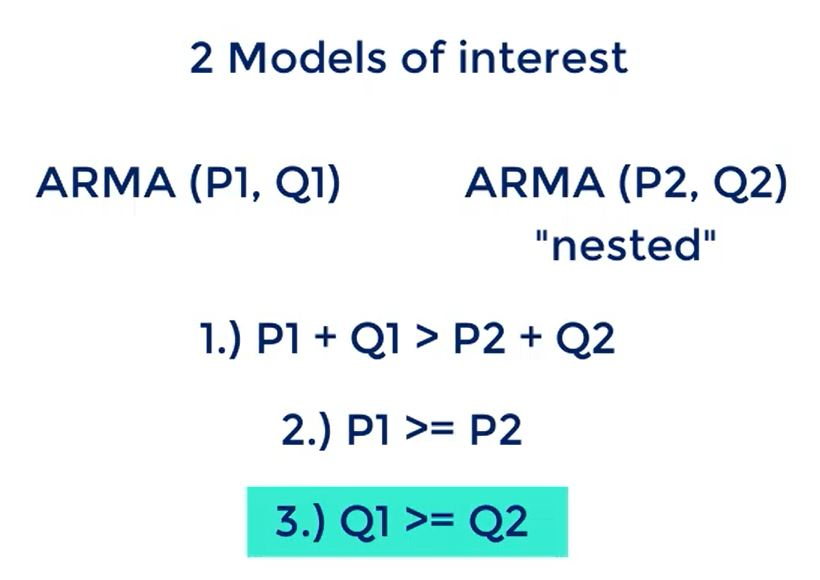

In [125]:
# since the third condition is not satisfied, we cannot run the LLR test
# so what we can do in this case we manually compare the log-likelihoods and AICs of both models
# the best model should yield a higher likelihood and lower AIC
print('ARMA(3,2): \tLL = ', results_ret_ar_3_ma_2.llf, '\tAIC =  ', results_ret_ar_3_ma_2.aic)
print('\nARMA(1,3): \tLL = ', results_ret_ar_1_ma_3.llf, '\tAIC =  ', results_ret_ar_1_ma_3.aic)

ARMA(3,2): 	LL =  -7896.455852289289 	AIC =   15806.911704578579

ARMA(1,3): 	LL =  -7897.46629225287 	AIC =   15806.93258450574


In [126]:
# the results show that ARMA(3,2) outperforms ARMA(1,3) 

**Examining the ARMA model for returns**

We will analyze the rsiduals of our predictor and extract the values and add them to the dataframe. Then, we will plot them and examine their ACF. We'll also discuss if a better model might exist and how we can find it.

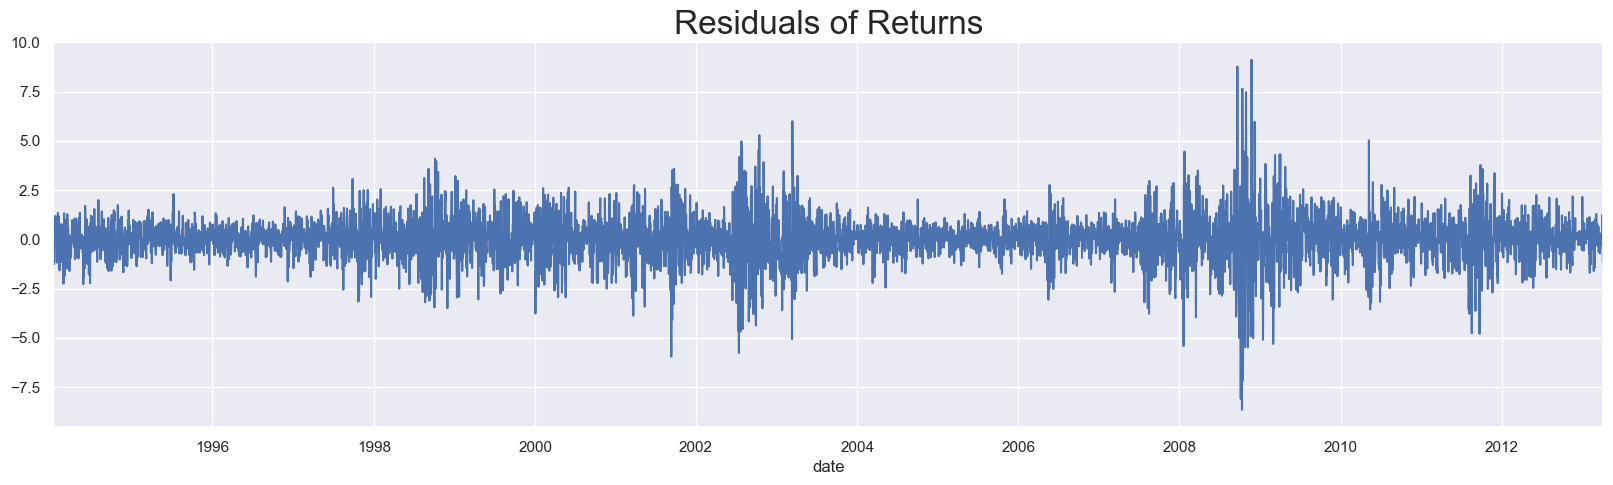

In [127]:
# extract the results, we opted for ARMA(3,2)
df_train_2['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

# plot the residuals
df_train_2.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title('Residuals of Returns', size = 24)
plt.show()

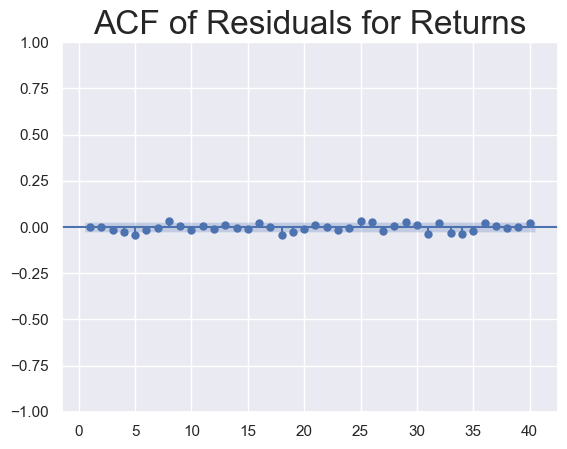

In [128]:
# these results seem to be similar to what we got for the AR and MA residuals
# this suggests the volatility in returns might not be fully comprehendable if we use only ARMA models
# to make sure the residuals are random we should plot the ACF
sgt.plot_acf(df_train_2.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title('ACF of Residuals for Returns', size = 24)
plt.show()

In [129]:
# we have more significant lags (dots outside the blue area) than the AR and MA models
# the fifth lag was incorporated for both the AR only and MA only models so it makes sense for its error term to be zero
# therefore, accounting for either returns or residuals 5 periods ago, could improve our predictions
# so we should start with ARMA(5,5) and go through the models
# once we find all the models with all coeffcients significant, we should run the LLR test of nested ones,
# and compare Log-Likelihood and AIC values for the others
model_ret_ar_5_ma_5 = ARIMA(df_train_2.returns[1:], order = (5,0,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()

# print the summary table
print(results_ret_ar_5_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7882.841
Date:                Sun, 11 Dec 2022   AIC                          15789.683
Time:                        15:45:41   BIC                          15867.935
Sample:                    01-11-1994   HQIC                         15817.104
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.015      1.296      0.195      -0.010       0.048
ar.L1         -0.0698      0.114     -0.615      0.539      -0.293       0.153
ar.L2         -0.5678      0.080     -7.070      0.0

In [130]:
# we can see only two coefficients are significant hence taking both returns and residuals 5 periods ago is redundant
# so we should only focus on one of the two
# to make things simpler I went through all the remaining models to see which ones yield significant coeffcients at the 5% significance level
model_ret_ar_5_ma_4 = ARIMA(df_train_2.returns[1:], order = (5,0,4))
results_ret_ar_5_ma_4 = model_ret_ar_5_ma_4.fit()

# print the summary table
print(results_ret_ar_5_ma_4.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -7883.842
Date:                Sun, 11 Dec 2022   AIC                          15789.685
Time:                        15:45:46   BIC                          15861.416
Sample:                    01-11-1994   HQIC                         15814.821
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.287      0.198      -0.010       0.048
ar.L1          0.1514      0.083      1.816      0.069      -0.012       0.315
ar.L2         -0.5944      0.082     -7.272      0.0

In [131]:
model_ret_ar_5_ma_3 = ARIMA(df_train_2.returns[1:], order = (5,0,3))
results_ret_ar_5_ma_3 = model_ret_ar_5_ma_3.fit()

# print the summary table
print(results_ret_ar_5_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -7885.744
Date:                Sun, 11 Dec 2022   AIC                          15791.487
Time:                        15:45:50   BIC                          15856.697
Sample:                    01-11-1994   HQIC                         15814.338
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.282      0.200      -0.010       0.048
ar.L1          0.3384      0.081      4.190      0.000       0.180       0.497
ar.L2         -0.5085      0.074     -6.831      0.0

In [132]:
model_ret_ar_5_ma_2 = ARIMA(df_train_2.returns[1:], order = (5,0,2))
results_ret_ar_5_ma_2 = model_ret_ar_5_ma_2.fit()

# print the summary table
print(results_ret_ar_5_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 2)   Log Likelihood               -7886.018
Date:                Sun, 11 Dec 2022   AIC                          15790.037
Time:                        15:45:54   BIC                          15848.726
Sample:                    01-11-1994   HQIC                         15810.602
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.287      0.198      -0.010       0.048
ar.L1          0.2817      0.077      3.682      0.000       0.132       0.432
ar.L2         -0.5096      0.074     -6.871      0.0

In [133]:
model_ret_ar_5_ma_1 = ARIMA(df_train_2.returns[1:], order = (5,0,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()

# print the summary table
print(results_ret_ar_5_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7889.878
Date:                Sun, 11 Dec 2022   AIC                          15795.755
Time:                        15:45:55   BIC                          15847.923
Sample:                    01-11-1994   HQIC                         15814.036
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.304      0.192      -0.010       0.047
ar.L1          0.3430      0.106      3.234      0.001       0.135       0.551
ar.L2         -0.0462      0.009     -4.890      0.0

In [134]:
model_ret_ar_4_ma_5 = ARIMA(df_train_2.returns[1:], order = (4,0,5))
results_ret_ar_4_ma_5 = model_ret_ar_4_ma_5.fit()

# print the summary table
print(results_ret_ar_4_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -7882.972
Date:                Sun, 11 Dec 2022   AIC                          15787.943
Time:                        15:46:01   BIC                          15859.674
Sample:                    01-11-1994   HQIC                         15813.079
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.283      0.199      -0.010       0.048
ar.L1          0.0479      0.083      0.577      0.564      -0.115       0.211
ar.L2         -0.6215      0.080     -7.791      0.0

In [135]:
model_ret_ar_3_ma_5 = ARIMA(df_train_2.returns[1:], order = (3,0,5))
results_ret_ar_3_ma_5 = model_ret_ar_3_ma_5.fit()

# print the summary table
print(results_ret_ar_3_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 5)   Log Likelihood               -7884.374
Date:                Sun, 11 Dec 2022   AIC                          15788.748
Time:                        15:46:07   BIC                          15853.958
Sample:                    01-11-1994   HQIC                         15811.599
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.271      0.204      -0.010       0.048
ar.L1          0.0355      0.088      0.401      0.688      -0.138       0.209
ar.L2         -0.8168      0.032    -25.735      0.0

In [136]:
model_ret_ar_2_ma_5 = ARIMA(df_train_2.returns[1:], order = (2,0,5))
results_ret_ar_2_ma_5 = model_ret_ar_2_ma_5.fit()

# print the summary table
print(results_ret_ar_2_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -7884.696
Date:                Sun, 11 Dec 2022   AIC                          15787.391
Time:                        15:46:11   BIC                          15846.080
Sample:                    01-11-1994   HQIC                         15807.957
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.289      0.197      -0.010       0.048
ar.L1          0.1818      0.039      4.627      0.000       0.105       0.259
ar.L2         -0.8062      0.036    -22.289      0.0

In [137]:
model_ret_ar_1_ma_5 = ARIMA(df_train_2.returns[1:], order = (1,0,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()

# print the summary table
print(results_ret_ar_1_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7891.623
Date:                Sun, 11 Dec 2022   AIC                          15799.246
Time:                        15:46:12   BIC                          15851.414
Sample:                    01-11-1994   HQIC                         15817.527
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.300      0.193      -0.010       0.048
ar.L1          0.3270      0.133      2.463      0.014       0.067       0.587
ma.L1         -0.3523      0.133     -2.644      0.0

In [138]:
# after examining the summary tables for each model, we see that only two models yield significant coeffcients: the ARMA(5,1) and ARMA(1,5)
# the two identified models have the same number of degrees of freedom so we can't apply the LLR test
# instead we must compare their log-likelihood and AIC values
print('ARMA(5,1): \tLL = ', results_ret_ar_5_ma_1.llf, '\tAIC = ', results_ret_ar_5_ma_1.aic)
print('ARMA(1,5): \tLL = ', results_ret_ar_1_ma_5.llf, '\tAIC = ', results_ret_ar_1_ma_5.aic)

ARMA(5,1): 	LL =  -7889.877719329339 	AIC =  15795.755438658678
ARMA(1,5): 	LL =  -7891.623114841364 	AIC =  15799.246229682729


In [139]:
# we clearly see that the ARMA(5,1) has a higher log-likelihood while it requests less information criteria
# hence it is the superior choice between the two => ARMA(5,1) > ARMA(1,5)
# finally we need to compare the ARMA(5,1) and ARMA(3,2) to identify the best model
print('ARMA(3,2): \tLL = ', results_ret_ar_3_ma_2.llf, '\tAIC = ', results_ret_ar_3_ma_2.aic)

ARMA(3,2): 	LL =  -7896.455852289289 	AIC =  15806.911704578579


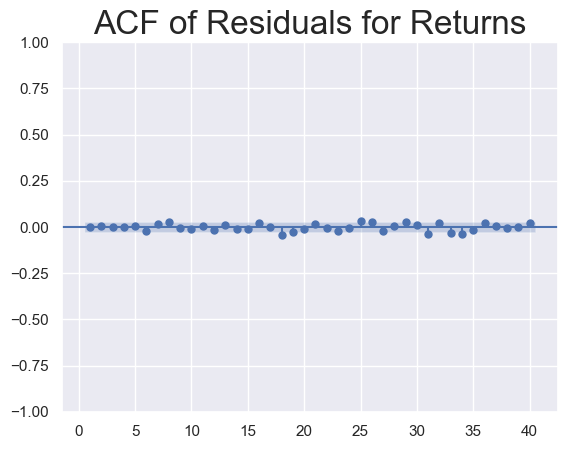

In [140]:
# the ARMA(5,1) has a higher log-likelihood and a lower information criteria so it is better than the ARMA(3,2)  
# I think the ARMA(3,2) may be too simplistic for the task
# now we need to find the error terms
df_train_2['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

# plot the ACF
sgt.plot_acf(df_train_2.res_ret_ar_5_ma_1[1:], lags = 40, zero = False)
plt.title('ACF of Residuals for Returns', size = 24)
plt.show()

In [141]:
# we see that the 5th lag is not significant anymore, but nor the 8th or any of the lags before the 18th
# the 8th lag was significant for the ARMA(3,2) model
# we culd include more lags into our model however this will predespose the model to failure when facing unfamiliar data
# including this many lags will help us know how this specific data set moves rather than understand how the actual market returns fluctuate
# so the effects of returns and errors tend to diminish over time
# therefore the further back in time we go, the less relevant the values are in predicting the future
# since more than 10 of the first lags are not significant we can say the residuals are pretty much random which is what we are trying to achieve

**ARMA for prices**

We're now going to see how ARMA models perform when they fed non-stationary data such as market index prices. The same approach used on returns will be used. By now we saw that the AR and MA models fail at predicting non-stationary data on their own.

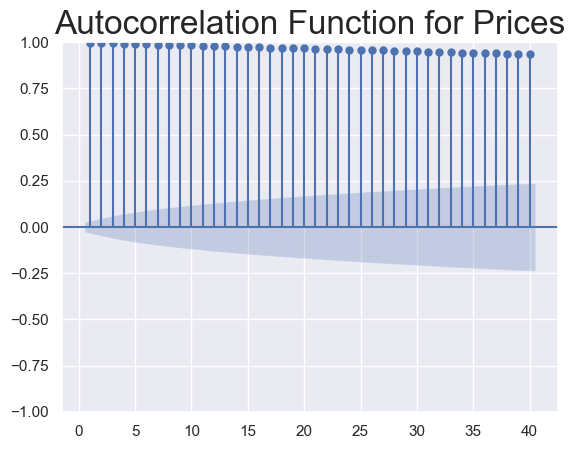

In [142]:
# first let's plot the ACF and PACF for prices
sgt.plot_acf(df_train_2.market_value, lags = 40, zero = False)
plt.title('Autocorrelation Function for Prices', size = 24)
plt.show()

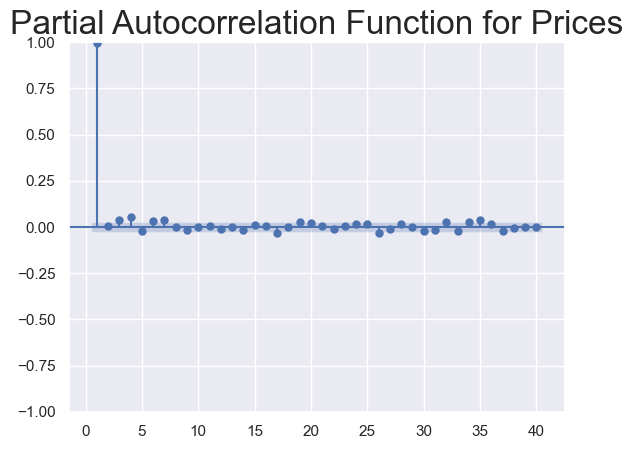

In [143]:
sgt.plot_pacf(df_train_2.market_value, lags = 40, zero = False, alpha = 0.05)
plt.title('Partial Autocorrelation Function for Prices', size = 24)
plt.show()

In [144]:
# once again we see that all ACG coefficients are significant as well as six of the first seven PACF ones  
# the ACF suggested using many MA components 
# previously we showed how an MA with infinite components (with certain restrictions) is equivalent to a simple AR model
# therefore as long as we include AR components we should be able to describe the data well by using a finite number of total lags
# let's start with a simple ARMA model and examine its residuals
model_ar_1_ma_1 = ARIMA(df_train_2.market_value, order = (1,0,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit() 
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27616.877
Date:                Sun, 11 Dec 2022   AIC                          55241.754
Time:                        15:46:13   BIC                          55267.838
Sample:                    01-10-1994   HQIC                         55250.894
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0289    363.322     14.010      0.000    4377.931    5802.127
ar.L1          0.9982      0.001   1191.642      0.000       0.997       1.000
ma.L1         -0.0186      0.010     -1.899      0.058      -0.038       0.001
sigma2      3511.4783     41.083     85.474      0.000    3430.958    3591.999
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3277.28
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

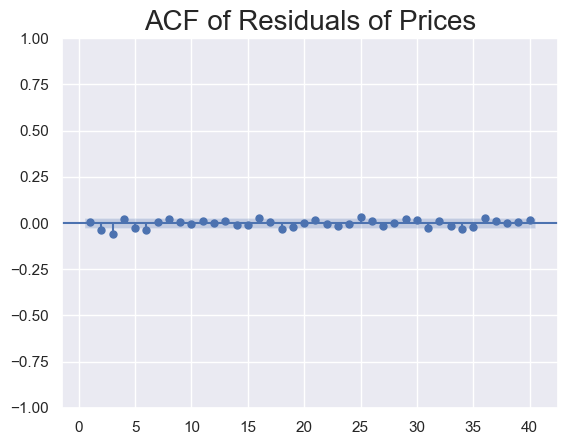

In [145]:
# by examining the p-values we see that constant coefficient and the AR one are significant but not the MA one 
# this indicates that the simple model is not the best fit
# we need to investigate the residuals before choosing our over-parameterized model
df_train_2['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

# plot the ACF
sgt.plot_acf(df_train_2.res_ar_1_ma_1, zero = False, lags = 40)
plt.title('ACF of Residuals of Prices', size = 20)
plt.show()

In [146]:
# we see that 5 of the first six lags are significant so we must amend this
# previously we did so by accounting for up to that many lags in our model
# let's fit an ARMA(6,6)
model_ar_6_ma_6 = ARIMA(df_train_2.market_value, order = (6,0,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()

# print the summary table
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27587.436
Date:                Sun, 11 Dec 2022   AIC                          55202.873
Time:                        15:46:21   BIC                          55294.169
Sample:                    01-10-1994   HQIC                         55234.864
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0288    503.779     10.104      0.000    4102.639    6077.418
ar.L1          0.7427      1.904      0.390      0.696      -2.989       4.474
ar.L2          0.2131      3.164      0.067      0.946      -5.988       6.414
ar.L3         -0.3493      2.469     -0.141      0.888      -5.188       4.489
ar.L4          0.3371      1.572      0.214      0.830      -2.745       3.419
ar.L5         -0.1305      0.815     -0.160      0.873      -1.728       1.467
ar.L6          0.1848      0.451      0.410      0.682      -0.699       1.068
ma.L1          0.2359      1.904      0.124      0.901      -3.495       3.967
ma.L2         -0.0127      1.311     -0.010      0.992      -2.583       2.558
ma.L3          0.3070      1.139      0.270      0.787      -1.925       2.539
ma.L4          0.0557      0.477      0.117      0.907      -0.878       0.990
ma.L5          0.1392      0.542      0.257      0.797      -0.922       1.201
ma.L6         -0.0809      0.168     -0.482      0.630      -0.410       0.248
sigma2      3465.0002     43.208     80.194      0.000    3380.314    3549.686
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2972.57
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
# we got an error message
# there is a text describing the problem which says that the initial AR coefficients are not stationary
# there are 3 solutions:
# 1. induce stationarity: which we dot by transforming the data into returns
# 2. choose a different order: to be avoided because we are interested in order (6,6)
# 3. set our own parameters
# let's fit the model again by setting the "start_ar_lags" parameter
model_ar_6_ma_6 = ARIMA(df_train_2.market_value, order = (6,0,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27587.436
Date:                Sun, 11 Dec 2022   AIC                          55202.873
Time:                        15:46:29   BIC                          55294.169
Sample:                    01-10-1994   HQIC                         55234.864
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0288    503.779     10.104      0.000    4102.639    6077.418
ar.L1          0.7427      1.904      0.390      0.696      -2.989       4.474
ar.L2          0.2131      3.164      0.067      0.946      -5.988       6.414
ar.L3         -0.3493      2.469     -0.141      0.888      -5.188       4.489
ar.L4          0.3371      1.572      0.214      0.830      -2.745       3.419
ar.L5         -0.1305      0.815     -0.160      0.873      -1.728       1.467
ar.L6          0.1848      0.451      0.410      0.682      -0.699       1.068
ma.L1          0.2359      1.904      0.124      0.901      -3.495       3.967
ma.L2         -0.0127      1.311     -0.010      0.992      -2.583       2.558
ma.L3          0.3070      1.139      0.270      0.787      -1.925       2.539
ma.L4          0.0557      0.477      0.117      0.907      -0.878       0.990
ma.L5          0.1392      0.542      0.257      0.797      -0.922       1.201
ma.L6         -0.0809      0.168     -0.482      0.630      -0.410       0.248
sigma2      3465.0002     43.208     80.194      0.000    3380.314    3549.686
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2972.57
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **The ARIMA Model**

We will explore the ARIMA model that extends the ARMA model giving the possibility to handle non-stationary data. An ARIMA model has three orders ARIMA(p,d,q). The p and q represent the AR and MA lags respectively and the d order represents the integration order. the intergration order represents the number of times we need to integrate the time-series to ensure stationarity. When the integtation order is 0 this is equivalent to an ARMA model => ARIMA(p,0,q) = ARMA(p,q). Also ARIMA(0,0,q) = MA(q) and ARIMA(p,0,0) = AR(p). 
The equation below illustrates the intuition behind an ARIMA model.

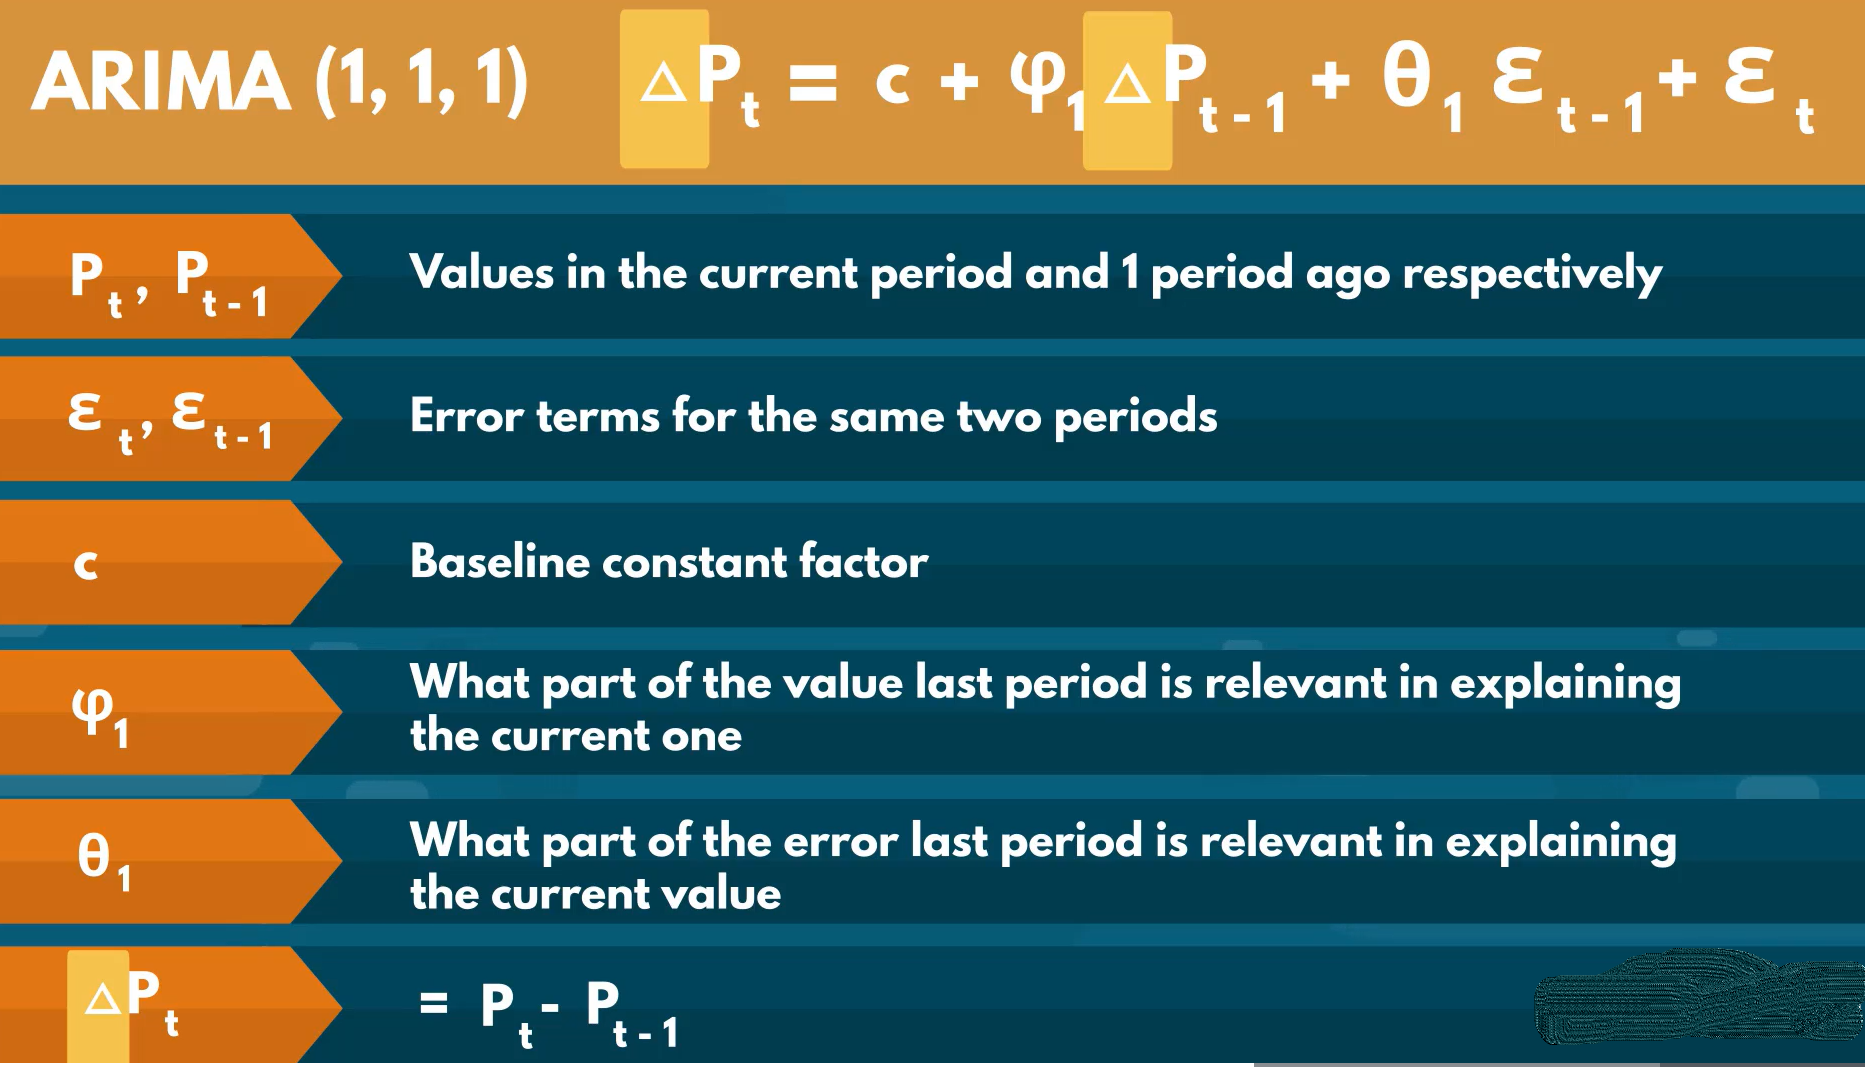

**Fitting a simple ARIMA model for prices**

In [148]:
# fit the model
model_ar_1_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()

# print the summary table
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27599.046
Date:                Sun, 11 Dec 2022   AIC                          55204.092
Time:                        15:46:30   BIC                          55223.655
Sample:                    01-10-1994   HQIC                         55210.947
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7459      0.059     12.633      0.000       0.630       0.862
ma.L1         -0.7918      0.053    -14.893      0.000      -0.896      -0.688
sigma2      3497.9132     40.910     85.503      0.000    3417.732    3578.095
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):              3323.42
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

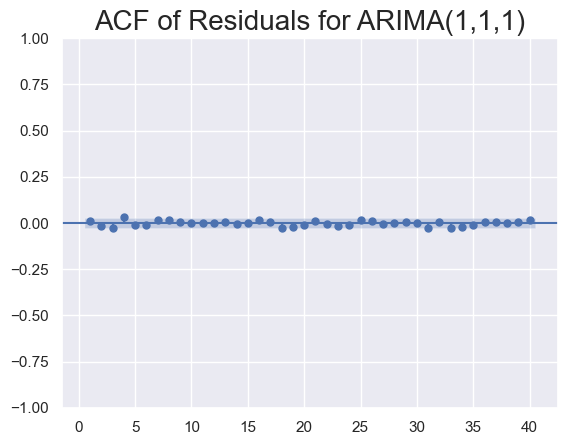

In [149]:
# we have two coeffcients apart from the constanat: one for the AR and one for the MA
# this corresponds to the two coeffcients in the previously mentionned equation Φ1 and θ1
# the integration order (d) has no effect on the number of parameters we need to estimate
# integration means we are transforming the underlying data while no modeling is performed
# hence any model ARIMA(p,d,q) will will have as many coeffcients as its non integrated counterpart ARIMA(p,q)
# the p-values show that the two coeffcients for AR and MA are significantly different from 0, the constant coeffcient however is not significantly different from 0
# this mostly resembles to what we got for returns in the ARMA models, this is because the integration model calculates differences

# let's explore the residuals of the ARIMA(1,1,1) and plot the ACF
df_train_2['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df_train_2.res_ar_1_i_1_ma_1, zero = False, lags = 40)
plt.title('ACF of Residuals for ARIMA(1,1,1)', size = 20)
plt.show()

In [150]:
# the ACF failed to compute due to the missing value at the forst element as we can see it in the dataframe below
# since the ACF starts by comparing elements from the first one going forward, a missing value at the very beginning causes it to break
df_train_2.head()

spx      dax     ftse    nikkei  market_value   returns  \
date                                                                     
1994-01-10  475.27  2225.00  3440.58  18443.44       3440.58 -0.156704   
1994-01-11  474.13  2228.10  3413.77  18485.25       3413.77 -0.779229   
1994-01-12  474.17  2182.06  3372.02  18793.88       3372.02 -1.222988   
1994-01-13  472.47  2142.37  3360.01  18577.26       3360.01 -0.356166   
1994-01-14  474.91  2151.05  3400.56  18973.70       3400.56  1.206842   

                  norm    norm_ret  res_price   res_ret  res_ret_ma_8  \
date                                                                    
1994-01-10  100.000000   20.110175  -8.530164 -0.175617           NaN   
1994-01-11   99.220771  100.000000 -29.989077 -0.802180           NaN   
1994-01-12   98.007313  156.948464 -45.483256 -1.270086     -1.259928   
1994-01-13   97.658244   45.707526 -17.504074 -0.465770     -0.444074   
1994-01-14   98.836824 -154.876361  33.593109  1.062358      1.050155   

            res_norm_ret_ma_8  res_ret_ar_3_ma_2  res_ret_ar_5_ma_1  \
date                                                                  
1994-01-10                NaN                NaN                NaN   
1994-01-11                NaN                NaN          -0.798184   
1994-01-12         161.669029          -1.260268          -1.260324   
1994-01-13          56.967048          -0.445584          -0.445677   
1994-01-14        -134.792183           1.058343           1.049293   

            res_ar_1_ma_1  res_ar_1_i_1_ma_1  
date                                          
1994-01-10   -1649.448926        3440.580000  
1994-01-11     -29.884402         -26.301859  
1994-01-12     -45.315111         -42.480253  
1994-01-13     -15.937991         -14.405900  
1994-01-14      37.148313          38.122453

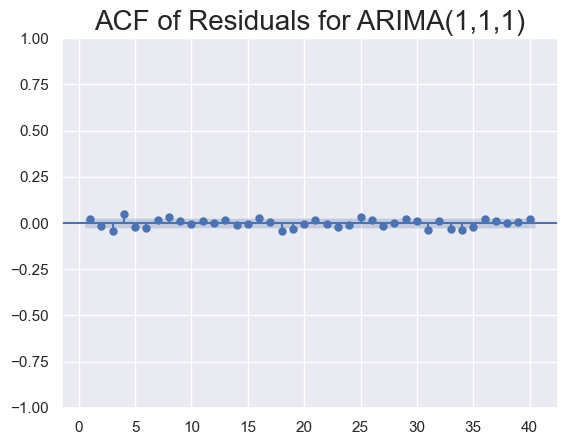

In [151]:
# the easiest solution for this problem is to get rid of the first element
# a much more effcient way is to use the residuals from the second period onward
df_train_2['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df_train_2.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title('ACF of Residuals for ARIMA(1,1,1)', size = 20)
plt.show()

In [152]:
# we can observe that the third and fourth lag are highly significant
# furthermore, incorporating these lags into our model might significantly improve performance

**Fitting higher-lag ARIMA models for prices**

In [153]:
# since the third and fourth lag are highly significant we'll try and see how the models that contain them perform
# we will go through all model from ARIMA(1,1,1) to ARIMA(4,1,4)

# fit the model ARIMA(1,1,2)
model_ar_1_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()

# print the summary table
results_ar_1_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -27595.467
Date:                Sun, 11 Dec 2022   AIC                          55198.934
Time:                        15:46:30   BIC                          55225.018
Sample:                    01-10-1994   HQIC                         55208.074
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5850      0.080      7.351      0.000       0.429       0.741
ma.L1         -0.6092      0.079     -7.736      0.000      -0.764      -0.455
ma.L2         -0.0459      0.012     -3.948      0.000      -0.069      -0.023
sigma2      3506.6513     41.059     85.405      0.000    3426.177    3587.126
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3314.61
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
# fit the model ARIMA(1,1,3)
model_ar_1_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()

# print the summary table
results_ar_1_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -27586.891
Date:                Sun, 11 Dec 2022   AIC                          55183.782
Time:                        15:46:31   BIC                          55216.387
Sample:                    01-10-1994   HQIC                         55195.208
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3585      0.091     -3.927      0.000      -0.537      -0.180
ma.L1          0.3384      0.091      3.723      0.000       0.160       0.517
ma.L2         -0.0599      0.010     -6.077      0.000      -0.079      -0.041
ma.L3         -0.0970      0.009    -10.443      0.000      -0.115      -0.079
sigma2      3489.4393     41.928     83.224      0.000    3407.262    3571.617
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3003.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
# fit the model ARIMA(1,1,4)
model_ar_1_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (1,1,4))
results_ar_1_i_1_ma_4 = model_ar_1_i_1_ma_4.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_1_i_1_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -27586.844
Date:                Sun, 11 Dec 2022   AIC                          55185.687
Time:                        15:46:32   BIC                          55224.813
Sample:                    01-10-1994   HQIC                         55199.397
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2930      0.262     -1.118      0.264      -0.807       0.221
ma.L1          0.2729      0.264      1.034      0.301      -0.244       0.790
ma.L2         -0.0587      0.010     -5.669      0.000      -0.079      -0.038
ma.L3         -0.0929      0.016     -5.880      0.000      -0.124      -0.062
ma.L4          0.0080      0.025      0.318      0.750      -0.041       0.057
sigma2      3487.1049     42.073     82.883      0.000    3404.644    3569.566
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2996.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
# fit the model ARIMA(2,1,4)
model_ar_2_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (2,1,4))
results_ar_2_i_1_ma_4 = model_ar_2_i_1_ma_4.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_2_i_1_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -27586.356
Date:                Sun, 11 Dec 2022   AIC                          55186.712
Time:                        15:46:33   BIC                          55232.359
Sample:                    01-10-1994   HQIC                         55202.708
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2848      0.424      0.672      0.501      -0.546       1.115
ar.L2          0.3032      0.129      2.355      0.019       0.051       0.556
ma.L1         -0.3049      0.424     -0.719      0.472      -1.136       0.526
ma.L2         -0.3493      0.124     -2.807      0.005      -0.593      -0.105
ma.L3         -0.0583      0.026     -2.203      0.028      -0.110      -0.006
ma.L4          0.0582      0.042      1.378      0.168      -0.025       0.141
sigma2      3466.1001     41.712     83.096      0.000    3384.346    3547.854
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3051.14
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
# fit the model ARIMA(3,1,4)
model_ar_3_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (3,1,4))
results_ar_3_i_1_ma_4 = model_ar_3_i_1_ma_4.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_3_i_1_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -27583.050
Date:                Sun, 11 Dec 2022   AIC                          55182.101
Time:                        15:46:36   BIC                          55234.269
Sample:                    01-10-1994   HQIC                         55200.382
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0139      0.210      0.066      0.947      -0.397       0.425
ar.L2         -0.1332      0.110     -1.210      0.226      -0.349       0.082
ar.L3          0.4020      0.086      4.648      0.000       0.232       0.572
ma.L1         -0.0343      0.210     -0.163      0.870      -0.446       0.377
ma.L2          0.0787      0.105      0.746      0.456      -0.128       0.285
ma.L3         -0.4767      0.079     -6.040      0.000      -0.631      -0.322
ma.L4          0.0293      0.025      1.156      0.247      -0.020       0.079
sigma2      3473.8176     42.101     82.512      0.000    3391.302    3556.333
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3093.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
# fit the model ARIMA(4,1,4)
model_ar_4_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (4,1,4))
results_ar_4_i_1_ma_4 = model_ar_4_i_1_ma_4.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_4_i_1_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -27582.460
Date:                Sun, 11 Dec 2022   AIC                          55182.920
Time:                        15:46:39   BIC                          55241.609
Sample:                    01-10-1994   HQIC                         55203.486
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5797      0.435     -1.333      0.183      -1.432       0.273
ar.L2         -0.2044      0.159     -1.283      0.200      -0.517       0.108
ar.L3          0.2590      0.121      2.147      0.032       0.023       0.495
ar.L4          0.2484      0.132      1.885      0.059      -0.010       0.507
ma.L1          0.5590      0.436      1.283      0.199      -0.295       1.413
ma.L2          0.1402      0.149      0.938      0.348      -0.153       0.433
ma.L3         -0.3693      0.101     -3.664      0.000      -0.567      -0.172
ma.L4         -0.2668      0.169     -1.578      0.115      -0.598       0.065
sigma2      3465.6203     41.976     82.563      0.000    3383.349    3547.891
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3080.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
# fit the model ARIMA(4,1,1)
model_ar_4_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (4,1,1))
results_ar_4_i_1_ma_1 = model_ar_4_i_1_ma_1.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_4_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -27588.317
Date:                Sun, 11 Dec 2022   AIC                          55188.634
Time:                        15:46:40   BIC                          55227.760
Sample:                    01-10-1994   HQIC                         55202.345
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3357      0.243     -1.379      0.168      -0.813       0.141
ar.L2         -0.0574      0.011     -5.184      0.000      -0.079      -0.036
ar.L3         -0.0862      0.015     -5.578      0.000      -0.117      -0.056
ar.L4          0.0097      0.022      0.441      0.660      -0.034       0.053
ma.L1          0.3158      0.245      1.289      0.197      -0.164       0.796
sigma2      3486.1802     41.972     83.059      0.000    3403.916    3568.444
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3002.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
# fit the model ARIMA(4,1,2)
model_ar_4_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (4,1,2))
results_ar_4_i_1_ma_2 = model_ar_4_i_1_ma_2.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_4_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -27587.069
Date:                Sun, 11 Dec 2022   AIC                          55188.138
Time:                        15:46:42   BIC                          55233.785
Sample:                    01-10-1994   HQIC                         55204.134
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3166      0.243      1.300      0.194      -0.161       0.794
ar.L2          0.3186      0.098      3.251      0.001       0.127       0.511
ar.L3         -0.0509      0.016     -3.148      0.002      -0.083      -0.019
ar.L4          0.0585      0.023      2.509      0.012       0.013       0.104
ma.L1         -0.3381      0.244     -1.387      0.166      -0.816       0.140
ma.L2         -0.3646      0.100     -3.660      0.000      -0.560      -0.169
sigma2      3484.3901     42.072     82.819      0.000    3401.929    3566.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3075.43
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
# fit the model ARIMA(4,1,3)
model_ar_4_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (4,1,3))
results_ar_4_i_1_ma_3 = model_ar_4_i_1_ma_3.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_4_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -27582.973
Date:                Sun, 11 Dec 2022   AIC                          55181.947
Time:                        15:46:45   BIC                          55234.115
Sample:                    01-10-1994   HQIC                         55200.227
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0194      0.169     -0.114      0.909      -0.352       0.313
ar.L2         -0.1234      0.105     -1.175      0.240      -0.329       0.082
ar.L3          0.3800      0.085      4.489      0.000       0.214       0.546
ar.L4          0.0290      0.021      1.386      0.166      -0.012       0.070
ma.L1         -0.0015      0.169     -0.009      0.993      -0.333       0.330
ma.L2          0.0685      0.101      0.676      0.499      -0.130       0.267
ma.L3         -0.4566      0.079     -5.778      0.000      -0.612      -0.302
sigma2      3476.0954     42.168     82.435      0.000    3393.448    3558.743
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3088.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
# fit the model ARIMA(3,1,1)
model_ar_3_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_3_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -27588.402
Date:                Sun, 11 Dec 2022   AIC                          55186.803
Time:                        15:46:45   BIC                          55219.408
Sample:                    01-10-1994   HQIC                         55198.229
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4087      0.095     -4.302      0.000      -0.595      -0.223
ar.L2         -0.0593      0.010     -5.830      0.000      -0.079      -0.039
ar.L3         -0.0914      0.009     -9.771      0.000      -0.110      -0.073
ma.L1          0.3885      0.096      4.063      0.000       0.201       0.576
sigma2      3488.5271     41.911     83.236      0.000    3406.382    3570.672
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3008.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
# fit the model ARIMA(3,1,2)
model_ar_3_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_3_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -27587.161
Date:                Sun, 11 Dec 2022   AIC                          55186.323
Time:                        15:46:46   BIC                          55225.448
Sample:                    01-10-1994   HQIC                         55200.033
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5674      0.080     -7.130      0.000      -0.723      -0.411
ar.L2         -0.4416      0.088     -5.030      0.000      -0.614      -0.270
ar.L3         -0.0938      0.010     -9.540      0.000      -0.113      -0.075
ma.L1          0.5491      0.080      6.860      0.000       0.392       0.706
ma.L2          0.3854      0.088      4.362      0.000       0.212       0.559
sigma2      3484.5738     42.019     82.929      0.000    3402.218    3566.929
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2995.39
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [164]:
# fit the model ARIMA(3,1,3)
model_ar_3_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (3,1,3))
results_ar_3_i_1_ma_3 = model_ar_3_i_1_ma_3.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_3_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -27583.404
Date:                Sun, 11 Dec 2022   AIC                          55180.808
Time:                        15:46:49   BIC                          55226.455
Sample:                    01-10-1994   HQIC                         55196.804
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1762      0.086     -2.054      0.040      -0.344      -0.008
ar.L2         -0.2433      0.074     -3.284      0.001      -0.389      -0.098
ar.L3          0.3994      0.081      4.948      0.000       0.241       0.558
ma.L1          0.1580      0.081      1.944      0.052      -0.001       0.317
ma.L2          0.1831      0.071      2.564      0.010       0.043       0.323
ma.L3         -0.4860      0.076     -6.405      0.000      -0.635      -0.337
sigma2      3482.1966     42.174     82.568      0.000    3399.538    3564.856
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3110.85
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
# fit the model ARIMA(2,1,1)
model_ar_2_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_2_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -27595.194
Date:                Sun, 11 Dec 2022   AIC                          55198.389
Time:                        15:46:49   BIC                          55224.473
Sample:                    01-10-1994   HQIC                         55207.529
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6269      0.071      8.835      0.000       0.488       0.766
ar.L2         -0.0471      0.011     -4.214      0.000      -0.069      -0.025
ma.L1         -0.6498      0.070     -9.344      0.000      -0.786      -0.514
sigma2      3492.8035     40.764     85.683      0.000    3412.907    3572.700
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3305.32
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
# fit the model ARIMA(2,1,2)
model_ar_2_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (2,1,2))
results_ar_2_i_1_ma_2 = model_ar_2_i_1_ma_2.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_2_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -27594.911
Date:                Sun, 11 Dec 2022   AIC                          55199.822
Time:                        15:46:50   BIC                          55232.427
Sample:                    01-10-1994   HQIC                         55211.247
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7753      0.226      3.435      0.001       0.333       1.218
ar.L2         -0.1746      0.185     -0.944      0.345      -0.537       0.188
ma.L1         -0.7980      0.227     -3.515      0.000      -1.243      -0.353
ma.L2          0.1329      0.195      0.682      0.495      -0.249       0.515
sigma2      3499.3924     41.266     84.801      0.000    3418.513    3580.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3285.27
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
# fit the model ARIMA(2,1,3)
model_ar_2_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (2,1,3))
results_ar_2_i_1_ma_3 = model_ar_2_i_1_ma_3.fit() # the value we need to pass need to be greater than the order of the model

# print the summary table
results_ar_2_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -27586.318
Date:                Sun, 11 Dec 2022   AIC                          55184.636
Time:                        15:46:51   BIC                          55223.762
Sample:                    01-10-1994   HQIC                         55198.347
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4665      0.082     -5.686      0.000      -0.627      -0.306
ar.L2         -0.3300      0.090     -3.657      0.000      -0.507      -0.153
ma.L1          0.4465      0.082      5.476      0.000       0.287       0.606
ma.L2          0.2699      0.090      3.000      0.003       0.094       0.446
ma.L3         -0.0982      0.010    -10.012      0.000      -0.117      -0.079
sigma2      3483.3990     41.992     82.955      0.000    3401.097    3565.701
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2983.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [168]:
# after going through all the possible models I found five models that satisfy the significance criteria
# ARIMA(1,1,2), ARIMA(1,1,3), ARIMA(2,1,1), ARIMA(3,1,1), ARIMA(3,1,2)
# to determine which model is the best fit, we will compare the log-likelihoods and the information criteria between these models
print('ARIMA(1,1,1): \tLL = ', results_ar_1_i_1_ma_1.llf, '\tAIC = ', results_ar_1_i_1_ma_1.aic)
print('ARIMA(1,1,2): \tLL = ', results_ar_1_i_1_ma_2.llf, '\tAIC = ', results_ar_1_i_1_ma_2.aic)
print('ARIMA(1,1,3): \tLL = ', results_ar_1_i_1_ma_3.llf, '\tAIC = ', results_ar_1_i_1_ma_3.aic)
print('ARIMA(2,1,1): \tLL = ', results_ar_2_i_1_ma_1.llf, '\tAIC = ', results_ar_2_i_1_ma_1.aic)
print('ARIMA(3,1,1): \tLL = ', results_ar_3_i_1_ma_1.llf, '\tAIC = ', results_ar_3_i_1_ma_1.aic)
print('ARIMA(3,1,2): \tLL = ', results_ar_3_i_1_ma_2.llf, '\tAIC = ', results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1): 	LL =  -27599.04583378744 	AIC =  55204.09166757488
ARIMA(1,1,2): 	LL =  -27595.466914488206 	AIC =  55198.93382897641
ARIMA(1,1,3): 	LL =  -27586.891230860412 	AIC =  55183.782461720824
ARIMA(2,1,1): 	LL =  -27595.194391582743 	AIC =  55198.38878316549
ARIMA(3,1,1): 	LL =  -27588.401727905773 	AIC =  55186.80345581155
ARIMA(3,1,2): 	LL =  -27587.161284172947 	AIC =  55186.322568345895


In [169]:
# the results show that the model(1,1,3) yields the higheest log-likekihood and the lowest AIC
# since the ARIMA(1,1,1) and ARIMA(1,1,2) are nested in ARIMA(1,1,3) we need to run an LLR test to see if the latter outperforms the nested models

# LLR test between ARIMA(1,1,2) and ARIMA(1,1,3) 
print('LLR test p-value: ', LLR_test(model_ar_1_i_1_ma_2, model_ar_1_i_1_ma_3))

# LLR test between ARIMA(1,1,1) and ARIMA(1,1,3) 
# the DF argument need to be set to 2 since the difference in the degrees of freedom 
print('\nLLR test p-value: ', LLR_test(model_ar_1_i_1_ma_1, model_ar_1_i_1_ma_3, DF = 2))

LLR test p-value:  0.0

LLR test p-value:  0.0


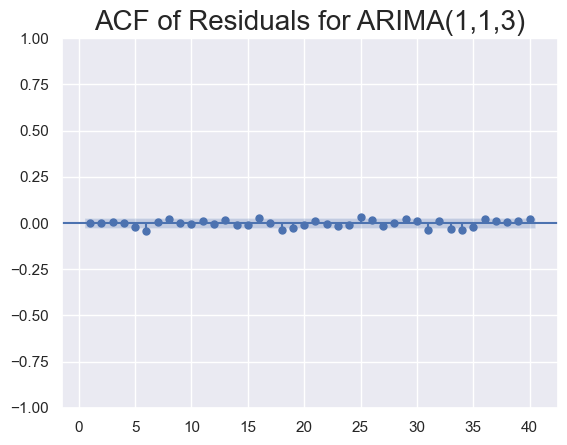

In [170]:
# the two tests yield a value of 0 which means that the model with the highest complexity ARIMA(1,1,3) is better than the nested models
# now let's start examine the ACF of residuals
# if they resemble white noise we will examine and discuss the paramaters from the summary table 
# otherwise we will try to find a better fitting model 
df_train_2['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df_train_2.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
plt.title('ACF of Residuals for ARIMA(1,1,3)', size = 20)
plt.show()

In [171]:
# we see that fewer lags have less significant coefficients for the ARIMA(1,1,3) residuals than the ARIMA(1,1,1) residuals
# however, the sixth is still highly significant, therefore there might exist a better model, which goes up to 6 lags back
# so again we must go through all models up to ARIMA(6,1,6) [ARIMA(1,1,1), ARIMA(6,1,6)] to see if there is a better fit
# since we already went through all models between ARIMA(1,1,1) up to ARIMA(4,1,4), we will start again from where we left
# the following code chunks will fit all models ARIMA(5,1,1) to ARIMA(6,1,6)

# ARIMA(5,1,1)
model_ar_5_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()

# print the summary table
print(results_ar_5_i_1_ma_1.summary())

# ARIMA(5,1,2)
model_ar_5_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (5,1,2))
results_ar_5_i_1_ma_2 = model_ar_5_i_1_ma_2.fit()

# print the summary table
print('\n')
print(results_ar_5_i_1_ma_2.summary())

# ARIMA(5,1,3)
model_ar_5_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (5,1,3))
results_ar_5_i_1_ma_3 = model_ar_5_i_1_ma_3.fit()

# print the summary table
print('\n')
print(results_ar_5_i_1_ma_3.summary())

# ARIMA(5,1,4)
model_ar_5_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (5,1,4))
results_ar_5_i_1_ma_4 = model_ar_5_i_1_ma_4.fit()

# print the summary table
print('\n')
print(results_ar_5_i_1_ma_4.summary())

# ARIMA(5,1,5)
model_ar_5_i_1_ma_5 = ARIMA(df_train_2.market_value, order = (5,1,5))
results_ar_5_i_1_ma_5 = model_ar_5_i_1_ma_5.fit()

# print the summary table
print('\n')
print(results_ar_5_i_1_ma_5.summary())

# ARIMA(5,1,6)
model_ar_5_i_1_ma_6 = ARIMA(df_train_2.market_value, order = (5,1,6))
results_ar_5_i_1_ma_6 = model_ar_5_i_1_ma_6.fit()

# print the summary table
print('\n')
print(results_ar_5_i_1_ma_6.summary())

# ARIMA(6,1,1)
model_ar_6_i_1_ma_1 = ARIMA(df_train_2.market_value, order = (6,1,1))
results_ar_6_i_1_ma_1 = model_ar_6_i_1_ma_1.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_1.summary())

# ARIMA(6,1,2)
model_ar_6_i_1_ma_2 = ARIMA(df_train_2.market_value, order = (6,1,2))
results_ar_6_i_1_ma_2 = model_ar_6_i_1_ma_2.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_2.summary())

# ARIMA(6,1,3)
model_ar_6_i_1_ma_3 = ARIMA(df_train_2.market_value, order = (6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_3.summary())

# ARIMA(6,1,4)
model_ar_6_i_1_ma_4 = ARIMA(df_train_2.market_value, order = (6,1,4))
results_ar_6_i_1_ma_4 = model_ar_6_i_1_ma_4.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_4.summary())

# ARIMA(6,1,5)
model_ar_6_i_1_ma_5 = ARIMA(df_train_2.market_value, order = (6,1,5))
results_ar_6_i_1_ma_5 = model_ar_6_i_1_ma_5.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_5.summary())

# ARIMA(6,1,6)
model_ar_6_i_1_ma_6 = ARIMA(df_train_2.market_value, order = (6,1,6))
results_ar_6_i_1_ma_6 = model_ar_6_i_1_ma_6.fit()

# print the summary table
print('\n')
print(results_ar_6_i_1_ma_6.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27582.931
Date:                Sun, 11 Dec 2022   AIC                          55179.862
Time:                        15:46:54   BIC                          55225.509
Sample:                    01-10-1994   HQIC                         55195.858
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3974      0.154      2.583      0.010       0.096       0.699
ar.L2         -0.0452      0.011     -4.141      0.000      -0.067      -0.024
ar.L3         -0.0512      0.013     -3.959      0.0



                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -27578.331
Date:                Sun, 11 Dec 2022   AIC                          55178.662
Time:                        15:47:06   BIC                          55250.392
Sample:                    01-10-1994   HQIC                         55203.797
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4569      0.157      2.909      0.004       0.149       0.765
ar.L2         -0.6318      0.156     -4.044      0.000      -0.938      -0.326
ar.L3          0.0176      0.153      0.115      0



                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(6, 1, 3)   Log Likelihood              -27579.886
Date:                Sun, 11 Dec 2022   AIC                          55179.772
Time:                        15:47:13   BIC                          55244.982
Sample:                    01-10-1994   HQIC                         55202.623
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0647      0.629      0.103      0.918      -1.167       1.297
ar.L2         -0.3724      0.278     -1.338      0.181      -0.918       0.173
ar.L3         -0.1074      0.363     -0.296      0

In [172]:
# we see that only two models yield significant values ARIMA(5,1,1) and ARIMA(6,1,6)
# now we can estimate which one is best fit by comparing these two models, we also include the ARMA(1,1,3) since it outperforms the other simpler models
print('ARIMA(1,1,3): \tLL = ', results_ar_1_i_1_ma_3.llf, '\tAIC = ', results_ar_1_i_1_ma_3.aic)
print('ARIMA(5,1,1): \tLL = ', results_ar_5_i_1_ma_1.llf, '\tAIC = ', results_ar_5_i_1_ma_1.aic)
print('ARIMA(6,1,6): \tLL = ', results_ar_6_i_1_ma_6.llf, '\tAIC = ', results_ar_6_i_1_ma_6.aic)

ARIMA(1,1,3): 	LL =  -27586.891230860412 	AIC =  55183.782461720824
ARIMA(5,1,1): 	LL =  -27582.93110805133 	AIC =  55179.86221610266
ARIMA(6,1,6): 	LL =  -27577.102241602006 	AIC =  55180.20448320401


In [173]:
# we clearly see that the model ARIMA(6,1,6) yields the highest log-likelihood and the lowest information criteria AIC
# so it's probably the best estimator we can use
# since the ARIMA(1,1,3) and ARIMA(5,1,1) are nested in ARIMA(6,1,3) we can run the LLR test to check if the additional complexity is worth it

# LLR test between ARIMA(1,1,3) and ARIMA(6,1,6) 
# the DF argument need to be set to 5 since the difference in the degrees of freedom is 5
# ARIMA(1,1,3) - 4 degrees of freedom
# ARIMA(6,1,6) - 9 degrees of freedom 
print('LLR test p-value: ', LLR_test(model_ar_1_i_1_ma_3, model_ar_6_i_1_ma_6, DF = 5))

# LLR test between ARIMA(5,1,1) and ARIMA(6,1,6) 
# the DF argument need to be set to 3 since the difference in the degrees of freedom is 3
# ARIMA(5,1,1) - 6 degrees of freedom
# ARIMA(6,1,6) - 9 degrees of freedom 
print('\nLLR test p-value: ', LLR_test(model_ar_5_i_1_ma_1, model_ar_6_i_1_ma_6, DF = 3))

LLR test p-value:  0.001

LLR test p-value:  0.009


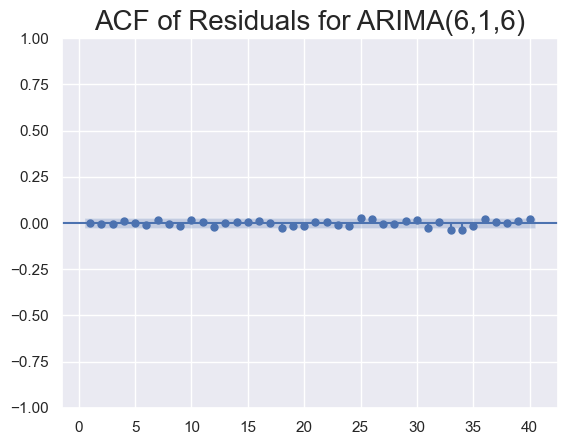

In [174]:
# the LLR tests both yield a value of 0 which is less than 5% significance level which means the higher complexity is rationalized
# therefore, we will opt for the more complex model ARIMA(6,1,6)
# now let's visualize the ACF of the residuals for our model of choice 
df_train_2['res_ar_6_i_1_ma_6'] = results_ar_6_i_1_ma_6.resid
sgt.plot_acf(df_train_2.res_ar_6_i_1_ma_6[1:], zero = False, lags = 40)
plt.title('ACF of Residuals for ARIMA(6,1,6)', size = 20)
plt.show()

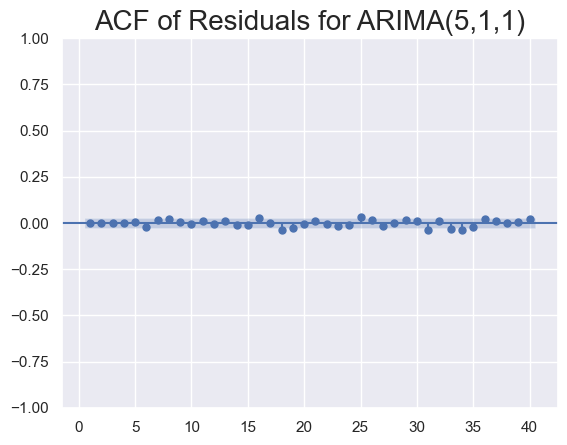

In [175]:
# we see that almost the lags are insignificant
# if we include up to 35 lags back into the model we will be able to have white noise residuals
# on the other hand, we want this model to be able to predict other time-series as well
# taking 35 lags will result in the model parameters becoming too dependant on the dataset which will in turn take away from its predictive power
# this is known as overfitting
# hence after careful consideration I decided to stick with our ARIMA(5,1,1) model as our best estimator for prices
df_train_2['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df_train_2.res_ar_5_i_1_ma_1[1:], zero = False, lags = 40)
plt.title('ACF of Residuals for ARIMA(5,1,1)', size = 20)
plt.show()

**Higher levels of integration**

In [176]:
# we will now explore the idea of multiple degrees of integration
# let's recall that we only rely on integration when our time-series doesn't come from a stationary process 
# hence, if a single layer of integration (d=1) accomplishes this, any additional ones are unnecessary
# to know if the integrated dataset is stationary we can manually create an integrated version of the original time-series and use the Augmented Dickey-Fuller test
# we'll start by creating a col_umn that stores the differences in index prices from period to period
df_train_2['delta_prices'] = df_train_2.market_value.diff(1) # the differences between values 1 period apart

# now we want to fit an ARMA(1,1) to the delta prices
# I used an ARIMA(1,0,1) since it is equivalent to an ARMA(1,1)
# Note: ARMA(P,Q) for integrated prices and an ARIMA(P,1,Q) for prices
model_delta_ar_1_i_0_ma_1 = ARIMA(df_train_2.delta_prices[1:], order = (1,0,1))
results_delta_ar_1_0_ma_1 = model_delta_ar_1_i_0_ma_1.fit()

# print summary table
results_delta_ar_1_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5019
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27598.706
Date:                Sun, 11 Dec 2022   AIC                          55205.413
Time:                        15:47:37   BIC                          55231.497
Sample:                    01-11-1994   HQIC                         55214.553
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5652      0.753      0.751      0.453      -0.911       2.041
ar.L1          0.7476      0.059     12.654      0.000       0.632       0.863
ma.L1         -0.7936      0.053    -14.843      0.000      -0.898      -0.689
sigma2      3497.5233     41.209     84.873      0.000    3416.755    3578.291
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):              3324.61
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
# the ARMA(1,1) has the exact same p-values as the ARIMA(1,1,1) we fit earlier
# after making sure this dataset is very close to the integrated version of prices our model fits, it's time to run the Augmented Dickey-Fuller test
sts.adfuller(df_train_2.delta_prices[1:]) 

(-32.23163395315152,
 0.0,
 5,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 54836.632346563725)

In [178]:
# the result shows that the absolute value of the test statistic is greater than the critical 1% value
# moreover, the p-value is 0.0 so we get our confirmation of stationarity which means there is no need of additional layers of integration
# so models with d > 1 is not recommended since the series is already stationary

**The ARIMAX model**

We are now going to use another type of models that takes into account more than just past prices or past residuals called "MAX" models with the ARMAX its non-integrated version and the ARIMAX its integrated equivalent. 

In [179]:
# let's fit the ARIMAX model
# the exogenenous variable to be specified will be the S&P 500 prices variable
model_ar_1_i_1_ma_1_Xspx = ARIMA(df_train_2.market_value, exog = df_train_2.spx, order = (1,1,1))
results_ar_1_i_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()

# print the summary table
results_ar_1_i_ma_1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26696.766
Date:                Sun, 11 Dec 2022   AIC                          53401.532
Time:                        15:47:38   BIC                          53427.616
Sample:                    01-10-1994   HQIC                         53410.673
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6871      0.035     76.011      0.000       2.618       2.756
ar.L1          0.2501      0.029      8.560      0.000       0.193       0.307
ma.L1         -0.5408      0.025    -21.512      0.000      -0.590      -0.492
sigma2      2441.5403     27.499     88.788      0.000    2387.644    2495.437
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              4351.20
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [180]:
# we can see that we get an additional row for the S&P prices
# the p-value suggest that the S&P prices are not significant here
# we can try adding the other index prices as an exogeneous variable to see if it improves the log-likelihood of the model

**SARIMAX**

The SARIMAX model is identical to the ARIMAX model with a seasonal equivalent. 

In [181]:
# let's fit the SRIMAX model and add the seasonal order
model_sarimax = SARIMAX(df_train_2.market_value, order = (1,0,1), seasonal_order = (2,0,1,5))
results_model_sarimax = model_sarimax.fit()

# print the summary table
results_model_sarimax.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51443D+03    |proj g|=  9.53315D+03

At iterate    5    f=  9.87817D+00    |proj g|=  1.03149D+01

At iterate   10    f=  6.01742D+00    |proj g|=  3.38802D-01

At iterate   15    f=  5.61037D+00    |proj g|=  2.53963D-01

At iterate   20    f=  5.54755D+00    |proj g|=  6.04980D-02

At iterate   25    f=  5.51025D+00    |proj g|=  4.37795D-03

At iterate   30    f=  5.50678D+00    |proj g|=  6.80938D-03

At iterate   35    f=  5.50287D+00    |proj g|=  1.09537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5020
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -27619.336
Date:                           Sun, 11 Dec 2022   AIC                          55250.673
Time:                                   15:47:42   BIC                          55289.800
Sample:                               01-10-1994   HQIC                         55264.383
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2501.689      0.000       0.999       1.000
ma.L1         -0.0210      0.009     -2.407      0.016      -0.038      -0.004
ar.S.L5        0.9645      0.009    107.886      0.000       0.947       0.982
ar.S.L10       0.0353      0.009      4.051      0.000       0.018       0.052
ma.S.L5       -0.9987      0.004   -282.642      0.000      -1.006      -0.992
sigma2      3534.4402     41.822     84.511      0.000    3452.470    3616.410
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3326.27
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **The Auto ARIMA**

**Loading the data**

In [187]:
raw_data = yfinance.download(tickers = '^GSPC ^FTSE ^N225 ^GDAXI', start = '1994-01-07', end = '2018-01-29',
                            interval = '1d', group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [188]:
# create a copy of the data
df_comp = raw_data.copy()

# rename the columns
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

# remove the first row
df_comp = df_comp.iloc[1:]

# remove the original columns
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
del df_comp['^N225']

# using “b” tells Python to expect missing values when the date falls on a Saturday or a Sunday.
# let's apply the asfreq() method and use the value "b" instead
# using the value "b" avoids adding many unnecessary time periods
df_comp = df_comp.asfreq('b')

# fill the missing values
df_comp = df_comp.fillna(method = 'ffill')

**Creating returns**

In [189]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1) * 100
df_comp['ret_ftse'] = df_comp.spx.pct_change(1) * 100
df_comp['ret_dax'] = df_comp.spx.pct_change(1) * 100
df_comp['ret_nikkei'] = df_comp.spx.pct_change(1) * 100

**Splitting the data**

In [190]:
size = int(len(df_comp) * 0.8)
df_train, df_test = df_comp.iloc[:size], df_comp[size:]

**Fitting the model**

In [191]:
# fit the auto_arima model using the ftse data
model_auto = auto_arima(df_train.ret_ftse[1:])

# display the arguments of the model
model_auto

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [192]:
# print the summary table
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5019
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8059.126
Date:                Sun, 11 Dec 2022   AIC                          16126.252
Time:                        15:47:49   BIC                          16152.336
Sample:                             0   HQIC                         16135.393
                               - 5019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.006      1.892      0.058      -0.000       0.025
ar.L1          0.6108      0.053     11.455      0.000       0.506       0.715
ma.L1         -0.6815      0.048    -14.148      0.000      -0.776      -0.587
sigma2         1.4529      0.013    108.668      0.000       1.427       1.479
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             13603.40
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [193]:
# the summary table states that the model is a SARIMAX(1, 0, 1)
# let's recall that the SARIMAX is the most general model
# it includes seasonality, auto regression, integration, moving average and exogenous factors
# so auto_arima takes a SARIMAX model as the backbone
# there are three features of the SARIMAX we can examine
# for starters we know that there are 4 more orders for a seasonal model than a non-seasonal one
# not seeing them here suggests that this is a model without seasonal components
# thus, at most our model could be an ARIMAX than a SARIMAX
# next, since the order of integration d = 0, this is a non-integrated model
# therefore, we are not using an ARIMAX but an ARMAX at most
# additionally, we didn't set an exogenous variable before fitting, we also didn't see one estimated among the coefficients
# so it's safe to assume this is not a "MAX" model
# therefore the most complex this model can be is an ordinary ARMA model
# the auto-regressive order is 1, and the moving-average one is 1
# so as we can see this is an ARMA(4,5)
# let's now draw our attention to the sample values, these values are comprised between 0 and -5019
# our training set contains 5020 elements, so this simply states we are using all of it to get this model


**Basic auto ARIMA arguments**

After discussing the results of the *default* best model, we are going to loosen some of the restrictions and use the auto_arima method to the fullest.

In [197]:
# this time we build our auto_arima model by specifying the following arguments:
# 1. exogenous -> outside factors (e.g other time series)
# 2. m -> seasonal cycle length
# 3. max_order -> maximum amount of variables to be used in the regression (p+q)
# 4. max_p -> maximum AR cmomponents 
# 5. max_q -> maximum MA components
# 6. max_d -> maximum integrations
# 7. maxiter -> maximum iteration we're giving the model to converge the coefficients (becomes harder as the order increases)
# 8. return_valid_fits -> whether or not the method should validate the results
# 9. alpha -> level of significance, default is 5%, which we should be using most of the time
# 10. n_jobs -> how many models to fit at a time, in other words how many CPU cores should be utilized (-1 indicates "as many as possible")
# 11. trend -> "ct" usually
# 12. information criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob'
#            (Akaike Information Criterion, Corrected Akaike Information Criterion,
#             Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#             "out of bag" --for validation scoring--respectively)
# out_of_sample_size -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)
# therefore, we no longer need to plug in the training set, instead we use the entire set
model_auto = auto_arima(df_comp.ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_order = None, max_p = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample_size = int(len(df_comp) * 0.2))

In [195]:
# print the summary table
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 6274
Model:             SARIMAX(0, 1, 2)x(3, 0, [1, 2, 3], 5)   Log Likelihood              -34319.432
Date:                                   Sun, 11 Dec 2022   AIC                          68666.864
Time:                                           21:01:11   BIC                          68761.280
Sample:                                                0   HQIC                         68699.579
                                                  - 6274                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8651      1.956      0.442      0.658      -2.969       4.700
drift       7.311e-06      0.001      0.014      0.989      -0.001       0.001
x1             1.8522      0.090     20.625      0.000       1.676       2.028
x2             1.8522      0.090     20.625      0.000       1.676       2.028
x3             1.8522      0.090     20.625      0.000       1.676       2.028
ma.L1         -0.0065      0.009     -0.697      0.486      -0.025       0.012
ma.L2         -0.0452      0.008     -5.432      0.000      -0.062      -0.029
ar.S.L5        0.2200      0.204      1.080      0.280      -0.179       0.619
ar.S.L10      -0.6492      0.189     -3.437      0.001      -1.020      -0.279
ar.S.L15       0.1519      0.206      0.739      0.460      -0.251       0.555
ma.S.L5       -0.2528      0.203     -1.245      0.213      -0.651       0.145
ma.S.L10       0.6428      0.191      3.367      0.001       0.269       1.017
ma.S.L15      -0.1987      0.206     -0.966      0.334      -0.602       0.204
sigma2      3321.2513     36.145     91.886      0.000    3250.407    3392.095
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              4127.33
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.28
Prob(H) (two-sided):                  0.94   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+21. Standard errors may be unstable.
"""

In [200]:
# the summary table states that the model is a SARIMAX(0, 1, 2)
# this model contains exogenous variables as well as seasonal components 
# the drift coefficient represents the linear trend coefficient 
# we expected to get a constant as well as linear term and their coefficients are the intercept and the drift

# now let's save some of the models we created so far in order to use them for forecasting

# save the simple AR(1) model
pickle.dump(results_ar, open('/Users/papa/Documents/model_ar.sav', 'wb'))

# save the auto_arima model
pickle.dump(model_auto, open('/Users/papa/Documents/auto_arima.sav', 'wb'))